In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pickle
with open('/kaggle/input/asdfgh/ordered_embeddings_dict.pkl', 'rb') as pickle_file:
    ordered_embeddings_dict = pickle.load(pickle_file)

/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [2]:
with open('/kaggle/input/asdfgh/image_tensor_dict.pkl', 'rb') as pickle_file:
    image_tensor_dict = pickle.load(pickle_file)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GenerateC(nn.Module):
    def __init__(self):
        super(GenerateC, self).__init__()
        
    def forward(self, x):
        mean = x[:, :128]  
#         print("mean:" , mean.shape)
        log_sigma = x[:, 128:]
#         print("logsigma:", log_sigma.shape)
        stddev = torch.exp(log_sigma)
#         print("stdev shape:",stddev.shape)
        epsilon = torch.randn(mean.shape[0], mean.shape[1], device=mean.device)
#         print("epsilon shape:",epsilon.shape)
        c = stddev * epsilon + mean
        return c

class ConditionalAugmentation(nn.Module):
    def __init__(self):
        super(ConditionalAugmentation, self).__init__()
        self.fc = nn.Linear(768, 256)  # Adjusted to 768 input and 256 output
        self.lrelu = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        x = self.fc(x)
        x = self.lrelu(x)
        return x

class EmbeddingCompressor(nn.Module):
    def __init__(self):
        super(EmbeddingCompressor, self).__init__()
        self.fc = nn.Linear(768, 256)  # Adjusted to 768 input and 256 output
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.fc(x)
        x = self.relu(x)
        return x

class Stage1Generator(nn.Module):
    def __init__(self):
        super(Stage1Generator, self).__init__()
        self.fc1 = nn.Linear(768, 256)  # Adjusted to 768 input and 256 output
        self.lrelu = nn.LeakyReLU(0.2)
        self.generate_c = GenerateC()
        
        self.fc2 = nn.Linear(128 + 100, 128 * 8 * 4 * 4)  # Adjusted to 256 + 100
        self.relu = nn.ReLU()
        self.reshape = nn.Unflatten(1, (128 * 8, 4, 4))
        
        self.upconv1 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128 * 8, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        
        self.upconv2 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(512, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        
        self.upconv3 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        self.upconv4 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.final_conv = nn.Conv2d(64, 3, kernel_size=3, padding=1, bias=False)
        self.tanh = nn.Tanh()
        
    def forward(self, x1, x2):
        x1= x1.squeeze(1)
        x1=self.fc1(x1)
        mean_logsigma = self.lrelu(x1)
#         print("mean_logsigma shape:", mean_logsigma.shape)
        c = self.generate_c(mean_logsigma)
#         print("c shape",c.shape)
        gen_input = torch.cat([c, x2], dim=1)
#         print("shape after concatenate:", gen_input.shape)
        
        x = self.fc2(gen_input)
        x = self.relu(x)
        x = self.reshape(x)
        
        x = self.upconv1(x)
        x = self.upconv2(x)
        x = self.upconv3(x)
        x = self.upconv4(x)
        x = self.final_conv(x)
        x = self.tanh(x)
        
        return x, mean_logsigma

class Stage1Discriminator(nn.Module):
    def __init__(self):
        super(Stage1Discriminator, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2)
        )
        
        self.conv5 = nn.Conv2d(512, 64 * 8, kernel_size=1, stride=1)
        self.batch_norm = nn.BatchNorm2d(64 * 8)
        self.leaky_relu = nn.LeakyReLU(0.2)
        
        self.fc_embedding = nn.Linear(768, 512 * 4 * 4)
        
        self.conv5_convert = nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1, stride=1, padding=0)
        
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(4 * 4 * 64 * 8, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x1, x2):
#         x1 is the image (generated or real one) x 2 is the text embedding
        x = self.conv1(x1)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x2 = self.fc_embedding(x2)  # [batch_size, 512 * 4 * 4]
        x2 = x2.view(x2.size(0), 512, 4, 4)
#         print(x2.shape) 

        x2 = torch.cat([x, x2], dim=1)
        
        x2= self.conv5_convert(x2)
        x2 = self.conv5(x2)
        x2 = self.batch_norm(x2)
        x2 = self.leaky_relu(x2)
        x2 = self.flatten(x2)
        x2 = self.fc(x2)
        x2 = self.sigmoid(x2)
        
        return x2

class AdversarialModel(nn.Module):
    def __init__(self, gen_model, dis_model):
        super(AdversarialModel, self).__init__()
        self.gen_model = gen_model
        self.dis_model = dis_model
        
    def forward(self, x1, x2):
        x, mean_logsigma = self.gen_model(x1, x2)
        self.dis_model.eval()
        valid = self.dis_model(x, x1)
        return valid, mean_logsigma


In [11]:
def KL_loss(y_pred):
    # Extract mean and log_sigma from y_pred
    mean = y_pred[:, :128]
    log_sigma = y_pred[:, 128:]
    
    # Compute the KL divergence loss
    loss = -log_sigma + 0.5 * (-1 + torch.exp(2. * log_sigma) + mean**2)
    loss = loss.mean()
    
    return loss

def custom_generator_loss(y_true, y_pred):
    criterion = nn.BCEWithLogitsLoss()
    return criterion(y_pred, y_true)

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def save_rgb_img(img, path):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    
    if isinstance(img, torch.Tensor):
        img = img.detach().permute(1, 2, 0).cpu().numpy()  # Convert CHW to HWC and move to CPU
    
    ax.imshow(img)
    ax.axis("off")
    ax.set_title("Image")

    plt.savefig(path)
    plt.close()
    


In [4]:
from torch.utils.tensorboard import SummaryWriter

def write_log(writer, name, loss, global_step):
    writer.add_scalar(name, loss, global_step)

In [5]:
def plot_generated_images(images, epoch, n_images=8):

    fig, axes = plt.subplots(1, n_images, figsize=(n_images * 2, 2)) 
    for i in range(n_images):
        ax = axes[i]
        img = images[i].detach().permute(1, 2, 0).cpu().numpy()
        ax.imshow(img)
        ax.axis("off")  
    plt.suptitle(f'Generated Images at Epoch {epoch}') 
    plt.show()

Epochs:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [0/250] Step [0] Discriminator Loss: 1.410816729068756 Generator Loss: 0.2596118748188019
Epoch [0/250] Step [1600] Discriminator Loss: 1.3620127439498901 Generator Loss: 0.19466231763362885
Epoch [0/250] Step [3200] Discriminator Loss: 1.3858429193496704 Generator Loss: 0.17451171576976776
Epoch [0/250] Step [4800] Discriminator Loss: 1.3329278230667114 Generator Loss: 0.23591507971286774
Epoch [0/250] Step [6400] Discriminator Loss: 1.435850441455841 Generator Loss: 0.39789101481437683


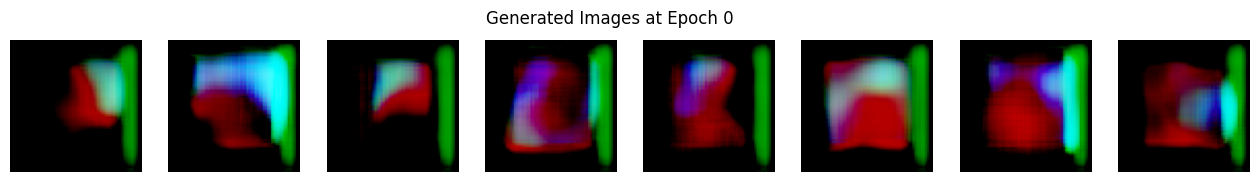

Epochs:   0%|          | 1/250 [00:18<1:16:28, 18.43s/it]

Epoch [1/250] Step [0] Discriminator Loss: 1.4201646447181702 Generator Loss: 0.1744634509086609
Epoch [1/250] Step [600] Discriminator Loss: 1.3127927780151367 Generator Loss: 0.23065325617790222
Epoch [1/250] Step [1200] Discriminator Loss: 1.4470699429512024 Generator Loss: 0.3095797300338745
Epoch [1/250] Step [1800] Discriminator Loss: 1.1285405158996582 Generator Loss: 0.35839226841926575
Epoch [1/250] Step [2400] Discriminator Loss: 1.496915876865387 Generator Loss: 0.4233821928501129
Epoch [1/250] Step [3000] Discriminator Loss: 1.3484086990356445 Generator Loss: 0.20273751020431519
Epoch [1/250] Step [3600] Discriminator Loss: 1.3245826363563538 Generator Loss: 0.2441154271364212
Epoch [1/250] Step [4200] Discriminator Loss: 1.3807008862495422 Generator Loss: 0.16769029200077057
Epoch [1/250] Step [4800] Discriminator Loss: 1.3468359112739563 Generator Loss: 0.1904793232679367
Epoch [1/250] Step [5400] Discriminator Loss: 1.2367198467254639 Generator Loss: 0.26452532410621643


Epochs:   1%|          | 2/250 [00:41<1:27:00, 21.05s/it]

Epoch [2/250] Step [0] Discriminator Loss: 1.2068668603897095 Generator Loss: 0.5894326567649841
Epoch [2/250] Step [600] Discriminator Loss: 1.3482853770256042 Generator Loss: 0.21534278988838196
Epoch [2/250] Step [1200] Discriminator Loss: 1.295656532049179 Generator Loss: 0.47564074397087097
Epoch [2/250] Step [1800] Discriminator Loss: 1.4829845428466797 Generator Loss: 0.20149561762809753
Epoch [2/250] Step [2400] Discriminator Loss: 1.376418113708496 Generator Loss: 0.16426227986812592
Epoch [2/250] Step [3000] Discriminator Loss: 1.3622044324874878 Generator Loss: 0.20164400339126587
Epoch [2/250] Step [3600] Discriminator Loss: 1.329503357410431 Generator Loss: 0.19510886073112488
Epoch [2/250] Step [4200] Discriminator Loss: 1.3540269136428833 Generator Loss: 0.1746797412633896
Epoch [2/250] Step [4800] Discriminator Loss: 1.3820888996124268 Generator Loss: 0.1902562379837036
Epoch [2/250] Step [5400] Discriminator Loss: 1.3628264665603638 Generator Loss: 0.18265767395496368


Epochs:   1%|          | 3/250 [01:04<1:31:01, 22.11s/it]

Epoch [3/250] Step [0] Discriminator Loss: 1.381421446800232 Generator Loss: 0.16119468212127686
Epoch [3/250] Step [600] Discriminator Loss: 1.3422443866729736 Generator Loss: 0.21012791991233826
Epoch [3/250] Step [1200] Discriminator Loss: 1.3836705088615417 Generator Loss: 0.17757004499435425
Epoch [3/250] Step [1800] Discriminator Loss: 1.3618155121803284 Generator Loss: 0.19821259379386902
Epoch [3/250] Step [2400] Discriminator Loss: 1.3881132006645203 Generator Loss: 0.21578598022460938
Epoch [3/250] Step [3000] Discriminator Loss: 1.3638245463371277 Generator Loss: 0.19972209632396698
Epoch [3/250] Step [3600] Discriminator Loss: 1.4350786805152893 Generator Loss: 0.17367541790008545
Epoch [3/250] Step [4200] Discriminator Loss: 1.3624431490898132 Generator Loss: 0.15634779632091522
Epoch [3/250] Step [4800] Discriminator Loss: 1.1855388283729553 Generator Loss: 0.26824715733528137
Epoch [3/250] Step [5400] Discriminator Loss: 1.3770473003387451 Generator Loss: 0.2354124486446

Epochs:   2%|▏         | 4/250 [01:27<1:32:07, 22.47s/it]

Epoch [4/250] Step [0] Discriminator Loss: 1.1019909977912903 Generator Loss: 0.34999001026153564
Epoch [4/250] Step [600] Discriminator Loss: 1.2418619990348816 Generator Loss: 0.2608043849468231
Epoch [4/250] Step [1200] Discriminator Loss: 1.2535940408706665 Generator Loss: 0.23494163155555725
Epoch [4/250] Step [1800] Discriminator Loss: 1.6590066850185394 Generator Loss: 0.2629569172859192
Epoch [4/250] Step [2400] Discriminator Loss: 1.3546670079231262 Generator Loss: 0.1931840479373932
Epoch [4/250] Step [3000] Discriminator Loss: 1.2519327402114868 Generator Loss: 0.2168743759393692
Epoch [4/250] Step [3600] Discriminator Loss: 1.2832530736923218 Generator Loss: 0.29291296005249023
Epoch [4/250] Step [4200] Discriminator Loss: 1.2753698825836182 Generator Loss: 0.18099148571491241
Epoch [4/250] Step [4800] Discriminator Loss: 1.2370986342430115 Generator Loss: 0.31796926259994507
Epoch [4/250] Step [5400] Discriminator Loss: 1.3035425543785095 Generator Loss: 0.2244570553302765

Epochs:   2%|▏         | 5/250 [01:50<1:32:21, 22.62s/it]

Epoch [5/250] Step [0] Discriminator Loss: 1.3048065304756165 Generator Loss: 0.21129858493804932
Epoch [5/250] Step [600] Discriminator Loss: 1.391987383365631 Generator Loss: 0.28013816475868225
Epoch [5/250] Step [1200] Discriminator Loss: 1.3710185289382935 Generator Loss: 0.2374870479106903
Epoch [5/250] Step [1800] Discriminator Loss: 1.4199910163879395 Generator Loss: 0.23435384035110474
Epoch [5/250] Step [2400] Discriminator Loss: 1.307035744190216 Generator Loss: 0.18436473608016968
Epoch [5/250] Step [3000] Discriminator Loss: 1.3801122903823853 Generator Loss: 0.22984899580478668
Epoch [5/250] Step [3600] Discriminator Loss: 1.4176338911056519 Generator Loss: 0.20681948959827423
Epoch [5/250] Step [4200] Discriminator Loss: 1.3795149326324463 Generator Loss: 0.21943454444408417
Epoch [5/250] Step [4800] Discriminator Loss: 1.29546457529068 Generator Loss: 0.23289412260055542
Epoch [5/250] Step [5400] Discriminator Loss: 1.3211182951927185 Generator Loss: 0.31612691283226013

Epochs:   2%|▏         | 6/250 [02:13<1:32:38, 22.78s/it]

Epoch [6/250] Step [0] Discriminator Loss: 1.3765943050384521 Generator Loss: 0.20498129725456238
Epoch [6/250] Step [600] Discriminator Loss: 1.3696775436401367 Generator Loss: 0.2385554313659668
Epoch [6/250] Step [1200] Discriminator Loss: 1.4682854413986206 Generator Loss: 0.2586340606212616
Epoch [6/250] Step [1800] Discriminator Loss: 1.336394727230072 Generator Loss: 0.28194621205329895
Epoch [6/250] Step [2400] Discriminator Loss: 1.2445363402366638 Generator Loss: 0.22512468695640564
Epoch [6/250] Step [3000] Discriminator Loss: 1.3420573472976685 Generator Loss: 0.21604202687740326
Epoch [6/250] Step [3600] Discriminator Loss: 1.2893571853637695 Generator Loss: 0.3305756449699402
Epoch [6/250] Step [4200] Discriminator Loss: 1.2572765946388245 Generator Loss: 0.23266004025936127
Epoch [6/250] Step [4800] Discriminator Loss: 1.3831717371940613 Generator Loss: 0.20279556512832642
Epoch [6/250] Step [5400] Discriminator Loss: 1.2990402579307556 Generator Loss: 0.1970723122358322

Epochs:   3%|▎         | 7/250 [02:36<1:32:43, 22.89s/it]

Epoch [7/250] Step [0] Discriminator Loss: 1.3438547253608704 Generator Loss: 0.22066770493984222
Epoch [7/250] Step [600] Discriminator Loss: 1.2355849146842957 Generator Loss: 0.18255853652954102
Epoch [7/250] Step [1200] Discriminator Loss: 1.3086191415786743 Generator Loss: 0.20200994610786438
Epoch [7/250] Step [1800] Discriminator Loss: 1.3031901121139526 Generator Loss: 0.2217147946357727
Epoch [7/250] Step [2400] Discriminator Loss: 1.2859758138656616 Generator Loss: 0.28577324748039246
Epoch [7/250] Step [3000] Discriminator Loss: 1.3199159502983093 Generator Loss: 0.24941448867321014
Epoch [7/250] Step [3600] Discriminator Loss: 1.3302755951881409 Generator Loss: 0.25282496213912964
Epoch [7/250] Step [4200] Discriminator Loss: 1.250803828239441 Generator Loss: 0.3118029832839966
Epoch [7/250] Step [4800] Discriminator Loss: 1.3430652618408203 Generator Loss: 0.28588226437568665
Epoch [7/250] Step [5400] Discriminator Loss: 1.2391684651374817 Generator Loss: 0.181976065039634

Epochs:   3%|▎         | 8/250 [02:59<1:32:32, 22.94s/it]

Epoch [8/250] Step [0] Discriminator Loss: 1.321437418460846 Generator Loss: 0.3141961395740509
Epoch [8/250] Step [600] Discriminator Loss: 1.3066881895065308 Generator Loss: 0.2826118469238281
Epoch [8/250] Step [1200] Discriminator Loss: 1.3281317353248596 Generator Loss: 0.4410684406757355
Epoch [8/250] Step [1800] Discriminator Loss: 1.2489814758300781 Generator Loss: 0.26401567459106445
Epoch [8/250] Step [2400] Discriminator Loss: 1.4113097190856934 Generator Loss: 0.1387884020805359
Epoch [8/250] Step [3000] Discriminator Loss: 1.2116056680679321 Generator Loss: 0.24579006433486938
Epoch [8/250] Step [3600] Discriminator Loss: 1.1826105117797852 Generator Loss: 0.2507472038269043
Epoch [8/250] Step [4200] Discriminator Loss: 1.2820290327072144 Generator Loss: 0.2512744069099426
Epoch [8/250] Step [4800] Discriminator Loss: 1.166089415550232 Generator Loss: 0.270015150308609
Epoch [8/250] Step [5400] Discriminator Loss: 1.316378891468048 Generator Loss: 0.3759021461009979
Epoch 

Epochs:   4%|▎         | 9/250 [03:22<1:32:17, 22.98s/it]

Epoch [9/250] Step [0] Discriminator Loss: 1.1933473348617554 Generator Loss: 0.28972575068473816
Epoch [9/250] Step [600] Discriminator Loss: 1.3759658336639404 Generator Loss: 0.23412129282951355
Epoch [9/250] Step [1200] Discriminator Loss: 1.177718698978424 Generator Loss: 0.2834693193435669
Epoch [9/250] Step [1800] Discriminator Loss: 1.2853885889053345 Generator Loss: 0.23657594621181488
Epoch [9/250] Step [2400] Discriminator Loss: 1.2543931603431702 Generator Loss: 0.2179478108882904
Epoch [9/250] Step [3000] Discriminator Loss: 1.2505736351013184 Generator Loss: 0.33086341619491577
Epoch [9/250] Step [3600] Discriminator Loss: 1.268431544303894 Generator Loss: 0.3567968010902405
Epoch [9/250] Step [4200] Discriminator Loss: 1.2686221897602081 Generator Loss: 0.2746100127696991
Epoch [9/250] Step [4800] Discriminator Loss: 1.1932992935180664 Generator Loss: 0.23567570745944977
Epoch [9/250] Step [5400] Discriminator Loss: 1.2876607179641724 Generator Loss: 0.2877569794654846
E

Epochs:   4%|▍         | 10/250 [03:45<1:31:55, 22.98s/it]

Epoch [10/250] Step [0] Discriminator Loss: 1.2221501469612122 Generator Loss: 0.31066712737083435
Epoch [10/250] Step [600] Discriminator Loss: 1.185965120792389 Generator Loss: 0.33534932136535645
Epoch [10/250] Step [1200] Discriminator Loss: 1.2129635214805603 Generator Loss: 0.3037809729576111
Epoch [10/250] Step [1800] Discriminator Loss: 1.135822594165802 Generator Loss: 0.31088730692863464
Epoch [10/250] Step [2400] Discriminator Loss: 1.284028172492981 Generator Loss: 0.4220955967903137
Epoch [10/250] Step [3000] Discriminator Loss: 1.1049540638923645 Generator Loss: 0.34186840057373047
Epoch [10/250] Step [3600] Discriminator Loss: 1.2394713163375854 Generator Loss: 0.2610042989253998
Epoch [10/250] Step [4200] Discriminator Loss: 1.2155995965003967 Generator Loss: 0.418337345123291
Epoch [10/250] Step [4800] Discriminator Loss: 1.3636167347431183 Generator Loss: 0.22214314341545105
Epoch [10/250] Step [5400] Discriminator Loss: 1.2298754453659058 Generator Loss: 0.2530889809

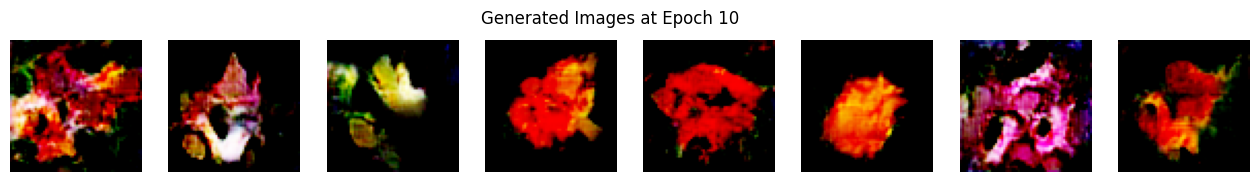

Epochs:   4%|▍         | 11/250 [04:09<1:32:13, 23.15s/it]

Epoch [11/250] Step [0] Discriminator Loss: 1.2051674127578735 Generator Loss: 0.2848489284515381
Epoch [11/250] Step [600] Discriminator Loss: 1.1227903366088867 Generator Loss: 0.3278072774410248
Epoch [11/250] Step [1200] Discriminator Loss: 1.0783429443836212 Generator Loss: 0.3523711860179901
Epoch [11/250] Step [1800] Discriminator Loss: 1.3222053945064545 Generator Loss: 0.37420764565467834
Epoch [11/250] Step [2400] Discriminator Loss: 1.2857518196105957 Generator Loss: 0.2831827402114868
Epoch [11/250] Step [3000] Discriminator Loss: 1.1120778918266296 Generator Loss: 0.2984437644481659
Epoch [11/250] Step [3600] Discriminator Loss: 1.1432335078716278 Generator Loss: 0.43096083402633667
Epoch [11/250] Step [4200] Discriminator Loss: 1.1406943202018738 Generator Loss: 0.3733241856098175
Epoch [11/250] Step [4800] Discriminator Loss: 1.337360441684723 Generator Loss: 0.3524054288864136
Epoch [11/250] Step [5400] Discriminator Loss: 1.169060081243515 Generator Loss: 0.29358452558

Epochs:   5%|▍         | 12/250 [04:32<1:31:48, 23.14s/it]

Epoch [12/250] Step [0] Discriminator Loss: 1.050959289073944 Generator Loss: 0.3386519253253937
Epoch [12/250] Step [600] Discriminator Loss: 1.0974423587322235 Generator Loss: 0.3742026686668396
Epoch [12/250] Step [1200] Discriminator Loss: 1.20870840549469 Generator Loss: 0.44408443570137024
Epoch [12/250] Step [1800] Discriminator Loss: 1.1320990920066833 Generator Loss: 0.3116227388381958
Epoch [12/250] Step [2400] Discriminator Loss: 1.2100169360637665 Generator Loss: 0.21182295680046082
Epoch [12/250] Step [3000] Discriminator Loss: 1.145289123058319 Generator Loss: 0.49026185274124146
Epoch [12/250] Step [3600] Discriminator Loss: 1.2153796553611755 Generator Loss: 0.46076270937919617
Epoch [12/250] Step [4200] Discriminator Loss: 1.1220653057098389 Generator Loss: 0.330972820520401
Epoch [12/250] Step [4800] Discriminator Loss: 1.1079977750778198 Generator Loss: 0.36265549063682556
Epoch [12/250] Step [5400] Discriminator Loss: 1.1782705783843994 Generator Loss: 0.34447768330

Epochs:   5%|▌         | 13/250 [04:55<1:31:24, 23.14s/it]

Epoch [13/250] Step [0] Discriminator Loss: 1.0769819021224976 Generator Loss: 0.42629754543304443
Epoch [13/250] Step [600] Discriminator Loss: 1.0639248490333557 Generator Loss: 0.43694204092025757
Epoch [13/250] Step [1200] Discriminator Loss: 0.9830241799354553 Generator Loss: 0.35498347878456116
Epoch [13/250] Step [1800] Discriminator Loss: 1.1424689888954163 Generator Loss: 0.39089009165763855
Epoch [13/250] Step [2400] Discriminator Loss: 1.0908406972885132 Generator Loss: 0.37406980991363525
Epoch [13/250] Step [3000] Discriminator Loss: 1.3917116820812225 Generator Loss: 0.27922946214675903
Epoch [13/250] Step [3600] Discriminator Loss: 1.1195867955684662 Generator Loss: 0.5414375066757202
Epoch [13/250] Step [4200] Discriminator Loss: 1.0122750997543335 Generator Loss: 0.4531788229942322
Epoch [13/250] Step [4800] Discriminator Loss: 1.268317997455597 Generator Loss: 0.5125970840454102
Epoch [13/250] Step [5400] Discriminator Loss: 1.0396553874015808 Generator Loss: 0.287542

Epochs:   6%|▌         | 14/250 [05:18<1:30:59, 23.14s/it]

Epoch [14/250] Step [0] Discriminator Loss: 1.019402027130127 Generator Loss: 0.42154717445373535
Epoch [14/250] Step [600] Discriminator Loss: 1.006714552640915 Generator Loss: 0.4449233412742615
Epoch [14/250] Step [1200] Discriminator Loss: 1.0263813734054565 Generator Loss: 0.47556477785110474
Epoch [14/250] Step [1800] Discriminator Loss: 1.126219630241394 Generator Loss: 0.561370313167572
Epoch [14/250] Step [2400] Discriminator Loss: 0.9570626616477966 Generator Loss: 0.4287615418434143
Epoch [14/250] Step [3000] Discriminator Loss: 0.9218128323554993 Generator Loss: 0.5134694576263428
Epoch [14/250] Step [3600] Discriminator Loss: 1.168088674545288 Generator Loss: 0.47790417075157166
Epoch [14/250] Step [4200] Discriminator Loss: 1.2279469668865204 Generator Loss: 0.7075520157814026
Epoch [14/250] Step [4800] Discriminator Loss: 0.9957415163516998 Generator Loss: 0.4596221446990967
Epoch [14/250] Step [5400] Discriminator Loss: 1.0615001916885376 Generator Loss: 0.3432422876358

Epochs:   6%|▌         | 15/250 [05:41<1:30:33, 23.12s/it]

Epoch [15/250] Step [0] Discriminator Loss: 0.9927535057067871 Generator Loss: 0.4259197413921356
Epoch [15/250] Step [600] Discriminator Loss: 1.0010011196136475 Generator Loss: 0.43496689200401306
Epoch [15/250] Step [1200] Discriminator Loss: 0.8474821746349335 Generator Loss: 0.3683697581291199
Epoch [15/250] Step [1800] Discriminator Loss: 1.1454585194587708 Generator Loss: 0.5597158670425415
Epoch [15/250] Step [2400] Discriminator Loss: 1.0315446257591248 Generator Loss: 0.5177047848701477
Epoch [15/250] Step [3000] Discriminator Loss: 0.9767045080661774 Generator Loss: 0.3175801634788513
Epoch [15/250] Step [3600] Discriminator Loss: 1.0182631611824036 Generator Loss: 0.4138261675834656
Epoch [15/250] Step [4200] Discriminator Loss: 1.0836660265922546 Generator Loss: 0.4547388255596161
Epoch [15/250] Step [4800] Discriminator Loss: 1.075655996799469 Generator Loss: 0.5176557302474976
Epoch [15/250] Step [5400] Discriminator Loss: 1.0220199227333069 Generator Loss: 0.43677747249

Epochs:   6%|▋         | 16/250 [06:04<1:30:06, 23.10s/it]

Epoch [16/250] Step [0] Discriminator Loss: 0.9242455363273621 Generator Loss: 0.5824839472770691
Epoch [16/250] Step [600] Discriminator Loss: 0.9346951246261597 Generator Loss: 0.5506852269172668
Epoch [16/250] Step [1200] Discriminator Loss: 0.917894184589386 Generator Loss: 0.5739672780036926
Epoch [16/250] Step [1800] Discriminator Loss: 0.9917522668838501 Generator Loss: 0.39127790927886963
Epoch [16/250] Step [2400] Discriminator Loss: 0.8966071009635925 Generator Loss: 0.5386416912078857
Epoch [16/250] Step [3000] Discriminator Loss: 1.0361298322677612 Generator Loss: 0.5702651143074036
Epoch [16/250] Step [3600] Discriminator Loss: 1.0864444375038147 Generator Loss: 0.37098634243011475
Epoch [16/250] Step [4200] Discriminator Loss: 0.9924103021621704 Generator Loss: 0.3438926637172699
Epoch [16/250] Step [4800] Discriminator Loss: 0.9672438502311707 Generator Loss: 0.43844106793403625
Epoch [16/250] Step [5400] Discriminator Loss: 0.9773760437965393 Generator Loss: 0.388628065

Epochs:   7%|▋         | 17/250 [06:28<1:29:37, 23.08s/it]

Epoch [17/250] Step [0] Discriminator Loss: 0.8949080407619476 Generator Loss: 0.493918240070343
Epoch [17/250] Step [600] Discriminator Loss: 0.8456296920776367 Generator Loss: 0.5367113351821899
Epoch [17/250] Step [1200] Discriminator Loss: 1.042550414800644 Generator Loss: 0.4976308345794678
Epoch [17/250] Step [1800] Discriminator Loss: 1.0066445171833038 Generator Loss: 0.35304129123687744
Epoch [17/250] Step [2400] Discriminator Loss: 0.9851234555244446 Generator Loss: 0.6023887991905212
Epoch [17/250] Step [3000] Discriminator Loss: 0.8781769871711731 Generator Loss: 0.49332645535469055
Epoch [17/250] Step [3600] Discriminator Loss: 0.9429799914360046 Generator Loss: 0.4659225642681122
Epoch [17/250] Step [4200] Discriminator Loss: 0.9532433450222015 Generator Loss: 0.40905827283859253
Epoch [17/250] Step [4800] Discriminator Loss: 0.9252278208732605 Generator Loss: 0.5446577072143555
Epoch [17/250] Step [5400] Discriminator Loss: 1.0009329617023468 Generator Loss: 0.4502469003

Epochs:   7%|▋         | 18/250 [06:51<1:29:09, 23.06s/it]

Epoch [18/250] Step [0] Discriminator Loss: 0.8904761970043182 Generator Loss: 0.553183376789093
Epoch [18/250] Step [600] Discriminator Loss: 0.8517332673072815 Generator Loss: 0.5237954258918762
Epoch [18/250] Step [1200] Discriminator Loss: 0.891622930765152 Generator Loss: 0.4637046158313751
Epoch [18/250] Step [1800] Discriminator Loss: 0.8820454478263855 Generator Loss: 0.6073859930038452
Epoch [18/250] Step [2400] Discriminator Loss: 0.9242735803127289 Generator Loss: 0.5645381212234497
Epoch [18/250] Step [3000] Discriminator Loss: 0.8508219420909882 Generator Loss: 0.5487251877784729
Epoch [18/250] Step [3600] Discriminator Loss: 1.2223235368728638 Generator Loss: 0.40330395102500916
Epoch [18/250] Step [4200] Discriminator Loss: 0.8726629018783569 Generator Loss: 0.5735322833061218
Epoch [18/250] Step [4800] Discriminator Loss: 0.8655841946601868 Generator Loss: 0.4285728335380554
Epoch [18/250] Step [5400] Discriminator Loss: 0.8309772312641144 Generator Loss: 0.565764367580

Epochs:   8%|▊         | 19/250 [07:14<1:28:42, 23.04s/it]

Epoch [19/250] Step [0] Discriminator Loss: 0.8762615025043488 Generator Loss: 0.5497153997421265
Epoch [19/250] Step [600] Discriminator Loss: 0.989624947309494 Generator Loss: 0.6348792314529419
Epoch [19/250] Step [1200] Discriminator Loss: 0.8585518300533295 Generator Loss: 0.45842599868774414
Epoch [19/250] Step [1800] Discriminator Loss: 0.8866489827632904 Generator Loss: 0.5328307747840881
Epoch [19/250] Step [2400] Discriminator Loss: 0.9593132138252258 Generator Loss: 0.5072882771492004
Epoch [19/250] Step [3000] Discriminator Loss: 0.9127810001373291 Generator Loss: 0.5859471559524536
Epoch [19/250] Step [3600] Discriminator Loss: 0.8953279852867126 Generator Loss: 0.6651672720909119
Epoch [19/250] Step [4200] Discriminator Loss: 1.0445472300052643 Generator Loss: 0.48077622056007385
Epoch [19/250] Step [4800] Discriminator Loss: 0.8231826424598694 Generator Loss: 0.46047571301460266
Epoch [19/250] Step [5400] Discriminator Loss: 0.9489565789699554 Generator Loss: 0.521023392

Epochs:   8%|▊         | 20/250 [07:37<1:28:18, 23.04s/it]

Epoch [20/250] Step [0] Discriminator Loss: 0.8506204783916473 Generator Loss: 0.6179179549217224
Epoch [20/250] Step [600] Discriminator Loss: 0.8191259205341339 Generator Loss: 0.5723804831504822
Epoch [20/250] Step [1200] Discriminator Loss: 0.9945315718650818 Generator Loss: 0.4409911334514618
Epoch [20/250] Step [1800] Discriminator Loss: 0.9330838620662689 Generator Loss: 0.590403139591217
Epoch [20/250] Step [2400] Discriminator Loss: 0.8100517392158508 Generator Loss: 0.5292766690254211
Epoch [20/250] Step [3000] Discriminator Loss: 0.7902820408344269 Generator Loss: 0.4555179476737976
Epoch [20/250] Step [3600] Discriminator Loss: 0.8892398178577423 Generator Loss: 0.591701328754425
Epoch [20/250] Step [4200] Discriminator Loss: 0.9845909476280212 Generator Loss: 0.6115595698356628
Epoch [20/250] Step [4800] Discriminator Loss: 0.7939978241920471 Generator Loss: 0.6025770902633667
Epoch [20/250] Step [5400] Discriminator Loss: 0.8141787946224213 Generator Loss: 0.4625638723373

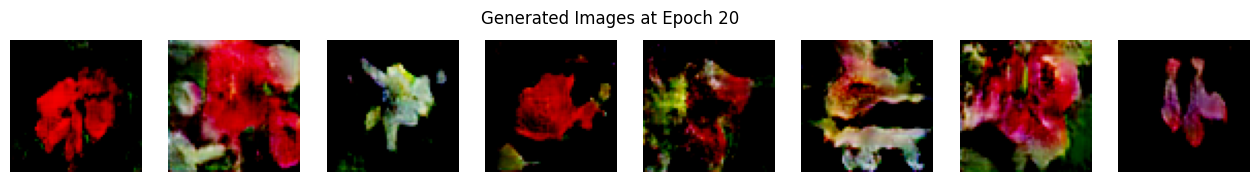

Epochs:   8%|▊         | 21/250 [08:00<1:28:41, 23.24s/it]

Epoch [21/250] Step [0] Discriminator Loss: 0.7832108438014984 Generator Loss: 0.562990128993988
Epoch [21/250] Step [600] Discriminator Loss: 0.8250946402549744 Generator Loss: 0.5575576424598694
Epoch [21/250] Step [1200] Discriminator Loss: 0.8317032754421234 Generator Loss: 0.6114047169685364
Epoch [21/250] Step [1800] Discriminator Loss: 0.7868534922599792 Generator Loss: 0.6409923434257507
Epoch [21/250] Step [2400] Discriminator Loss: 0.7746469378471375 Generator Loss: 0.5853735208511353
Epoch [21/250] Step [3000] Discriminator Loss: 0.7986305356025696 Generator Loss: 0.5213600993156433
Epoch [21/250] Step [3600] Discriminator Loss: 0.8103601336479187 Generator Loss: 0.6124528050422668
Epoch [21/250] Step [4200] Discriminator Loss: 0.7474840879440308 Generator Loss: 0.6507922410964966
Epoch [21/250] Step [4800] Discriminator Loss: 0.8368381857872009 Generator Loss: 0.5737851858139038
Epoch [21/250] Step [5400] Discriminator Loss: 0.8255214691162109 Generator Loss: 0.613707602024

Epochs:   9%|▉         | 22/250 [08:23<1:28:11, 23.21s/it]

Epoch [22/250] Step [0] Discriminator Loss: 0.8713480830192566 Generator Loss: 0.6297544836997986
Epoch [22/250] Step [600] Discriminator Loss: 0.7770285606384277 Generator Loss: 0.6227745413780212
Epoch [22/250] Step [1200] Discriminator Loss: 0.8792072236537933 Generator Loss: 0.6601921319961548
Epoch [22/250] Step [1800] Discriminator Loss: 0.9140121936798096 Generator Loss: 0.6094867587089539
Epoch [22/250] Step [2400] Discriminator Loss: 0.7674936652183533 Generator Loss: 0.47676971554756165
Epoch [22/250] Step [3000] Discriminator Loss: 0.8773024380207062 Generator Loss: 0.5504587888717651
Epoch [22/250] Step [3600] Discriminator Loss: 0.8210930228233337 Generator Loss: 0.5864838361740112
Epoch [22/250] Step [4200] Discriminator Loss: 0.9034878015518188 Generator Loss: 0.5733330845832825
Epoch [22/250] Step [4800] Discriminator Loss: 0.8664742410182953 Generator Loss: 0.5330593585968018
Epoch [22/250] Step [5400] Discriminator Loss: 0.8766682147979736 Generator Loss: 0.5389612913

Epochs:   9%|▉         | 23/250 [08:47<1:27:42, 23.18s/it]

Epoch [23/250] Step [0] Discriminator Loss: 0.8524197936058044 Generator Loss: 0.625457227230072
Epoch [23/250] Step [600] Discriminator Loss: 0.8897795081138611 Generator Loss: 0.5562368631362915
Epoch [23/250] Step [1200] Discriminator Loss: 0.9195998907089233 Generator Loss: 0.49313047528266907
Epoch [23/250] Step [1800] Discriminator Loss: 0.8410037159919739 Generator Loss: 0.6016419529914856
Epoch [23/250] Step [2400] Discriminator Loss: 0.885991781949997 Generator Loss: 0.5557821989059448
Epoch [23/250] Step [3000] Discriminator Loss: 0.8187447786331177 Generator Loss: 0.6680549383163452
Epoch [23/250] Step [3600] Discriminator Loss: 0.8619682788848877 Generator Loss: 0.6393494606018066
Epoch [23/250] Step [4200] Discriminator Loss: 0.749078243970871 Generator Loss: 0.6231966614723206
Epoch [23/250] Step [4800] Discriminator Loss: 0.79620760679245 Generator Loss: 0.5200533270835876
Epoch [23/250] Step [5400] Discriminator Loss: 0.7737199366092682 Generator Loss: 0.533801853656768

Epochs:  10%|▉         | 24/250 [09:10<1:27:11, 23.15s/it]

Epoch [24/250] Step [0] Discriminator Loss: 0.7496053576469421 Generator Loss: 0.5063862800598145
Epoch [24/250] Step [600] Discriminator Loss: 0.8089592158794403 Generator Loss: 0.5352938175201416
Epoch [24/250] Step [1200] Discriminator Loss: 0.7232963144779205 Generator Loss: 0.6796967387199402
Epoch [24/250] Step [1800] Discriminator Loss: 0.8566121459007263 Generator Loss: 0.47389134764671326
Epoch [24/250] Step [2400] Discriminator Loss: 0.9441776871681213 Generator Loss: 0.6961942911148071
Epoch [24/250] Step [3000] Discriminator Loss: 0.8390371203422546 Generator Loss: 0.5384852290153503
Epoch [24/250] Step [3600] Discriminator Loss: 0.8260289430618286 Generator Loss: 0.6843147873878479
Epoch [24/250] Step [4200] Discriminator Loss: 0.7990229427814484 Generator Loss: 0.6128155589103699
Epoch [24/250] Step [4800] Discriminator Loss: 0.7906740605831146 Generator Loss: 0.5619418025016785
Epoch [24/250] Step [5400] Discriminator Loss: 0.822472870349884 Generator Loss: 0.56437689065

Epochs:  10%|█         | 25/250 [09:33<1:26:42, 23.12s/it]

Epoch [25/250] Step [0] Discriminator Loss: 0.8149768710136414 Generator Loss: 0.5939841866493225
Epoch [25/250] Step [600] Discriminator Loss: 0.8408264517784119 Generator Loss: 0.6265650987625122
Epoch [25/250] Step [1200] Discriminator Loss: 0.8155774474143982 Generator Loss: 0.687929630279541
Epoch [25/250] Step [1800] Discriminator Loss: 0.8280517160892487 Generator Loss: 0.5593698024749756
Epoch [25/250] Step [2400] Discriminator Loss: 0.805890679359436 Generator Loss: 0.5915257334709167
Epoch [25/250] Step [3000] Discriminator Loss: 0.8377076685428619 Generator Loss: 0.6816285252571106
Epoch [25/250] Step [3600] Discriminator Loss: 0.8161323964595795 Generator Loss: 0.48418891429901123
Epoch [25/250] Step [4200] Discriminator Loss: 0.8083365261554718 Generator Loss: 0.7502973675727844
Epoch [25/250] Step [4800] Discriminator Loss: 0.8178959786891937 Generator Loss: 0.5461642742156982
Epoch [25/250] Step [5400] Discriminator Loss: 0.8210039436817169 Generator Loss: 0.518422245979

Epochs:  10%|█         | 26/250 [09:56<1:26:12, 23.09s/it]

Epoch [26/250] Step [0] Discriminator Loss: 0.7897124290466309 Generator Loss: 0.5594002604484558
Epoch [26/250] Step [600] Discriminator Loss: 0.8453034162521362 Generator Loss: 0.5421144366264343
Epoch [26/250] Step [1200] Discriminator Loss: 0.8549889624118805 Generator Loss: 0.6048881411552429
Epoch [26/250] Step [1800] Discriminator Loss: 0.8484725654125214 Generator Loss: 0.5585570335388184
Epoch [26/250] Step [2400] Discriminator Loss: 0.8269430994987488 Generator Loss: 0.6423401236534119
Epoch [26/250] Step [3000] Discriminator Loss: 0.7667281329631805 Generator Loss: 0.622752845287323
Epoch [26/250] Step [3600] Discriminator Loss: 0.8455337882041931 Generator Loss: 0.4705367088317871
Epoch [26/250] Step [4200] Discriminator Loss: 0.8016471266746521 Generator Loss: 0.6078574061393738
Epoch [26/250] Step [4800] Discriminator Loss: 0.8252169787883759 Generator Loss: 0.6037137508392334
Epoch [26/250] Step [5400] Discriminator Loss: 0.812648206949234 Generator Loss: 0.5257097482681

Epochs:  11%|█         | 27/250 [10:19<1:25:44, 23.07s/it]

Epoch [27/250] Step [0] Discriminator Loss: 0.8144816756248474 Generator Loss: 0.5551223754882812
Epoch [27/250] Step [600] Discriminator Loss: 0.8278548717498779 Generator Loss: 0.6253385543823242
Epoch [27/250] Step [1200] Discriminator Loss: 0.8066274523735046 Generator Loss: 0.6515036225318909
Epoch [27/250] Step [1800] Discriminator Loss: 0.7352356016635895 Generator Loss: 0.5854684710502625
Epoch [27/250] Step [2400] Discriminator Loss: 0.8009463250637054 Generator Loss: 0.5859858989715576
Epoch [27/250] Step [3000] Discriminator Loss: 0.77130988240242 Generator Loss: 0.5989916920661926
Epoch [27/250] Step [3600] Discriminator Loss: 0.8390605747699738 Generator Loss: 0.6144112944602966
Epoch [27/250] Step [4200] Discriminator Loss: 0.9149574041366577 Generator Loss: 0.5600284337997437
Epoch [27/250] Step [4800] Discriminator Loss: 0.8551995754241943 Generator Loss: 0.5519466996192932
Epoch [27/250] Step [5400] Discriminator Loss: 0.8437885642051697 Generator Loss: 0.4955539405345

Epochs:  11%|█         | 28/250 [10:42<1:25:21, 23.07s/it]

Epoch [28/250] Step [0] Discriminator Loss: 0.7613325715065002 Generator Loss: 0.5043767690658569
Epoch [28/250] Step [600] Discriminator Loss: 0.7421110272407532 Generator Loss: 0.5636727809906006
Epoch [28/250] Step [1200] Discriminator Loss: 0.8082088232040405 Generator Loss: 0.6216821074485779
Epoch [28/250] Step [1800] Discriminator Loss: 0.7313103377819061 Generator Loss: 0.5606249570846558
Epoch [28/250] Step [2400] Discriminator Loss: 0.8135196566581726 Generator Loss: 0.6259832978248596
Epoch [28/250] Step [3000] Discriminator Loss: 0.7631058990955353 Generator Loss: 0.5853133797645569
Epoch [28/250] Step [3600] Discriminator Loss: 0.7900663316249847 Generator Loss: 0.6664517521858215
Epoch [28/250] Step [4200] Discriminator Loss: 0.861441969871521 Generator Loss: 0.6030395030975342
Epoch [28/250] Step [4800] Discriminator Loss: 0.8271184265613556 Generator Loss: 0.5130401849746704
Epoch [28/250] Step [5400] Discriminator Loss: 0.749457061290741 Generator Loss: 0.5575124025344

Epochs:  12%|█▏        | 29/250 [11:05<1:24:59, 23.07s/it]

Epoch [29/250] Step [0] Discriminator Loss: 0.7748579680919647 Generator Loss: 0.4396713376045227
Epoch [29/250] Step [600] Discriminator Loss: 0.9040913879871368 Generator Loss: 0.41875994205474854
Epoch [29/250] Step [1200] Discriminator Loss: 0.7358832657337189 Generator Loss: 0.5904114246368408
Epoch [29/250] Step [1800] Discriminator Loss: 0.7799497842788696 Generator Loss: 0.6451830863952637
Epoch [29/250] Step [2400] Discriminator Loss: 0.7335268259048462 Generator Loss: 0.5528962016105652
Epoch [29/250] Step [3000] Discriminator Loss: 0.7686395347118378 Generator Loss: 0.634270429611206
Epoch [29/250] Step [3600] Discriminator Loss: 0.8989030122756958 Generator Loss: 0.5874767303466797
Epoch [29/250] Step [4200] Discriminator Loss: 0.7810429632663727 Generator Loss: 0.6041150093078613
Epoch [29/250] Step [4800] Discriminator Loss: 0.7614398300647736 Generator Loss: 0.6473529934883118
Epoch [29/250] Step [5400] Discriminator Loss: 0.7469287514686584 Generator Loss: 0.66168439388

Epochs:  12%|█▏        | 30/250 [11:28<1:24:37, 23.08s/it]

Epoch [30/250] Step [0] Discriminator Loss: 0.7802093625068665 Generator Loss: 0.5502231121063232
Epoch [30/250] Step [600] Discriminator Loss: 0.7537181675434113 Generator Loss: 0.6472771167755127
Epoch [30/250] Step [1200] Discriminator Loss: 0.8128400146961212 Generator Loss: 0.5166752934455872
Epoch [30/250] Step [1800] Discriminator Loss: 0.8062333464622498 Generator Loss: 0.5224828124046326
Epoch [30/250] Step [2400] Discriminator Loss: 0.7958369851112366 Generator Loss: 0.48970139026641846
Epoch [30/250] Step [3000] Discriminator Loss: 0.7562117874622345 Generator Loss: 0.5534932017326355
Epoch [30/250] Step [3600] Discriminator Loss: 0.7954416871070862 Generator Loss: 0.5062879920005798
Epoch [30/250] Step [4200] Discriminator Loss: 0.8623291254043579 Generator Loss: 0.6536666750907898
Epoch [30/250] Step [4800] Discriminator Loss: 0.8265708386898041 Generator Loss: 0.6567548513412476
Epoch [30/250] Step [5400] Discriminator Loss: 0.7780820429325104 Generator Loss: 0.5846663713

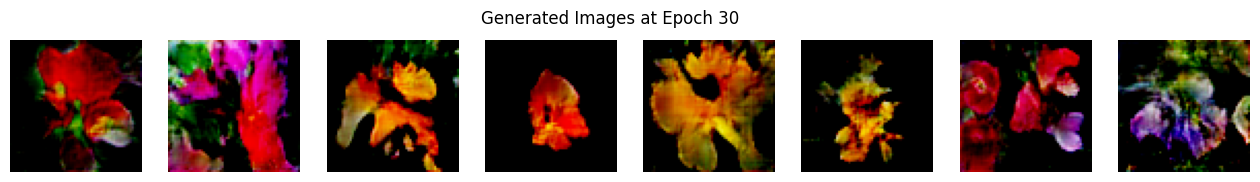

Epochs:  12%|█▏        | 31/250 [11:52<1:24:54, 23.26s/it]

Epoch [31/250] Step [0] Discriminator Loss: 0.8002462983131409 Generator Loss: 0.6604644060134888
Epoch [31/250] Step [600] Discriminator Loss: 0.769653856754303 Generator Loss: 0.6282315254211426
Epoch [31/250] Step [1200] Discriminator Loss: 0.8549482226371765 Generator Loss: 0.6092827320098877
Epoch [31/250] Step [1800] Discriminator Loss: 0.8007834851741791 Generator Loss: 0.5442827939987183
Epoch [31/250] Step [2400] Discriminator Loss: 0.7769568264484406 Generator Loss: 0.5666743516921997
Epoch [31/250] Step [3000] Discriminator Loss: 0.8006749153137207 Generator Loss: 0.6142086982727051
Epoch [31/250] Step [3600] Discriminator Loss: 0.8140801787376404 Generator Loss: 0.6543040871620178
Epoch [31/250] Step [4200] Discriminator Loss: 0.9072670042514801 Generator Loss: 0.6090487837791443
Epoch [31/250] Step [4800] Discriminator Loss: 0.881010890007019 Generator Loss: 0.549210786819458
Epoch [31/250] Step [5400] Discriminator Loss: 0.9419606029987335 Generator Loss: 0.62665516138076

Epochs:  13%|█▎        | 32/250 [12:15<1:24:21, 23.22s/it]

Epoch [32/250] Step [0] Discriminator Loss: 0.7536341547966003 Generator Loss: 0.6164497137069702
Epoch [32/250] Step [600] Discriminator Loss: 0.7657985091209412 Generator Loss: 0.6669471263885498
Epoch [32/250] Step [1200] Discriminator Loss: 0.8152986764907837 Generator Loss: 0.7065405249595642
Epoch [32/250] Step [1800] Discriminator Loss: 0.7436989545822144 Generator Loss: 0.5558786392211914
Epoch [32/250] Step [2400] Discriminator Loss: 0.7938234210014343 Generator Loss: 0.6691799163818359
Epoch [32/250] Step [3000] Discriminator Loss: 0.7558230757713318 Generator Loss: 0.5974069237709045
Epoch [32/250] Step [3600] Discriminator Loss: 0.7754435539245605 Generator Loss: 0.5675784945487976
Epoch [32/250] Step [4200] Discriminator Loss: 0.7831440567970276 Generator Loss: 0.5425101518630981
Epoch [32/250] Step [4800] Discriminator Loss: 0.8343693614006042 Generator Loss: 0.5759817361831665
Epoch [32/250] Step [5400] Discriminator Loss: 0.819034069776535 Generator Loss: 0.491918593645

Epochs:  13%|█▎        | 33/250 [12:38<1:23:51, 23.19s/it]

Epoch [33/250] Step [0] Discriminator Loss: 0.7410769760608673 Generator Loss: 0.5600252747535706
Epoch [33/250] Step [600] Discriminator Loss: 0.7859721183776855 Generator Loss: 0.7029097080230713
Epoch [33/250] Step [1200] Discriminator Loss: 0.7317072451114655 Generator Loss: 0.6301298141479492
Epoch [33/250] Step [1800] Discriminator Loss: 0.7773551046848297 Generator Loss: 0.607029139995575
Epoch [33/250] Step [2400] Discriminator Loss: 0.7981017231941223 Generator Loss: 0.5503877997398376
Epoch [33/250] Step [3000] Discriminator Loss: 0.7655603587627411 Generator Loss: 0.5759361386299133
Epoch [33/250] Step [3600] Discriminator Loss: 0.808184802532196 Generator Loss: 0.6712211966514587
Epoch [33/250] Step [4200] Discriminator Loss: 0.7386537790298462 Generator Loss: 0.60630863904953
Epoch [33/250] Step [4800] Discriminator Loss: 0.7573341727256775 Generator Loss: 0.5720686912536621
Epoch [33/250] Step [5400] Discriminator Loss: 0.8541349768638611 Generator Loss: 0.659800112247467

Epochs:  14%|█▎        | 34/250 [13:01<1:23:19, 23.15s/it]

Epoch [34/250] Step [0] Discriminator Loss: 0.7979737818241119 Generator Loss: 0.6155479550361633
Epoch [34/250] Step [600] Discriminator Loss: 0.7760278284549713 Generator Loss: 0.535352885723114
Epoch [34/250] Step [1200] Discriminator Loss: 0.7303922474384308 Generator Loss: 0.6141210794448853
Epoch [34/250] Step [1800] Discriminator Loss: 0.778670072555542 Generator Loss: 0.5086811780929565
Epoch [34/250] Step [2400] Discriminator Loss: 0.7795923054218292 Generator Loss: 0.5283204317092896
Epoch [34/250] Step [3000] Discriminator Loss: 0.7428659796714783 Generator Loss: 0.5951516032218933
Epoch [34/250] Step [3600] Discriminator Loss: 0.8169135451316833 Generator Loss: 0.6605860590934753
Epoch [34/250] Step [4200] Discriminator Loss: 0.7425453960895538 Generator Loss: 0.50679612159729
Epoch [34/250] Step [4800] Discriminator Loss: 0.7725167870521545 Generator Loss: 0.6501769423484802
Epoch [34/250] Step [5400] Discriminator Loss: 0.7811213135719299 Generator Loss: 0.651977479457855

Epochs:  14%|█▍        | 35/250 [13:24<1:22:48, 23.11s/it]

Epoch [35/250] Step [0] Discriminator Loss: 0.8486146330833435 Generator Loss: 0.6130361557006836
Epoch [35/250] Step [600] Discriminator Loss: 0.8196434080600739 Generator Loss: 0.4721207022666931
Epoch [35/250] Step [1200] Discriminator Loss: 0.8201820552349091 Generator Loss: 0.5472639799118042
Epoch [35/250] Step [1800] Discriminator Loss: 0.7932374477386475 Generator Loss: 0.6539590358734131
Epoch [35/250] Step [2400] Discriminator Loss: 0.7715193629264832 Generator Loss: 0.6215718388557434
Epoch [35/250] Step [3000] Discriminator Loss: 0.7616079151630402 Generator Loss: 0.6229341626167297
Epoch [35/250] Step [3600] Discriminator Loss: 0.7818567156791687 Generator Loss: 0.5417231917381287
Epoch [35/250] Step [4200] Discriminator Loss: 0.8728868365287781 Generator Loss: 0.6093321442604065
Epoch [35/250] Step [4800] Discriminator Loss: 0.7196451425552368 Generator Loss: 0.5764657258987427
Epoch [35/250] Step [5400] Discriminator Loss: 0.7577422261238098 Generator Loss: 0.53198689222

Epochs:  14%|█▍        | 36/250 [13:47<1:22:17, 23.07s/it]

Epoch [36/250] Step [0] Discriminator Loss: 0.7389542460441589 Generator Loss: 0.5407527089118958
Epoch [36/250] Step [600] Discriminator Loss: 0.8496866226196289 Generator Loss: 0.6054822206497192
Epoch [36/250] Step [1200] Discriminator Loss: 0.7483919858932495 Generator Loss: 0.6499291062355042
Epoch [36/250] Step [1800] Discriminator Loss: 0.737060010433197 Generator Loss: 0.6427689790725708
Epoch [36/250] Step [2400] Discriminator Loss: 0.7701586782932281 Generator Loss: 0.621012806892395
Epoch [36/250] Step [3000] Discriminator Loss: 0.8076871633529663 Generator Loss: 0.6051225066184998
Epoch [36/250] Step [3600] Discriminator Loss: 0.7227318286895752 Generator Loss: 0.5944501757621765
Epoch [36/250] Step [4200] Discriminator Loss: 0.7601664960384369 Generator Loss: 0.5864264369010925
Epoch [36/250] Step [4800] Discriminator Loss: 0.7158762216567993 Generator Loss: 0.6384722590446472
Epoch [36/250] Step [5400] Discriminator Loss: 0.8201630115509033 Generator Loss: 0.5923711061477

Epochs:  15%|█▍        | 37/250 [14:10<1:21:51, 23.06s/it]

Epoch [37/250] Step [0] Discriminator Loss: 0.8710729479789734 Generator Loss: 0.48645591735839844
Epoch [37/250] Step [600] Discriminator Loss: 0.763498067855835 Generator Loss: 0.7377315759658813
Epoch [37/250] Step [1200] Discriminator Loss: 0.7521494328975677 Generator Loss: 0.6348000764846802
Epoch [37/250] Step [1800] Discriminator Loss: 0.7047359347343445 Generator Loss: 0.618560791015625
Epoch [37/250] Step [2400] Discriminator Loss: 0.7710728347301483 Generator Loss: 0.6704703569412231
Epoch [37/250] Step [3000] Discriminator Loss: 0.7912120521068573 Generator Loss: 0.629630446434021
Epoch [37/250] Step [3600] Discriminator Loss: 0.764311671257019 Generator Loss: 0.5944439172744751
Epoch [37/250] Step [4200] Discriminator Loss: 0.7433155477046967 Generator Loss: 0.5459043979644775
Epoch [37/250] Step [4800] Discriminator Loss: 0.885560929775238 Generator Loss: 0.6568135619163513
Epoch [37/250] Step [5400] Discriminator Loss: 0.7729457914829254 Generator Loss: 0.569429576396942

Epochs:  15%|█▌        | 38/250 [14:33<1:21:28, 23.06s/it]

Epoch [38/250] Step [0] Discriminator Loss: 0.7233231961727142 Generator Loss: 0.6275748610496521
Epoch [38/250] Step [600] Discriminator Loss: 0.8255581259727478 Generator Loss: 0.6388248205184937
Epoch [38/250] Step [1200] Discriminator Loss: 0.7291131913661957 Generator Loss: 0.554165780544281
Epoch [38/250] Step [1800] Discriminator Loss: 0.8002029061317444 Generator Loss: 0.5659268498420715
Epoch [38/250] Step [2400] Discriminator Loss: 0.7864921391010284 Generator Loss: 0.623703122138977
Epoch [38/250] Step [3000] Discriminator Loss: 0.7309758365154266 Generator Loss: 0.5840944647789001
Epoch [38/250] Step [3600] Discriminator Loss: 0.7510682940483093 Generator Loss: 0.6757950186729431
Epoch [38/250] Step [4200] Discriminator Loss: 0.7783753573894501 Generator Loss: 0.5960999131202698
Epoch [38/250] Step [4800] Discriminator Loss: 0.699519157409668 Generator Loss: 0.5618016123771667
Epoch [38/250] Step [5400] Discriminator Loss: 0.7397372126579285 Generator Loss: 0.58895784616470

Epochs:  16%|█▌        | 39/250 [14:56<1:21:07, 23.07s/it]

Epoch [39/250] Step [0] Discriminator Loss: 0.8011889755725861 Generator Loss: 0.6151531338691711
Epoch [39/250] Step [600] Discriminator Loss: 0.7458013892173767 Generator Loss: 0.6813110709190369
Epoch [39/250] Step [1200] Discriminator Loss: 0.7246157228946686 Generator Loss: 0.4283920228481293
Epoch [39/250] Step [1800] Discriminator Loss: 0.7628723382949829 Generator Loss: 0.6378432512283325
Epoch [39/250] Step [2400] Discriminator Loss: 0.7592043876647949 Generator Loss: 0.5261952877044678
Epoch [39/250] Step [3000] Discriminator Loss: 0.8257805407047272 Generator Loss: 0.4283248484134674
Epoch [39/250] Step [3600] Discriminator Loss: 0.7302005589008331 Generator Loss: 0.6062911748886108
Epoch [39/250] Step [4200] Discriminator Loss: 0.785347193479538 Generator Loss: 0.6320022940635681
Epoch [39/250] Step [4800] Discriminator Loss: 0.7572582960128784 Generator Loss: 0.5518595576286316
Epoch [39/250] Step [5400] Discriminator Loss: 0.796764075756073 Generator Loss: 0.6852150559425

Epochs:  16%|█▌        | 40/250 [15:19<1:20:45, 23.07s/it]

Epoch [40/250] Step [0] Discriminator Loss: 0.7664778530597687 Generator Loss: 0.6310256123542786
Epoch [40/250] Step [600] Discriminator Loss: 0.7088111340999603 Generator Loss: 0.683948814868927
Epoch [40/250] Step [1200] Discriminator Loss: 0.7276025414466858 Generator Loss: 0.6342604756355286
Epoch [40/250] Step [1800] Discriminator Loss: 0.7090434730052948 Generator Loss: 0.5606081485748291
Epoch [40/250] Step [2400] Discriminator Loss: 0.7415838837623596 Generator Loss: 0.5972967743873596
Epoch [40/250] Step [3000] Discriminator Loss: 0.7708021998405457 Generator Loss: 0.6269056797027588
Epoch [40/250] Step [3600] Discriminator Loss: 0.7382805347442627 Generator Loss: 0.5219285488128662
Epoch [40/250] Step [4200] Discriminator Loss: 0.7556630373001099 Generator Loss: 0.5726114511489868
Epoch [40/250] Step [4800] Discriminator Loss: 0.7471421360969543 Generator Loss: 0.5262278318405151
Epoch [40/250] Step [5400] Discriminator Loss: 0.7707897126674652 Generator Loss: 0.635184407234

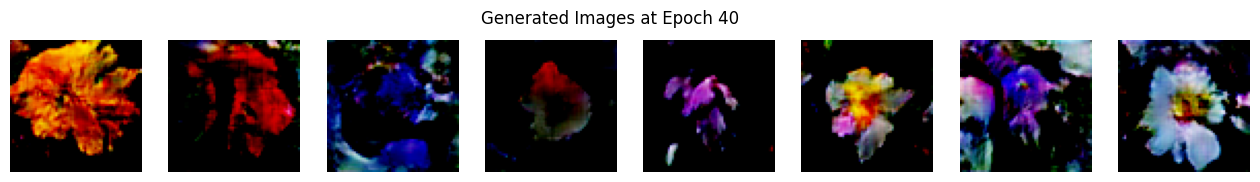

Epochs:  16%|█▋        | 41/250 [15:43<1:21:14, 23.32s/it]

Epoch [41/250] Step [0] Discriminator Loss: 0.7769201397895813 Generator Loss: 0.5843756794929504
Epoch [41/250] Step [600] Discriminator Loss: 0.7323519289493561 Generator Loss: 0.5653083920478821
Epoch [41/250] Step [1200] Discriminator Loss: 0.7155516445636749 Generator Loss: 0.6222496032714844
Epoch [41/250] Step [1800] Discriminator Loss: 0.7858292162418365 Generator Loss: 0.6815303564071655
Epoch [41/250] Step [2400] Discriminator Loss: 0.7125968635082245 Generator Loss: 0.6419760584831238
Epoch [41/250] Step [3000] Discriminator Loss: 0.7682367563247681 Generator Loss: 0.622614324092865
Epoch [41/250] Step [3600] Discriminator Loss: 0.7450995445251465 Generator Loss: 0.5347979664802551
Epoch [41/250] Step [4200] Discriminator Loss: 0.7548696994781494 Generator Loss: 0.6230903267860413
Epoch [41/250] Step [4800] Discriminator Loss: 0.7578192353248596 Generator Loss: 0.6090986132621765
Epoch [41/250] Step [5400] Discriminator Loss: 0.819554477930069 Generator Loss: 0.5991201400756

Epochs:  17%|█▋        | 42/250 [16:06<1:20:37, 23.26s/it]

Epoch [42/250] Step [0] Discriminator Loss: 0.7850118577480316 Generator Loss: 0.5567368268966675
Epoch [42/250] Step [600] Discriminator Loss: 0.7761419713497162 Generator Loss: 0.6013414263725281
Epoch [42/250] Step [1200] Discriminator Loss: 0.7863741219043732 Generator Loss: 0.5482469797134399
Epoch [42/250] Step [1800] Discriminator Loss: 0.8171468675136566 Generator Loss: 0.6325557827949524
Epoch [42/250] Step [2400] Discriminator Loss: 0.7277279496192932 Generator Loss: 0.6410114765167236
Epoch [42/250] Step [3000] Discriminator Loss: 0.7823939323425293 Generator Loss: 0.6547613143920898
Epoch [42/250] Step [3600] Discriminator Loss: 0.8094636797904968 Generator Loss: 0.5973414778709412
Epoch [42/250] Step [4200] Discriminator Loss: 0.761744886636734 Generator Loss: 0.6389674544334412
Epoch [42/250] Step [4800] Discriminator Loss: 0.7187218368053436 Generator Loss: 0.6381940245628357
Epoch [42/250] Step [5400] Discriminator Loss: 0.7286071181297302 Generator Loss: 0.653661251068

Epochs:  17%|█▋        | 43/250 [16:29<1:20:07, 23.23s/it]

Epoch [43/250] Step [0] Discriminator Loss: 0.7009402215480804 Generator Loss: 0.6147738099098206
Epoch [43/250] Step [600] Discriminator Loss: 0.7241739928722382 Generator Loss: 0.6194154024124146
Epoch [43/250] Step [1200] Discriminator Loss: 0.8134523034095764 Generator Loss: 0.5874643921852112
Epoch [43/250] Step [1800] Discriminator Loss: 0.724775493144989 Generator Loss: 0.5937418937683105
Epoch [43/250] Step [2400] Discriminator Loss: 0.7611211836338043 Generator Loss: 0.6469088196754456
Epoch [43/250] Step [3000] Discriminator Loss: 0.7579091489315033 Generator Loss: 0.607826828956604
Epoch [43/250] Step [3600] Discriminator Loss: 0.7640054523944855 Generator Loss: 0.6120826005935669
Epoch [43/250] Step [4200] Discriminator Loss: 0.7161911725997925 Generator Loss: 0.5913933515548706
Epoch [43/250] Step [4800] Discriminator Loss: 0.7672370374202728 Generator Loss: 0.5221045017242432
Epoch [43/250] Step [5400] Discriminator Loss: 0.7544154524803162 Generator Loss: 0.6169689297676

Epochs:  18%|█▊        | 44/250 [16:53<1:19:41, 23.21s/it]

Epoch [44/250] Step [0] Discriminator Loss: 0.743567019701004 Generator Loss: 0.6431266665458679
Epoch [44/250] Step [600] Discriminator Loss: 0.7266132831573486 Generator Loss: 0.6070420742034912
Epoch [44/250] Step [1200] Discriminator Loss: 0.8689954280853271 Generator Loss: 0.6694623231887817
Epoch [44/250] Step [1800] Discriminator Loss: 0.7528997957706451 Generator Loss: 0.6512789130210876
Epoch [44/250] Step [2400] Discriminator Loss: 0.7236908078193665 Generator Loss: 0.6931130290031433
Epoch [44/250] Step [3000] Discriminator Loss: 0.7554044127464294 Generator Loss: 0.5132108926773071
Epoch [44/250] Step [3600] Discriminator Loss: 0.7199874818325043 Generator Loss: 0.6451618671417236
Epoch [44/250] Step [4200] Discriminator Loss: 0.7593149542808533 Generator Loss: 0.602318525314331
Epoch [44/250] Step [4800] Discriminator Loss: 0.7139664590358734 Generator Loss: 0.5374137163162231
Epoch [44/250] Step [5400] Discriminator Loss: 0.7151332199573517 Generator Loss: 0.5631442070007

Epochs:  18%|█▊        | 45/250 [17:16<1:19:16, 23.20s/it]

Epoch [45/250] Step [0] Discriminator Loss: 0.8237524330615997 Generator Loss: 0.6117598414421082
Epoch [45/250] Step [600] Discriminator Loss: 0.8959804773330688 Generator Loss: 0.6709879040718079
Epoch [45/250] Step [1200] Discriminator Loss: 0.7645182013511658 Generator Loss: 0.5878015756607056
Epoch [45/250] Step [1800] Discriminator Loss: 0.8339945375919342 Generator Loss: 0.7008292078971863
Epoch [45/250] Step [2400] Discriminator Loss: 0.7787028551101685 Generator Loss: 0.5877835750579834
Epoch [45/250] Step [3000] Discriminator Loss: 0.7021871209144592 Generator Loss: 0.6090272665023804
Epoch [45/250] Step [3600] Discriminator Loss: 0.727880597114563 Generator Loss: 0.6571699976921082
Epoch [45/250] Step [4200] Discriminator Loss: 0.8205914795398712 Generator Loss: 0.6121772527694702
Epoch [45/250] Step [4800] Discriminator Loss: 0.7413690686225891 Generator Loss: 0.5796487927436829
Epoch [45/250] Step [5400] Discriminator Loss: 0.7893117666244507 Generator Loss: 0.665152668952

Epochs:  18%|█▊        | 46/250 [17:39<1:18:48, 23.18s/it]

Epoch [46/250] Step [0] Discriminator Loss: 0.7212976813316345 Generator Loss: 0.6708716750144958
Epoch [46/250] Step [600] Discriminator Loss: 0.7383369505405426 Generator Loss: 0.5891766548156738
Epoch [46/250] Step [1200] Discriminator Loss: 0.7849353849887848 Generator Loss: 0.46757543087005615
Epoch [46/250] Step [1800] Discriminator Loss: 0.7154041528701782 Generator Loss: 0.6458292007446289
Epoch [46/250] Step [2400] Discriminator Loss: 0.7218250930309296 Generator Loss: 0.6402390599250793
Epoch [46/250] Step [3000] Discriminator Loss: 0.7547945380210876 Generator Loss: 0.6379660367965698
Epoch [46/250] Step [3600] Discriminator Loss: 0.7658476233482361 Generator Loss: 0.623535692691803
Epoch [46/250] Step [4200] Discriminator Loss: 0.7407011389732361 Generator Loss: 0.5729888677597046
Epoch [46/250] Step [4800] Discriminator Loss: 0.8215286731719971 Generator Loss: 0.47696805000305176
Epoch [46/250] Step [5400] Discriminator Loss: 0.7149528563022614 Generator Loss: 0.5846742987

Epochs:  19%|█▉        | 47/250 [18:02<1:18:22, 23.17s/it]

Epoch [47/250] Step [0] Discriminator Loss: 0.7836159467697144 Generator Loss: 0.6759080290794373
Epoch [47/250] Step [600] Discriminator Loss: 0.7793847024440765 Generator Loss: 0.6464778184890747
Epoch [47/250] Step [1200] Discriminator Loss: 0.7189191281795502 Generator Loss: 0.6108077168464661
Epoch [47/250] Step [1800] Discriminator Loss: 0.7651478052139282 Generator Loss: 0.5784304738044739
Epoch [47/250] Step [2400] Discriminator Loss: 0.7380266785621643 Generator Loss: 0.6612184047698975
Epoch [47/250] Step [3000] Discriminator Loss: 0.7281079590320587 Generator Loss: 0.6585392951965332
Epoch [47/250] Step [3600] Discriminator Loss: 0.7995341122150421 Generator Loss: 0.5432223677635193
Epoch [47/250] Step [4200] Discriminator Loss: 0.7735218107700348 Generator Loss: 0.6303974986076355
Epoch [47/250] Step [4800] Discriminator Loss: 0.7250724732875824 Generator Loss: 0.6803754568099976
Epoch [47/250] Step [5400] Discriminator Loss: 0.784763753414154 Generator Loss: 0.672188162803

Epochs:  19%|█▉        | 48/250 [18:25<1:17:56, 23.15s/it]

Epoch [48/250] Step [0] Discriminator Loss: 0.7307476103305817 Generator Loss: 0.5613694190979004
Epoch [48/250] Step [600] Discriminator Loss: 0.7157241106033325 Generator Loss: 0.5748287439346313
Epoch [48/250] Step [1200] Discriminator Loss: 0.7450117766857147 Generator Loss: 0.6708388924598694
Epoch [48/250] Step [1800] Discriminator Loss: 0.744201123714447 Generator Loss: 0.6329246163368225
Epoch [48/250] Step [2400] Discriminator Loss: 0.7234420776367188 Generator Loss: 0.6118404865264893
Epoch [48/250] Step [3000] Discriminator Loss: 0.7240906357765198 Generator Loss: 0.6161828637123108
Epoch [48/250] Step [3600] Discriminator Loss: 0.7160219252109528 Generator Loss: 0.5457533597946167
Epoch [48/250] Step [4200] Discriminator Loss: 0.7083888649940491 Generator Loss: 0.6771899461746216
Epoch [48/250] Step [4800] Discriminator Loss: 0.7687456905841827 Generator Loss: 0.6701343655586243
Epoch [48/250] Step [5400] Discriminator Loss: 0.7526085376739502 Generator Loss: 0.610515892505

Epochs:  20%|█▉        | 49/250 [18:48<1:17:32, 23.15s/it]

Epoch [49/250] Step [0] Discriminator Loss: 0.7725938856601715 Generator Loss: 0.5509217381477356
Epoch [49/250] Step [600] Discriminator Loss: 0.7061173021793365 Generator Loss: 0.6001862287521362
Epoch [49/250] Step [1200] Discriminator Loss: 0.7389941215515137 Generator Loss: 0.6005123853683472
Epoch [49/250] Step [1800] Discriminator Loss: 0.7409548163414001 Generator Loss: 0.5285497307777405
Epoch [49/250] Step [2400] Discriminator Loss: 0.7519062757492065 Generator Loss: 0.6630315184593201
Epoch [49/250] Step [3000] Discriminator Loss: 0.7218134999275208 Generator Loss: 0.6483502984046936
Epoch [49/250] Step [3600] Discriminator Loss: 0.7276460528373718 Generator Loss: 0.6061373353004456
Epoch [49/250] Step [4200] Discriminator Loss: 0.72620889544487 Generator Loss: 0.6071279048919678
Epoch [49/250] Step [4800] Discriminator Loss: 0.7289121150970459 Generator Loss: 0.6021652817726135
Epoch [49/250] Step [5400] Discriminator Loss: 0.7267072200775146 Generator Loss: 0.5459805727005

Epochs:  20%|██        | 50/250 [19:11<1:17:10, 23.15s/it]

Epoch [50/250] Step [0] Discriminator Loss: 0.7180928587913513 Generator Loss: 0.6239063739776611
Epoch [50/250] Step [600] Discriminator Loss: 0.7526092529296875 Generator Loss: 0.6668774485588074
Epoch [50/250] Step [1200] Discriminator Loss: 0.7409709692001343 Generator Loss: 0.64671391248703
Epoch [50/250] Step [1800] Discriminator Loss: 0.8422324061393738 Generator Loss: 0.5753433108329773
Epoch [50/250] Step [2400] Discriminator Loss: 0.7906834185123444 Generator Loss: 0.6640384793281555
Epoch [50/250] Step [3000] Discriminator Loss: 0.7443957030773163 Generator Loss: 0.6238524913787842
Epoch [50/250] Step [3600] Discriminator Loss: 0.7384923696517944 Generator Loss: 0.5547383427619934
Epoch [50/250] Step [4200] Discriminator Loss: 0.7655728757381439 Generator Loss: 0.6100201606750488
Epoch [50/250] Step [4800] Discriminator Loss: 0.7207309305667877 Generator Loss: 0.6177214980125427
Epoch [50/250] Step [5400] Discriminator Loss: 0.7531098127365112 Generator Loss: 0.5796536207199

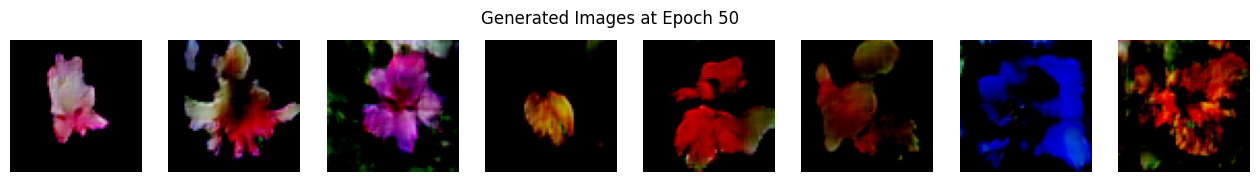

Epochs:  20%|██        | 51/250 [19:35<1:17:13, 23.28s/it]

Epoch [51/250] Step [0] Discriminator Loss: 0.7149370908737183 Generator Loss: 0.6800565123558044
Epoch [51/250] Step [600] Discriminator Loss: 0.704135000705719 Generator Loss: 0.5224863290786743
Epoch [51/250] Step [1200] Discriminator Loss: 0.7342507839202881 Generator Loss: 0.6119320392608643
Epoch [51/250] Step [1800] Discriminator Loss: 0.7656123042106628 Generator Loss: 0.6682902574539185
Epoch [51/250] Step [2400] Discriminator Loss: 0.7609038949012756 Generator Loss: 0.6668186783790588
Epoch [51/250] Step [3000] Discriminator Loss: 0.7367738485336304 Generator Loss: 0.5192086100578308
Epoch [51/250] Step [3600] Discriminator Loss: 0.7913455069065094 Generator Loss: 0.5511114597320557
Epoch [51/250] Step [4200] Discriminator Loss: 0.7657653093338013 Generator Loss: 0.6148962378501892
Epoch [51/250] Step [4800] Discriminator Loss: 0.7492497563362122 Generator Loss: 0.5794084668159485
Epoch [51/250] Step [5400] Discriminator Loss: 0.7284421622753143 Generator Loss: 0.576212882995

Epochs:  21%|██        | 52/250 [19:58<1:16:39, 23.23s/it]

Epoch [52/250] Step [0] Discriminator Loss: 0.7357783615589142 Generator Loss: 0.6988072395324707
Epoch [52/250] Step [600] Discriminator Loss: 0.7326524257659912 Generator Loss: 0.6030985116958618
Epoch [52/250] Step [1200] Discriminator Loss: 0.7515476644039154 Generator Loss: 0.49590593576431274
Epoch [52/250] Step [1800] Discriminator Loss: 0.7287678420543671 Generator Loss: 0.6102368831634521
Epoch [52/250] Step [2400] Discriminator Loss: 0.7379324734210968 Generator Loss: 0.5803868770599365
Epoch [52/250] Step [3000] Discriminator Loss: 0.8076792657375336 Generator Loss: 0.5877845883369446
Epoch [52/250] Step [3600] Discriminator Loss: 0.7372745871543884 Generator Loss: 0.7157639265060425
Epoch [52/250] Step [4200] Discriminator Loss: 0.7965746521949768 Generator Loss: 0.6249576210975647
Epoch [52/250] Step [4800] Discriminator Loss: 0.77541583776474 Generator Loss: 0.6522693634033203
Epoch [52/250] Step [5400] Discriminator Loss: 0.7293705344200134 Generator Loss: 0.618637561798

Epochs:  21%|██        | 53/250 [20:21<1:16:08, 23.19s/it]

Epoch [53/250] Step [0] Discriminator Loss: 0.7455263435840607 Generator Loss: 0.6610977649688721
Epoch [53/250] Step [600] Discriminator Loss: 0.7425491511821747 Generator Loss: 0.6350568532943726
Epoch [53/250] Step [1200] Discriminator Loss: 0.7210365831851959 Generator Loss: 0.6493585705757141
Epoch [53/250] Step [1800] Discriminator Loss: 0.7359501123428345 Generator Loss: 0.6686683893203735
Epoch [53/250] Step [2400] Discriminator Loss: 0.7467131912708282 Generator Loss: 0.5823814272880554
Epoch [53/250] Step [3000] Discriminator Loss: 0.7238957285881042 Generator Loss: 0.6698133945465088
Epoch [53/250] Step [3600] Discriminator Loss: 0.7266691327095032 Generator Loss: 0.644085168838501
Epoch [53/250] Step [4200] Discriminator Loss: 0.7916768193244934 Generator Loss: 0.5263378620147705
Epoch [53/250] Step [4800] Discriminator Loss: 0.7053021192550659 Generator Loss: 0.6437726616859436
Epoch [53/250] Step [5400] Discriminator Loss: 0.7318051159381866 Generator Loss: 0.574907720088

Epochs:  22%|██▏       | 54/250 [20:44<1:15:40, 23.17s/it]

Epoch [54/250] Step [0] Discriminator Loss: 0.720778077840805 Generator Loss: 0.6113244295120239
Epoch [54/250] Step [600] Discriminator Loss: 0.7583507895469666 Generator Loss: 0.6291654706001282
Epoch [54/250] Step [1200] Discriminator Loss: 0.7330769598484039 Generator Loss: 0.6936428546905518
Epoch [54/250] Step [1800] Discriminator Loss: 0.7788847386837006 Generator Loss: 0.6544151902198792
Epoch [54/250] Step [2400] Discriminator Loss: 0.736486166715622 Generator Loss: 0.6443835496902466
Epoch [54/250] Step [3000] Discriminator Loss: 0.7059578001499176 Generator Loss: 0.6264588236808777
Epoch [54/250] Step [3600] Discriminator Loss: 0.7469375431537628 Generator Loss: 0.5627797842025757
Epoch [54/250] Step [4200] Discriminator Loss: 0.7349526286125183 Generator Loss: 0.6325902938842773
Epoch [54/250] Step [4800] Discriminator Loss: 0.7601740956306458 Generator Loss: 0.6656933426856995
Epoch [54/250] Step [5400] Discriminator Loss: 0.7454409003257751 Generator Loss: 0.6637791991233

Epochs:  22%|██▏       | 55/250 [21:07<1:15:13, 23.15s/it]

Epoch [55/250] Step [0] Discriminator Loss: 0.7649655044078827 Generator Loss: 0.6370386481285095
Epoch [55/250] Step [600] Discriminator Loss: 0.720445305109024 Generator Loss: 0.5697575807571411
Epoch [55/250] Step [1200] Discriminator Loss: 0.7449020743370056 Generator Loss: 0.6180325150489807
Epoch [55/250] Step [1800] Discriminator Loss: 0.7265211939811707 Generator Loss: 0.6030000448226929
Epoch [55/250] Step [2400] Discriminator Loss: 0.6966437697410583 Generator Loss: 0.6496481895446777
Epoch [55/250] Step [3000] Discriminator Loss: 0.7394266426563263 Generator Loss: 0.5844368934631348
Epoch [55/250] Step [3600] Discriminator Loss: 0.7471891343593597 Generator Loss: 0.5847638249397278
Epoch [55/250] Step [4200] Discriminator Loss: 0.6983286738395691 Generator Loss: 0.5994096398353577
Epoch [55/250] Step [4800] Discriminator Loss: 0.7039999663829803 Generator Loss: 0.5355743765830994
Epoch [55/250] Step [5400] Discriminator Loss: 0.7349529266357422 Generator Loss: 0.611757159233

Epochs:  22%|██▏       | 56/250 [21:30<1:14:47, 23.13s/it]

Epoch [56/250] Step [0] Discriminator Loss: 0.7112781405448914 Generator Loss: 0.5562127828598022
Epoch [56/250] Step [600] Discriminator Loss: 0.7573547959327698 Generator Loss: 0.5982646346092224
Epoch [56/250] Step [1200] Discriminator Loss: 0.7420979738235474 Generator Loss: 0.6578076481819153
Epoch [56/250] Step [1800] Discriminator Loss: 0.7622177004814148 Generator Loss: 0.6972261071205139
Epoch [56/250] Step [2400] Discriminator Loss: 0.7101474404335022 Generator Loss: 0.6671870946884155
Epoch [56/250] Step [3000] Discriminator Loss: 0.7765144109725952 Generator Loss: 0.6295130848884583
Epoch [56/250] Step [3600] Discriminator Loss: 0.7206345498561859 Generator Loss: 0.6066967844963074
Epoch [56/250] Step [4200] Discriminator Loss: 0.7300983965396881 Generator Loss: 0.6250056624412537
Epoch [56/250] Step [4800] Discriminator Loss: 0.7131982147693634 Generator Loss: 0.6385701298713684
Epoch [56/250] Step [5400] Discriminator Loss: 0.740627110004425 Generator Loss: 0.635905027389

Epochs:  23%|██▎       | 57/250 [21:54<1:14:25, 23.14s/it]

Epoch [57/250] Step [0] Discriminator Loss: 0.7465251684188843 Generator Loss: 0.6152563691139221
Epoch [57/250] Step [600] Discriminator Loss: 0.7192170023918152 Generator Loss: 0.6557680368423462
Epoch [57/250] Step [1200] Discriminator Loss: 0.7683154344558716 Generator Loss: 0.5672703981399536
Epoch [57/250] Step [1800] Discriminator Loss: 0.7644518315792084 Generator Loss: 0.5905972123146057
Epoch [57/250] Step [2400] Discriminator Loss: 0.7539776265621185 Generator Loss: 0.6303178071975708
Epoch [57/250] Step [3000] Discriminator Loss: 0.7203157246112823 Generator Loss: 0.6610610485076904
Epoch [57/250] Step [3600] Discriminator Loss: 0.6997967958450317 Generator Loss: 0.6461554765701294
Epoch [57/250] Step [4200] Discriminator Loss: 0.7372491955757141 Generator Loss: 0.6492509245872498
Epoch [57/250] Step [4800] Discriminator Loss: 0.7264055609703064 Generator Loss: 0.5871748924255371
Epoch [57/250] Step [5400] Discriminator Loss: 0.732977569103241 Generator Loss: 0.549339294433

Epochs:  23%|██▎       | 58/250 [22:17<1:14:00, 23.13s/it]

Epoch [58/250] Step [0] Discriminator Loss: 0.7168883979320526 Generator Loss: 0.6237989068031311
Epoch [58/250] Step [600] Discriminator Loss: 0.7254719138145447 Generator Loss: 0.6375580430030823
Epoch [58/250] Step [1200] Discriminator Loss: 0.7175092697143555 Generator Loss: 0.6316998600959778
Epoch [58/250] Step [1800] Discriminator Loss: 0.7217409014701843 Generator Loss: 0.6482067108154297
Epoch [58/250] Step [2400] Discriminator Loss: 0.7440761029720306 Generator Loss: 0.6351431012153625
Epoch [58/250] Step [3000] Discriminator Loss: 0.710200160741806 Generator Loss: 0.5121311545372009
Epoch [58/250] Step [3600] Discriminator Loss: 0.7087572813034058 Generator Loss: 0.6753277778625488
Epoch [58/250] Step [4200] Discriminator Loss: 0.7173043787479401 Generator Loss: 0.5815998315811157
Epoch [58/250] Step [4800] Discriminator Loss: 0.7654384970664978 Generator Loss: 0.6259681582450867
Epoch [58/250] Step [5400] Discriminator Loss: 0.7258003354072571 Generator Loss: 0.604810953140

Epochs:  24%|██▎       | 59/250 [22:40<1:13:36, 23.12s/it]

Epoch [59/250] Step [0] Discriminator Loss: 0.7189726233482361 Generator Loss: 0.608871340751648
Epoch [59/250] Step [600] Discriminator Loss: 0.7272720038890839 Generator Loss: 0.5985198020935059
Epoch [59/250] Step [1200] Discriminator Loss: 0.7135261297225952 Generator Loss: 0.6054431796073914
Epoch [59/250] Step [1800] Discriminator Loss: 0.7603529989719391 Generator Loss: 0.603036105632782
Epoch [59/250] Step [2400] Discriminator Loss: 0.748199999332428 Generator Loss: 0.6295367479324341
Epoch [59/250] Step [3000] Discriminator Loss: 0.7427897453308105 Generator Loss: 0.49825361371040344
Epoch [59/250] Step [3600] Discriminator Loss: 0.7060554623603821 Generator Loss: 0.6546159386634827
Epoch [59/250] Step [4200] Discriminator Loss: 0.70611771941185 Generator Loss: 0.5641234517097473
Epoch [59/250] Step [4800] Discriminator Loss: 0.7789051234722137 Generator Loss: 0.6476751565933228
Epoch [59/250] Step [5400] Discriminator Loss: 0.7261486053466797 Generator Loss: 0.585336029529571

Epochs:  24%|██▍       | 60/250 [23:03<1:13:12, 23.12s/it]

Epoch [60/250] Step [0] Discriminator Loss: 0.6858075857162476 Generator Loss: 0.665051281452179
Epoch [60/250] Step [600] Discriminator Loss: 0.7260863482952118 Generator Loss: 0.6300119757652283
Epoch [60/250] Step [1200] Discriminator Loss: 0.7431968450546265 Generator Loss: 0.5977877378463745
Epoch [60/250] Step [1800] Discriminator Loss: 0.7493775486946106 Generator Loss: 0.6018775701522827
Epoch [60/250] Step [2400] Discriminator Loss: 0.7265599966049194 Generator Loss: 0.5851020812988281
Epoch [60/250] Step [3000] Discriminator Loss: 0.728708952665329 Generator Loss: 0.6001002192497253
Epoch [60/250] Step [3600] Discriminator Loss: 0.7074368298053741 Generator Loss: 0.5949822068214417
Epoch [60/250] Step [4200] Discriminator Loss: 0.710279643535614 Generator Loss: 0.6205334663391113
Epoch [60/250] Step [4800] Discriminator Loss: 0.6946755647659302 Generator Loss: 0.5831648111343384
Epoch [60/250] Step [5400] Discriminator Loss: 0.7076597511768341 Generator Loss: 0.63558065891265

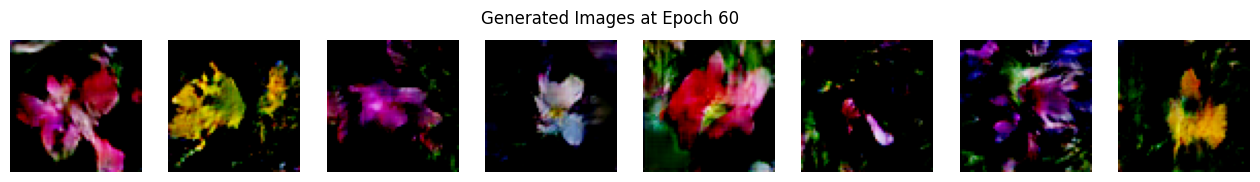

Epochs:  24%|██▍       | 61/250 [23:26<1:13:13, 23.24s/it]

Epoch [61/250] Step [0] Discriminator Loss: 0.712508350610733 Generator Loss: 0.66154944896698
Epoch [61/250] Step [600] Discriminator Loss: 0.7158722877502441 Generator Loss: 0.6179530620574951
Epoch [61/250] Step [1200] Discriminator Loss: 0.6996308267116547 Generator Loss: 0.6587667465209961
Epoch [61/250] Step [1800] Discriminator Loss: 0.7314999401569366 Generator Loss: 0.6146443486213684
Epoch [61/250] Step [2400] Discriminator Loss: 0.7177988886833191 Generator Loss: 0.5527235269546509
Epoch [61/250] Step [3000] Discriminator Loss: 0.7766888439655304 Generator Loss: 0.6066039204597473
Epoch [61/250] Step [3600] Discriminator Loss: 0.7953953146934509 Generator Loss: 0.5159971117973328
Epoch [61/250] Step [4200] Discriminator Loss: 0.7144225239753723 Generator Loss: 0.6115912795066833
Epoch [61/250] Step [4800] Discriminator Loss: 0.7055456936359406 Generator Loss: 0.5414568185806274
Epoch [61/250] Step [5400] Discriminator Loss: 0.7366803586483002 Generator Loss: 0.65346902608871

Epochs:  25%|██▍       | 62/250 [23:50<1:12:41, 23.20s/it]

Epoch [62/250] Step [0] Discriminator Loss: 0.6997989416122437 Generator Loss: 0.6037623882293701
Epoch [62/250] Step [600] Discriminator Loss: 0.7589743435382843 Generator Loss: 0.564616322517395
Epoch [62/250] Step [1200] Discriminator Loss: 0.7038856148719788 Generator Loss: 0.665388286113739
Epoch [62/250] Step [1800] Discriminator Loss: 0.710582971572876 Generator Loss: 0.623936116695404
Epoch [62/250] Step [2400] Discriminator Loss: 0.7256200909614563 Generator Loss: 0.6297435760498047
Epoch [62/250] Step [3000] Discriminator Loss: 0.6939962804317474 Generator Loss: 0.6600143313407898
Epoch [62/250] Step [3600] Discriminator Loss: 0.7159504294395447 Generator Loss: 0.6784613132476807
Epoch [62/250] Step [4200] Discriminator Loss: 0.7286295890808105 Generator Loss: 0.6131194829940796
Epoch [62/250] Step [4800] Discriminator Loss: 0.6902110278606415 Generator Loss: 0.5965816974639893
Epoch [62/250] Step [5400] Discriminator Loss: 0.7386208772659302 Generator Loss: 0.607049942016601

Epochs:  25%|██▌       | 63/250 [24:13<1:12:13, 23.17s/it]

Epoch [63/250] Step [0] Discriminator Loss: 0.7464935183525085 Generator Loss: 0.667344331741333
Epoch [63/250] Step [600] Discriminator Loss: 0.7187348008155823 Generator Loss: 0.6304243206977844
Epoch [63/250] Step [1200] Discriminator Loss: 0.7244804799556732 Generator Loss: 0.5964819192886353
Epoch [63/250] Step [1800] Discriminator Loss: 0.7070382237434387 Generator Loss: 0.5930349230766296
Epoch [63/250] Step [2400] Discriminator Loss: 0.7189512252807617 Generator Loss: 0.6025343537330627
Epoch [63/250] Step [3000] Discriminator Loss: 0.731022447347641 Generator Loss: 0.6812471151351929
Epoch [63/250] Step [3600] Discriminator Loss: 0.7034407258033752 Generator Loss: 0.6467794179916382
Epoch [63/250] Step [4200] Discriminator Loss: 0.6845575273036957 Generator Loss: 0.6510929465293884
Epoch [63/250] Step [4800] Discriminator Loss: 0.7685213983058929 Generator Loss: 0.6664326786994934
Epoch [63/250] Step [5400] Discriminator Loss: 0.7093582451343536 Generator Loss: 0.5519486665725

Epochs:  26%|██▌       | 64/250 [24:36<1:11:46, 23.15s/it]

Epoch [64/250] Step [0] Discriminator Loss: 0.6840132474899292 Generator Loss: 0.6450763940811157
Epoch [64/250] Step [600] Discriminator Loss: 0.7269665002822876 Generator Loss: 0.635189950466156
Epoch [64/250] Step [1200] Discriminator Loss: 0.7181413471698761 Generator Loss: 0.6744876503944397
Epoch [64/250] Step [1800] Discriminator Loss: 0.7055338025093079 Generator Loss: 0.6569178104400635
Epoch [64/250] Step [2400] Discriminator Loss: 0.7046549916267395 Generator Loss: 0.673435628414154
Epoch [64/250] Step [3000] Discriminator Loss: 0.7236459255218506 Generator Loss: 0.619545042514801
Epoch [64/250] Step [3600] Discriminator Loss: 0.69272381067276 Generator Loss: 0.6641967296600342
Epoch [64/250] Step [4200] Discriminator Loss: 0.7176772952079773 Generator Loss: 0.6080811619758606
Epoch [64/250] Step [4800] Discriminator Loss: 0.7248382270336151 Generator Loss: 0.6094939708709717
Epoch [64/250] Step [5400] Discriminator Loss: 0.7108133137226105 Generator Loss: 0.6211667060852051

Epochs:  26%|██▌       | 65/250 [24:59<1:11:21, 23.14s/it]

Epoch [65/250] Step [0] Discriminator Loss: 0.709778755903244 Generator Loss: 0.6108719110488892
Epoch [65/250] Step [600] Discriminator Loss: 0.7317708134651184 Generator Loss: 0.6335448026657104
Epoch [65/250] Step [1200] Discriminator Loss: 0.7134919464588165 Generator Loss: 0.6539422869682312
Epoch [65/250] Step [1800] Discriminator Loss: 0.7321133017539978 Generator Loss: 0.6430130004882812
Epoch [65/250] Step [2400] Discriminator Loss: 0.7102192342281342 Generator Loss: 0.675629198551178
Epoch [65/250] Step [3000] Discriminator Loss: 0.7333455979824066 Generator Loss: 0.6206920146942139
Epoch [65/250] Step [3600] Discriminator Loss: 0.7246063947677612 Generator Loss: 0.6326496005058289
Epoch [65/250] Step [4200] Discriminator Loss: 0.7151764631271362 Generator Loss: 0.5878222584724426
Epoch [65/250] Step [4800] Discriminator Loss: 0.6924834251403809 Generator Loss: 0.6100824475288391
Epoch [65/250] Step [5400] Discriminator Loss: 0.7012296319007874 Generator Loss: 0.5557625889778

Epochs:  26%|██▋       | 66/250 [25:22<1:10:57, 23.14s/it]

Epoch [66/250] Step [0] Discriminator Loss: 0.711227297782898 Generator Loss: 0.5045604109764099
Epoch [66/250] Step [600] Discriminator Loss: 0.7271198630332947 Generator Loss: 0.6583386063575745
Epoch [66/250] Step [1200] Discriminator Loss: 0.7162086963653564 Generator Loss: 0.6222593188285828
Epoch [66/250] Step [1800] Discriminator Loss: 0.7145242691040039 Generator Loss: 0.6133515238761902
Epoch [66/250] Step [2400] Discriminator Loss: 0.7023071646690369 Generator Loss: 0.6158146858215332
Epoch [66/250] Step [3000] Discriminator Loss: 0.6904253363609314 Generator Loss: 0.5379218459129333
Epoch [66/250] Step [3600] Discriminator Loss: 0.7096968293190002 Generator Loss: 0.6094221472740173
Epoch [66/250] Step [4200] Discriminator Loss: 0.7002407014369965 Generator Loss: 0.6356790661811829
Epoch [66/250] Step [4800] Discriminator Loss: 0.6991044878959656 Generator Loss: 0.640151858329773
Epoch [66/250] Step [5400] Discriminator Loss: 0.7179184257984161 Generator Loss: 0.5788269042968

Epochs:  27%|██▋       | 67/250 [25:45<1:10:32, 23.13s/it]

Epoch [67/250] Step [0] Discriminator Loss: 0.7935570776462555 Generator Loss: 0.6361410021781921
Epoch [67/250] Step [600] Discriminator Loss: 0.7077063918113708 Generator Loss: 0.694135308265686
Epoch [67/250] Step [1200] Discriminator Loss: 0.7444145083427429 Generator Loss: 0.586110532283783
Epoch [67/250] Step [1800] Discriminator Loss: 0.7252019047737122 Generator Loss: 0.6576077342033386
Epoch [67/250] Step [2400] Discriminator Loss: 0.7191015779972076 Generator Loss: 0.6515644788742065
Epoch [67/250] Step [3000] Discriminator Loss: 0.7421400547027588 Generator Loss: 0.6552996039390564
Epoch [67/250] Step [3600] Discriminator Loss: 0.7359794974327087 Generator Loss: 0.6385713219642639
Epoch [67/250] Step [4200] Discriminator Loss: 0.718763530254364 Generator Loss: 0.5619004964828491
Epoch [67/250] Step [4800] Discriminator Loss: 0.7388685345649719 Generator Loss: 0.6904802918434143
Epoch [67/250] Step [5400] Discriminator Loss: 0.7181323170661926 Generator Loss: 0.58589833974838

Epochs:  27%|██▋       | 68/250 [26:08<1:10:10, 23.13s/it]

Epoch [68/250] Step [0] Discriminator Loss: 0.712322860956192 Generator Loss: 0.6514905095100403
Epoch [68/250] Step [600] Discriminator Loss: 0.7142747640609741 Generator Loss: 0.6564615964889526
Epoch [68/250] Step [1200] Discriminator Loss: 0.7389060258865356 Generator Loss: 0.6203668713569641
Epoch [68/250] Step [1800] Discriminator Loss: 0.7224965989589691 Generator Loss: 0.604778528213501
Epoch [68/250] Step [2400] Discriminator Loss: 0.6884114146232605 Generator Loss: 0.6032077670097351
Epoch [68/250] Step [3000] Discriminator Loss: 0.7089676260948181 Generator Loss: 0.6385714411735535
Epoch [68/250] Step [3600] Discriminator Loss: 0.713356077671051 Generator Loss: 0.6733993291854858
Epoch [68/250] Step [4200] Discriminator Loss: 0.7125787138938904 Generator Loss: 0.628815770149231
Epoch [68/250] Step [4800] Discriminator Loss: 0.713746190071106 Generator Loss: 0.5824006199836731
Epoch [68/250] Step [5400] Discriminator Loss: 0.74348384141922 Generator Loss: 0.5224596261978149
E

Epochs:  28%|██▊       | 69/250 [26:31<1:09:44, 23.12s/it]

Epoch [69/250] Step [0] Discriminator Loss: 0.7137213349342346 Generator Loss: 0.622542679309845
Epoch [69/250] Step [600] Discriminator Loss: 0.7177318632602692 Generator Loss: 0.6325958371162415
Epoch [69/250] Step [1200] Discriminator Loss: 0.7016161680221558 Generator Loss: 0.6420772671699524
Epoch [69/250] Step [1800] Discriminator Loss: 0.7219762206077576 Generator Loss: 0.6067900657653809
Epoch [69/250] Step [2400] Discriminator Loss: 0.7363796532154083 Generator Loss: 0.5748066902160645
Epoch [69/250] Step [3000] Discriminator Loss: 0.709694117307663 Generator Loss: 0.6645117998123169
Epoch [69/250] Step [3600] Discriminator Loss: 0.7021026909351349 Generator Loss: 0.6375974416732788
Epoch [69/250] Step [4200] Discriminator Loss: 0.7184069752693176 Generator Loss: 0.5978978276252747
Epoch [69/250] Step [4800] Discriminator Loss: 0.6872398555278778 Generator Loss: 0.582541823387146
Epoch [69/250] Step [5400] Discriminator Loss: 0.701497346162796 Generator Loss: 0.655196130275726

Epochs:  28%|██▊       | 70/250 [26:54<1:09:19, 23.11s/it]

Epoch [70/250] Step [0] Discriminator Loss: 0.7295719981193542 Generator Loss: 0.6065208911895752
Epoch [70/250] Step [600] Discriminator Loss: 0.7165132164955139 Generator Loss: 0.6171314716339111
Epoch [70/250] Step [1200] Discriminator Loss: 0.7023446261882782 Generator Loss: 0.6630247831344604
Epoch [70/250] Step [1800] Discriminator Loss: 0.6994377970695496 Generator Loss: 0.5818303823471069
Epoch [70/250] Step [2400] Discriminator Loss: 0.7452578544616699 Generator Loss: 0.6240460276603699
Epoch [70/250] Step [3000] Discriminator Loss: 0.7080586552619934 Generator Loss: 0.6355156898498535
Epoch [70/250] Step [3600] Discriminator Loss: 0.6961641609668732 Generator Loss: 0.6029154062271118
Epoch [70/250] Step [4200] Discriminator Loss: 0.7047057449817657 Generator Loss: 0.6920492053031921
Epoch [70/250] Step [4800] Discriminator Loss: 0.7339193522930145 Generator Loss: 0.6112264394760132
Epoch [70/250] Step [5400] Discriminator Loss: 0.6953372657299042 Generator Loss: 0.62857782840

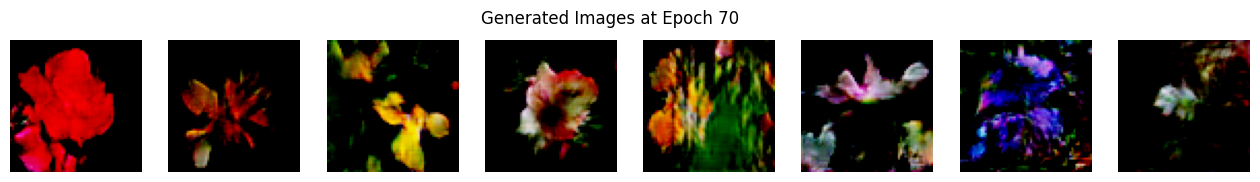

Epochs:  28%|██▊       | 71/250 [27:18<1:09:29, 23.29s/it]

Epoch [71/250] Step [0] Discriminator Loss: 0.73524609208107 Generator Loss: 0.5429444313049316
Epoch [71/250] Step [600] Discriminator Loss: 0.7184068560600281 Generator Loss: 0.6778149008750916
Epoch [71/250] Step [1200] Discriminator Loss: 0.7219347357749939 Generator Loss: 0.6698645353317261
Epoch [71/250] Step [1800] Discriminator Loss: 0.7442875802516937 Generator Loss: 0.5833292007446289
Epoch [71/250] Step [2400] Discriminator Loss: 0.703618198633194 Generator Loss: 0.6779747009277344
Epoch [71/250] Step [3000] Discriminator Loss: 0.7138839066028595 Generator Loss: 0.6530396342277527
Epoch [71/250] Step [3600] Discriminator Loss: 0.6960151791572571 Generator Loss: 0.5252025127410889
Epoch [71/250] Step [4200] Discriminator Loss: 0.734817236661911 Generator Loss: 0.7089391946792603
Epoch [71/250] Step [4800] Discriminator Loss: 0.6819112300872803 Generator Loss: 0.6631100177764893
Epoch [71/250] Step [5400] Discriminator Loss: 0.7176801264286041 Generator Loss: 0.624113023281097

Epochs:  29%|██▉       | 72/250 [27:41<1:08:57, 23.24s/it]

Epoch [72/250] Step [0] Discriminator Loss: 0.720918595790863 Generator Loss: 0.6227663159370422
Epoch [72/250] Step [600] Discriminator Loss: 0.7081118226051331 Generator Loss: 0.6445373892784119
Epoch [72/250] Step [1200] Discriminator Loss: 0.7392369210720062 Generator Loss: 0.6123431921005249
Epoch [72/250] Step [1800] Discriminator Loss: 0.7082819640636444 Generator Loss: 0.6342033743858337
Epoch [72/250] Step [2400] Discriminator Loss: 0.7018841207027435 Generator Loss: 0.6606482267379761
Epoch [72/250] Step [3000] Discriminator Loss: 0.7248793840408325 Generator Loss: 0.6564239859580994
Epoch [72/250] Step [3600] Discriminator Loss: 0.7204346656799316 Generator Loss: 0.5598326325416565
Epoch [72/250] Step [4200] Discriminator Loss: 0.6934115886688232 Generator Loss: 0.6655408143997192
Epoch [72/250] Step [4800] Discriminator Loss: 0.6975952982902527 Generator Loss: 0.6440801024436951
Epoch [72/250] Step [5400] Discriminator Loss: 0.7310598492622375 Generator Loss: 0.555041134357

Epochs:  29%|██▉       | 73/250 [28:04<1:08:25, 23.19s/it]

Epoch [73/250] Step [0] Discriminator Loss: 0.7029438316822052 Generator Loss: 0.6848272085189819
Epoch [73/250] Step [600] Discriminator Loss: 0.6794026494026184 Generator Loss: 0.5617942810058594
Epoch [73/250] Step [1200] Discriminator Loss: 0.7193759679794312 Generator Loss: 0.5927585363388062
Epoch [73/250] Step [1800] Discriminator Loss: 0.6962855756282806 Generator Loss: 0.5951471328735352
Epoch [73/250] Step [2400] Discriminator Loss: 0.6946609020233154 Generator Loss: 0.6197731494903564
Epoch [73/250] Step [3000] Discriminator Loss: 0.7113084197044373 Generator Loss: 0.5973576903343201
Epoch [73/250] Step [3600] Discriminator Loss: 0.7503232955932617 Generator Loss: 0.5226869583129883
Epoch [73/250] Step [4200] Discriminator Loss: 0.6973065137863159 Generator Loss: 0.5876705646514893
Epoch [73/250] Step [4800] Discriminator Loss: 0.6909587681293488 Generator Loss: 0.686397910118103
Epoch [73/250] Step [5400] Discriminator Loss: 0.7389968633651733 Generator Loss: 0.645449399948

Epochs:  30%|██▉       | 74/250 [28:27<1:07:57, 23.17s/it]

Epoch [74/250] Step [0] Discriminator Loss: 0.7342463135719299 Generator Loss: 0.670792818069458
Epoch [74/250] Step [600] Discriminator Loss: 0.728700578212738 Generator Loss: 0.6067749857902527
Epoch [74/250] Step [1200] Discriminator Loss: 0.6926060914993286 Generator Loss: 0.6642780303955078
Epoch [74/250] Step [1800] Discriminator Loss: 0.7237219512462616 Generator Loss: 0.6256480813026428
Epoch [74/250] Step [2400] Discriminator Loss: 0.6835013031959534 Generator Loss: 0.6261013746261597
Epoch [74/250] Step [3000] Discriminator Loss: 0.7290212213993073 Generator Loss: 0.6619236469268799
Epoch [74/250] Step [3600] Discriminator Loss: 0.7002726495265961 Generator Loss: 0.6647846698760986
Epoch [74/250] Step [4200] Discriminator Loss: 0.7066066265106201 Generator Loss: 0.5817862153053284
Epoch [74/250] Step [4800] Discriminator Loss: 0.7271692156791687 Generator Loss: 0.6329680681228638
Epoch [74/250] Step [5400] Discriminator Loss: 0.7540264427661896 Generator Loss: 0.6820629835128

Epochs:  30%|███       | 75/250 [28:51<1:07:30, 23.15s/it]

Epoch [75/250] Step [0] Discriminator Loss: 0.690710574388504 Generator Loss: 0.666050374507904
Epoch [75/250] Step [600] Discriminator Loss: 0.7038723230361938 Generator Loss: 0.6510956287384033
Epoch [75/250] Step [1200] Discriminator Loss: 0.7249588966369629 Generator Loss: 0.5767320394515991
Epoch [75/250] Step [1800] Discriminator Loss: 0.7159984409809113 Generator Loss: 0.6318861246109009
Epoch [75/250] Step [2400] Discriminator Loss: 0.6980770826339722 Generator Loss: 0.6229612231254578
Epoch [75/250] Step [3000] Discriminator Loss: 0.7085728943347931 Generator Loss: 0.573460578918457
Epoch [75/250] Step [3600] Discriminator Loss: 0.7004362940788269 Generator Loss: 0.6649622917175293
Epoch [75/250] Step [4200] Discriminator Loss: 0.7532942593097687 Generator Loss: 0.6786859035491943
Epoch [75/250] Step [4800] Discriminator Loss: 0.7084711492061615 Generator Loss: 0.6725507974624634
Epoch [75/250] Step [5400] Discriminator Loss: 0.6767539381980896 Generator Loss: 0.60168254375457

Epochs:  30%|███       | 76/250 [29:14<1:07:03, 23.13s/it]

Epoch [76/250] Step [0] Discriminator Loss: 0.7211551368236542 Generator Loss: 0.6910585761070251
Epoch [76/250] Step [600] Discriminator Loss: 0.7135944366455078 Generator Loss: 0.6495088338851929
Epoch [76/250] Step [1200] Discriminator Loss: 0.7055965065956116 Generator Loss: 0.6015976667404175
Epoch [76/250] Step [1800] Discriminator Loss: 0.7118674218654633 Generator Loss: 0.6367884874343872
Epoch [76/250] Step [2400] Discriminator Loss: 0.6883867084980011 Generator Loss: 0.6031400561332703
Epoch [76/250] Step [3000] Discriminator Loss: 0.707237035036087 Generator Loss: 0.5962961912155151
Epoch [76/250] Step [3600] Discriminator Loss: 0.6948274970054626 Generator Loss: 0.6151247620582581
Epoch [76/250] Step [4200] Discriminator Loss: 0.738519549369812 Generator Loss: 0.5926879644393921
Epoch [76/250] Step [4800] Discriminator Loss: 0.6795859634876251 Generator Loss: 0.5951898694038391
Epoch [76/250] Step [5400] Discriminator Loss: 0.702085018157959 Generator Loss: 0.59400463104248

Epochs:  31%|███       | 77/250 [29:37<1:06:38, 23.11s/it]

Epoch [77/250] Step [0] Discriminator Loss: 0.6988635063171387 Generator Loss: 0.6216220259666443
Epoch [77/250] Step [600] Discriminator Loss: 0.7197334468364716 Generator Loss: 0.6067299246788025
Epoch [77/250] Step [1200] Discriminator Loss: 0.6999877989292145 Generator Loss: 0.5974932312965393
Epoch [77/250] Step [1800] Discriminator Loss: 0.721031129360199 Generator Loss: 0.6496890187263489
Epoch [77/250] Step [2400] Discriminator Loss: 0.6878508925437927 Generator Loss: 0.6299073696136475
Epoch [77/250] Step [3000] Discriminator Loss: 0.7046778798103333 Generator Loss: 0.6064289212226868
Epoch [77/250] Step [3600] Discriminator Loss: 0.6968863606452942 Generator Loss: 0.5637872219085693
Epoch [77/250] Step [4200] Discriminator Loss: 0.684749186038971 Generator Loss: 0.5864198803901672
Epoch [77/250] Step [4800] Discriminator Loss: 0.7079378366470337 Generator Loss: 0.6181826591491699
Epoch [77/250] Step [5400] Discriminator Loss: 0.7073736786842346 Generator Loss: 0.6008536815643

Epochs:  31%|███       | 78/250 [30:00<1:06:15, 23.11s/it]

Epoch [78/250] Step [0] Discriminator Loss: 0.6945113241672516 Generator Loss: 0.5867372751235962
Epoch [78/250] Step [600] Discriminator Loss: 0.7151280045509338 Generator Loss: 0.6269581317901611
Epoch [78/250] Step [1200] Discriminator Loss: 0.6956384778022766 Generator Loss: 0.586109459400177
Epoch [78/250] Step [1800] Discriminator Loss: 0.7027828991413116 Generator Loss: 0.6996021866798401
Epoch [78/250] Step [2400] Discriminator Loss: 0.6903619170188904 Generator Loss: 0.5994125604629517
Epoch [78/250] Step [3000] Discriminator Loss: 0.7246090173721313 Generator Loss: 0.6428015828132629
Epoch [78/250] Step [3600] Discriminator Loss: 0.7055061161518097 Generator Loss: 0.6617233157157898
Epoch [78/250] Step [4200] Discriminator Loss: 0.6943654417991638 Generator Loss: 0.597680389881134
Epoch [78/250] Step [4800] Discriminator Loss: 0.706262856721878 Generator Loss: 0.6074143648147583
Epoch [78/250] Step [5400] Discriminator Loss: 0.695564329624176 Generator Loss: 0.675993382930755

Epochs:  32%|███▏      | 79/250 [30:23<1:05:52, 23.12s/it]

Epoch [79/250] Step [0] Discriminator Loss: 0.6948074698448181 Generator Loss: 0.6330857276916504
Epoch [79/250] Step [600] Discriminator Loss: 0.719397097826004 Generator Loss: 0.6663114428520203
Epoch [79/250] Step [1200] Discriminator Loss: 0.7161101698875427 Generator Loss: 0.6160232424736023
Epoch [79/250] Step [1800] Discriminator Loss: 0.7192416787147522 Generator Loss: 0.5781509876251221
Epoch [79/250] Step [2400] Discriminator Loss: 0.7313255667686462 Generator Loss: 0.600898265838623
Epoch [79/250] Step [3000] Discriminator Loss: 0.7056786417961121 Generator Loss: 0.658136248588562
Epoch [79/250] Step [3600] Discriminator Loss: 0.6977640986442566 Generator Loss: 0.5911098718643188
Epoch [79/250] Step [4200] Discriminator Loss: 0.697817325592041 Generator Loss: 0.6264859437942505
Epoch [79/250] Step [4800] Discriminator Loss: 0.722696840763092 Generator Loss: 0.6254844665527344
Epoch [79/250] Step [5400] Discriminator Loss: 0.6776530146598816 Generator Loss: 0.6404783725738525

Epochs:  32%|███▏      | 80/250 [30:46<1:05:28, 23.11s/it]

Epoch [80/250] Step [0] Discriminator Loss: 0.6916781067848206 Generator Loss: 0.6237084269523621
Epoch [80/250] Step [600] Discriminator Loss: 0.6842592358589172 Generator Loss: 0.6266254186630249
Epoch [80/250] Step [1200] Discriminator Loss: 0.6874405145645142 Generator Loss: 0.6161775588989258
Epoch [80/250] Step [1800] Discriminator Loss: 0.6960813999176025 Generator Loss: 0.625763475894928
Epoch [80/250] Step [2400] Discriminator Loss: 0.73247891664505 Generator Loss: 0.500322163105011
Epoch [80/250] Step [3000] Discriminator Loss: 0.6931080520153046 Generator Loss: 0.6407051682472229
Epoch [80/250] Step [3600] Discriminator Loss: 0.7131056785583496 Generator Loss: 0.5850430130958557
Epoch [80/250] Step [4200] Discriminator Loss: 0.6965350210666656 Generator Loss: 0.661661684513092
Epoch [80/250] Step [4800] Discriminator Loss: 0.6844497621059418 Generator Loss: 0.6424292325973511
Epoch [80/250] Step [5400] Discriminator Loss: 0.700358510017395 Generator Loss: 0.6260228157043457


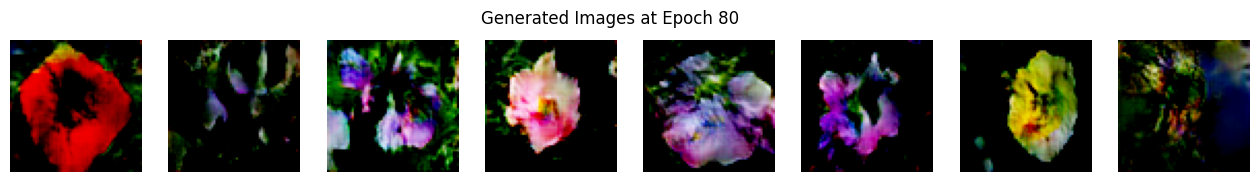

Epochs:  32%|███▏      | 81/250 [31:10<1:05:28, 23.24s/it]

Epoch [81/250] Step [0] Discriminator Loss: 0.7051938772201538 Generator Loss: 0.6312436461448669
Epoch [81/250] Step [600] Discriminator Loss: 0.7062224745750427 Generator Loss: 0.5838901996612549
Epoch [81/250] Step [1200] Discriminator Loss: 0.7155661284923553 Generator Loss: 0.5752878785133362
Epoch [81/250] Step [1800] Discriminator Loss: 0.7113582491874695 Generator Loss: 0.6185485124588013
Epoch [81/250] Step [2400] Discriminator Loss: 0.6818262338638306 Generator Loss: 0.6301907300949097
Epoch [81/250] Step [3000] Discriminator Loss: 0.7024083435535431 Generator Loss: 0.560370147228241
Epoch [81/250] Step [3600] Discriminator Loss: 0.679612010717392 Generator Loss: 0.6405127048492432
Epoch [81/250] Step [4200] Discriminator Loss: 0.7279722690582275 Generator Loss: 0.6923335194587708
Epoch [81/250] Step [4800] Discriminator Loss: 0.6937116980552673 Generator Loss: 0.6344817280769348
Epoch [81/250] Step [5400] Discriminator Loss: 0.6980917155742645 Generator Loss: 0.6508958935737

Epochs:  33%|███▎      | 82/250 [31:33<1:04:57, 23.20s/it]

Epoch [82/250] Step [0] Discriminator Loss: 0.6842321753501892 Generator Loss: 0.6448644399642944
Epoch [82/250] Step [600] Discriminator Loss: 0.6998920738697052 Generator Loss: 0.5883182883262634
Epoch [82/250] Step [1200] Discriminator Loss: 0.7147247195243835 Generator Loss: 0.6783445477485657
Epoch [82/250] Step [1800] Discriminator Loss: 0.6973193287849426 Generator Loss: 0.6668955087661743
Epoch [82/250] Step [2400] Discriminator Loss: 0.7063331305980682 Generator Loss: 0.6656349897384644
Epoch [82/250] Step [3000] Discriminator Loss: 0.7084259390830994 Generator Loss: 0.5823431015014648
Epoch [82/250] Step [3600] Discriminator Loss: 0.6923282444477081 Generator Loss: 0.6093671321868896
Epoch [82/250] Step [4200] Discriminator Loss: 0.7082418203353882 Generator Loss: 0.6408539414405823
Epoch [82/250] Step [4800] Discriminator Loss: 0.7216190099716187 Generator Loss: 0.6360701322555542
Epoch [82/250] Step [5400] Discriminator Loss: 0.7089976370334625 Generator Loss: 0.57967370748

Epochs:  33%|███▎      | 83/250 [31:56<1:04:28, 23.16s/it]

Epoch [83/250] Step [0] Discriminator Loss: 0.7415878176689148 Generator Loss: 0.6161919236183167
Epoch [83/250] Step [600] Discriminator Loss: 0.7161003947257996 Generator Loss: 0.570270836353302
Epoch [83/250] Step [1200] Discriminator Loss: 0.719519317150116 Generator Loss: 0.6547049880027771
Epoch [83/250] Step [1800] Discriminator Loss: 0.6969330310821533 Generator Loss: 0.70695561170578
Epoch [83/250] Step [2400] Discriminator Loss: 0.7187936007976532 Generator Loss: 0.5836063027381897
Epoch [83/250] Step [3000] Discriminator Loss: 0.7078111469745636 Generator Loss: 0.668037474155426
Epoch [83/250] Step [3600] Discriminator Loss: 0.6911394000053406 Generator Loss: 0.6586961150169373
Epoch [83/250] Step [4200] Discriminator Loss: 0.68832066655159 Generator Loss: 0.628553569316864
Epoch [83/250] Step [4800] Discriminator Loss: 0.7018862068653107 Generator Loss: 0.6513640880584717
Epoch [83/250] Step [5400] Discriminator Loss: 0.7172678709030151 Generator Loss: 0.5919694900512695
Ep

Epochs:  34%|███▎      | 84/250 [32:19<1:04:00, 23.14s/it]

Epoch [84/250] Step [0] Discriminator Loss: 0.7296913266181946 Generator Loss: 0.5750483870506287
Epoch [84/250] Step [600] Discriminator Loss: 0.7169819176197052 Generator Loss: 0.5671465992927551
Epoch [84/250] Step [1200] Discriminator Loss: 0.7106664478778839 Generator Loss: 0.6420369744300842
Epoch [84/250] Step [1800] Discriminator Loss: 0.6925681531429291 Generator Loss: 0.6723711490631104
Epoch [84/250] Step [2400] Discriminator Loss: 0.6756739318370819 Generator Loss: 0.6663650870323181
Epoch [84/250] Step [3000] Discriminator Loss: 0.7113746106624603 Generator Loss: 0.6062501072883606
Epoch [84/250] Step [3600] Discriminator Loss: 0.694495677947998 Generator Loss: 0.681540846824646
Epoch [84/250] Step [4200] Discriminator Loss: 0.6911339461803436 Generator Loss: 0.5791725516319275
Epoch [84/250] Step [4800] Discriminator Loss: 0.6833784878253937 Generator Loss: 0.649681568145752
Epoch [84/250] Step [5400] Discriminator Loss: 0.6880552768707275 Generator Loss: 0.62303066253662

Epochs:  34%|███▍      | 85/250 [32:42<1:03:34, 23.12s/it]

Epoch [85/250] Step [0] Discriminator Loss: 0.7124732434749603 Generator Loss: 0.6194138526916504
Epoch [85/250] Step [600] Discriminator Loss: 0.6952077150344849 Generator Loss: 0.6648848056793213
Epoch [85/250] Step [1200] Discriminator Loss: 0.7114118933677673 Generator Loss: 0.6613607406616211
Epoch [85/250] Step [1800] Discriminator Loss: 0.7042663097381592 Generator Loss: 0.5947351455688477
Epoch [85/250] Step [2400] Discriminator Loss: 0.7209572792053223 Generator Loss: 0.6616065502166748
Epoch [85/250] Step [3000] Discriminator Loss: 0.7299706935882568 Generator Loss: 0.6125801205635071
Epoch [85/250] Step [3600] Discriminator Loss: 0.6994821727275848 Generator Loss: 0.6704421043395996
Epoch [85/250] Step [4200] Discriminator Loss: 0.7194394171237946 Generator Loss: 0.6000418066978455
Epoch [85/250] Step [4800] Discriminator Loss: 0.7259934544563293 Generator Loss: 0.517223596572876
Epoch [85/250] Step [5400] Discriminator Loss: 0.7045827805995941 Generator Loss: 0.649090170860

Epochs:  34%|███▍      | 86/250 [33:05<1:03:09, 23.11s/it]

Epoch [86/250] Step [0] Discriminator Loss: 0.6791291832923889 Generator Loss: 0.6464428901672363
Epoch [86/250] Step [600] Discriminator Loss: 0.6989213526248932 Generator Loss: 0.6360266804695129
Epoch [86/250] Step [1200] Discriminator Loss: 0.7040764689445496 Generator Loss: 0.6403624415397644
Epoch [86/250] Step [1800] Discriminator Loss: 0.6976369917392731 Generator Loss: 0.5592026114463806
Epoch [86/250] Step [2400] Discriminator Loss: 0.6984931826591492 Generator Loss: 0.5758908987045288
Epoch [86/250] Step [3000] Discriminator Loss: 0.7247646152973175 Generator Loss: 0.6642612218856812
Epoch [86/250] Step [3600] Discriminator Loss: 0.7083038687705994 Generator Loss: 0.6263059377670288
Epoch [86/250] Step [4200] Discriminator Loss: 0.7019006013870239 Generator Loss: 0.6207855343818665
Epoch [86/250] Step [4800] Discriminator Loss: 0.7662862837314606 Generator Loss: 0.5826212167739868
Epoch [86/250] Step [5400] Discriminator Loss: 0.7061503827571869 Generator Loss: 0.55806827545

Epochs:  35%|███▍      | 87/250 [33:28<1:02:46, 23.11s/it]

Epoch [87/250] Step [0] Discriminator Loss: 0.6862795948982239 Generator Loss: 0.6323940753936768
Epoch [87/250] Step [600] Discriminator Loss: 0.6959585845470428 Generator Loss: 0.5937311053276062
Epoch [87/250] Step [1200] Discriminator Loss: 0.7655295729637146 Generator Loss: 0.5432145595550537
Epoch [87/250] Step [1800] Discriminator Loss: 0.7293124794960022 Generator Loss: 0.6328933238983154
Epoch [87/250] Step [2400] Discriminator Loss: 0.698796808719635 Generator Loss: 0.6077266335487366
Epoch [87/250] Step [3000] Discriminator Loss: 0.6891347169876099 Generator Loss: 0.6653551459312439
Epoch [87/250] Step [3600] Discriminator Loss: 0.7029504179954529 Generator Loss: 0.5796283483505249
Epoch [87/250] Step [4200] Discriminator Loss: 0.6911601424217224 Generator Loss: 0.6896586418151855
Epoch [87/250] Step [4800] Discriminator Loss: 0.7185909748077393 Generator Loss: 0.6973719596862793
Epoch [87/250] Step [5400] Discriminator Loss: 0.6873059272766113 Generator Loss: 0.597248136997

Epochs:  35%|███▌      | 88/250 [33:51<1:02:22, 23.10s/it]

Epoch [88/250] Step [0] Discriminator Loss: 0.7005857825279236 Generator Loss: 0.634608268737793
Epoch [88/250] Step [600] Discriminator Loss: 0.6795368492603302 Generator Loss: 0.6631041169166565
Epoch [88/250] Step [1200] Discriminator Loss: 0.7005804181098938 Generator Loss: 0.6810887455940247
Epoch [88/250] Step [1800] Discriminator Loss: 0.6918962299823761 Generator Loss: 0.6262235641479492
Epoch [88/250] Step [2400] Discriminator Loss: 0.7080242037773132 Generator Loss: 0.6265742778778076
Epoch [88/250] Step [3000] Discriminator Loss: 0.6812886595726013 Generator Loss: 0.606823205947876
Epoch [88/250] Step [3600] Discriminator Loss: 0.6968067586421967 Generator Loss: 0.6487192511558533
Epoch [88/250] Step [4200] Discriminator Loss: 0.7006142437458038 Generator Loss: 0.6581833958625793
Epoch [88/250] Step [4800] Discriminator Loss: 0.7303890287876129 Generator Loss: 0.6730628609657288
Epoch [88/250] Step [5400] Discriminator Loss: 0.6869909167289734 Generator Loss: 0.5907139778137

Epochs:  36%|███▌      | 89/250 [34:14<1:01:58, 23.10s/it]

Epoch [89/250] Step [0] Discriminator Loss: 0.7208715081214905 Generator Loss: 0.6351565718650818
Epoch [89/250] Step [600] Discriminator Loss: 0.689124196767807 Generator Loss: 0.5718929767608643
Epoch [89/250] Step [1200] Discriminator Loss: 0.7100699543952942 Generator Loss: 0.6842193603515625
Epoch [89/250] Step [1800] Discriminator Loss: 0.6937457025051117 Generator Loss: 0.6363680958747864
Epoch [89/250] Step [2400] Discriminator Loss: 0.6991257071495056 Generator Loss: 0.648324728012085
Epoch [89/250] Step [3000] Discriminator Loss: 0.6817271411418915 Generator Loss: 0.6105518341064453
Epoch [89/250] Step [3600] Discriminator Loss: 0.6768822968006134 Generator Loss: 0.6233527660369873
Epoch [89/250] Step [4200] Discriminator Loss: 0.7015774846076965 Generator Loss: 0.6390681266784668
Epoch [89/250] Step [4800] Discriminator Loss: 0.6906777322292328 Generator Loss: 0.5798771977424622
Epoch [89/250] Step [5400] Discriminator Loss: 0.683409184217453 Generator Loss: 0.58457934856414

Epochs:  36%|███▌      | 90/250 [34:37<1:01:35, 23.09s/it]

Epoch [90/250] Step [0] Discriminator Loss: 0.703264594078064 Generator Loss: 0.5724388360977173
Epoch [90/250] Step [600] Discriminator Loss: 0.6925715804100037 Generator Loss: 0.6254518032073975
Epoch [90/250] Step [1200] Discriminator Loss: 0.6989326775074005 Generator Loss: 0.6472907066345215
Epoch [90/250] Step [1800] Discriminator Loss: 0.7023730576038361 Generator Loss: 0.6705238819122314
Epoch [90/250] Step [2400] Discriminator Loss: 0.6860899329185486 Generator Loss: 0.6029507517814636
Epoch [90/250] Step [3000] Discriminator Loss: 0.6727166771888733 Generator Loss: 0.6194472908973694
Epoch [90/250] Step [3600] Discriminator Loss: 0.6852101385593414 Generator Loss: 0.6196551322937012
Epoch [90/250] Step [4200] Discriminator Loss: 0.7024549543857574 Generator Loss: 0.5928124189376831
Epoch [90/250] Step [4800] Discriminator Loss: 0.7321797311306 Generator Loss: 0.6242596507072449
Epoch [90/250] Step [5400] Discriminator Loss: 0.7292346656322479 Generator Loss: 0.586206674575805

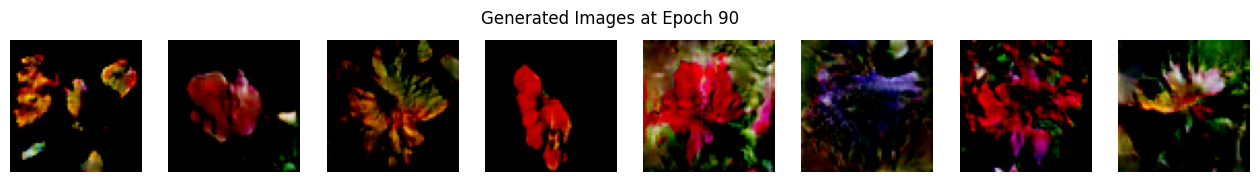

Epochs:  36%|███▋      | 91/250 [35:01<1:01:41, 23.28s/it]

Epoch [91/250] Step [0] Discriminator Loss: 0.7377569675445557 Generator Loss: 0.6032679677009583
Epoch [91/250] Step [600] Discriminator Loss: 0.689304918050766 Generator Loss: 0.6561311483383179
Epoch [91/250] Step [1200] Discriminator Loss: 0.6986408829689026 Generator Loss: 0.584077000617981
Epoch [91/250] Step [1800] Discriminator Loss: 0.6980251669883728 Generator Loss: 0.6476365327835083
Epoch [91/250] Step [2400] Discriminator Loss: 0.6850691139698029 Generator Loss: 0.6561218500137329
Epoch [91/250] Step [3000] Discriminator Loss: 0.7098649442195892 Generator Loss: 0.5848499536514282
Epoch [91/250] Step [3600] Discriminator Loss: 0.6901180446147919 Generator Loss: 0.6395991444587708
Epoch [91/250] Step [4200] Discriminator Loss: 0.6935148239135742 Generator Loss: 0.6659381985664368
Epoch [91/250] Step [4800] Discriminator Loss: 0.6886337101459503 Generator Loss: 0.6358439326286316
Epoch [91/250] Step [5400] Discriminator Loss: 0.7089990675449371 Generator Loss: 0.6786223053932

Epochs:  37%|███▋      | 92/250 [35:24<1:01:09, 23.23s/it]

Epoch [92/250] Step [0] Discriminator Loss: 0.713075578212738 Generator Loss: 0.6692630052566528
Epoch [92/250] Step [600] Discriminator Loss: 0.6945445835590363 Generator Loss: 0.6443431973457336
Epoch [92/250] Step [1200] Discriminator Loss: 0.7302538752555847 Generator Loss: 0.6544175148010254
Epoch [92/250] Step [1800] Discriminator Loss: 0.7065366804599762 Generator Loss: 0.602959394454956
Epoch [92/250] Step [2400] Discriminator Loss: 0.7016047835350037 Generator Loss: 0.6084699034690857
Epoch [92/250] Step [3000] Discriminator Loss: 0.7340622544288635 Generator Loss: 0.5791782736778259
Epoch [92/250] Step [3600] Discriminator Loss: 0.685616135597229 Generator Loss: 0.6083335876464844
Epoch [92/250] Step [4200] Discriminator Loss: 0.6874934434890747 Generator Loss: 0.6342861652374268
Epoch [92/250] Step [4800] Discriminator Loss: 0.699042797088623 Generator Loss: 0.6419816613197327
Epoch [92/250] Step [5400] Discriminator Loss: 0.7059974372386932 Generator Loss: 0.681079864501953

Epochs:  37%|███▋      | 93/250 [35:47<1:00:41, 23.19s/it]

Epoch [93/250] Step [0] Discriminator Loss: 0.7036938965320587 Generator Loss: 0.6474785208702087
Epoch [93/250] Step [600] Discriminator Loss: 0.707828938961029 Generator Loss: 0.6430550813674927
Epoch [93/250] Step [1200] Discriminator Loss: 0.6925196051597595 Generator Loss: 0.6525769233703613
Epoch [93/250] Step [1800] Discriminator Loss: 0.6861940324306488 Generator Loss: 0.6014333367347717
Epoch [93/250] Step [2400] Discriminator Loss: 0.7062947750091553 Generator Loss: 0.5973215699195862
Epoch [93/250] Step [3000] Discriminator Loss: 0.69601109623909 Generator Loss: 0.6638624668121338
Epoch [93/250] Step [3600] Discriminator Loss: 0.693448543548584 Generator Loss: 0.6417004466056824
Epoch [93/250] Step [4200] Discriminator Loss: 0.7389009296894073 Generator Loss: 0.527398407459259
Epoch [93/250] Step [4800] Discriminator Loss: 0.7056724429130554 Generator Loss: 0.6269603371620178
Epoch [93/250] Step [5400] Discriminator Loss: 0.6789032816886902 Generator Loss: 0.6593151092529297

Epochs:  38%|███▊      | 94/250 [36:10<1:00:14, 23.17s/it]

Epoch [94/250] Step [0] Discriminator Loss: 0.6732538044452667 Generator Loss: 0.6178625822067261
Epoch [94/250] Step [600] Discriminator Loss: 0.7499916851520538 Generator Loss: 0.5695324540138245
Epoch [94/250] Step [1200] Discriminator Loss: 0.7004795074462891 Generator Loss: 0.6086822748184204
Epoch [94/250] Step [1800] Discriminator Loss: 0.7142305374145508 Generator Loss: 0.5831106901168823
Epoch [94/250] Step [2400] Discriminator Loss: 0.7087534368038177 Generator Loss: 0.6360275745391846
Epoch [94/250] Step [3000] Discriminator Loss: 0.721357524394989 Generator Loss: 0.6620720624923706
Epoch [94/250] Step [3600] Discriminator Loss: 0.6982243657112122 Generator Loss: 0.6052208542823792
Epoch [94/250] Step [4200] Discriminator Loss: 0.7542490661144257 Generator Loss: 0.561051607131958
Epoch [94/250] Step [4800] Discriminator Loss: 0.7031837105751038 Generator Loss: 0.6760616898536682
Epoch [94/250] Step [5400] Discriminator Loss: 0.7040977478027344 Generator Loss: 0.6519322395324

Epochs:  38%|███▊      | 95/250 [36:34<59:48, 23.15s/it]  

Epoch [95/250] Step [0] Discriminator Loss: 0.6993577182292938 Generator Loss: 0.5924345850944519
Epoch [95/250] Step [600] Discriminator Loss: 0.7579807043075562 Generator Loss: 0.6120845079421997
Epoch [95/250] Step [1200] Discriminator Loss: 0.6945761740207672 Generator Loss: 0.6869199275970459
Epoch [95/250] Step [1800] Discriminator Loss: 0.7037472724914551 Generator Loss: 0.6531534790992737
Epoch [95/250] Step [2400] Discriminator Loss: 0.7180035710334778 Generator Loss: 0.6828435659408569
Epoch [95/250] Step [3000] Discriminator Loss: 0.686552107334137 Generator Loss: 0.6368832588195801
Epoch [95/250] Step [3600] Discriminator Loss: 0.7274180054664612 Generator Loss: 0.6186890006065369
Epoch [95/250] Step [4200] Discriminator Loss: 0.6860421001911163 Generator Loss: 0.6402369737625122
Epoch [95/250] Step [4800] Discriminator Loss: 0.6885754466056824 Generator Loss: 0.612110435962677
Epoch [95/250] Step [5400] Discriminator Loss: 0.6977564990520477 Generator Loss: 0.6095615625381

Epochs:  38%|███▊      | 96/250 [36:57<59:22, 23.13s/it]

Epoch [96/250] Step [0] Discriminator Loss: 0.7286974191665649 Generator Loss: 0.6875655055046082
Epoch [96/250] Step [600] Discriminator Loss: 0.6858104467391968 Generator Loss: 0.6657365560531616
Epoch [96/250] Step [1200] Discriminator Loss: 0.6988946497440338 Generator Loss: 0.656978964805603
Epoch [96/250] Step [1800] Discriminator Loss: 0.695105105638504 Generator Loss: 0.6685291528701782
Epoch [96/250] Step [2400] Discriminator Loss: 0.7060088515281677 Generator Loss: 0.6556946635246277
Epoch [96/250] Step [3000] Discriminator Loss: 0.6916934549808502 Generator Loss: 0.6216126680374146
Epoch [96/250] Step [3600] Discriminator Loss: 0.7325525879859924 Generator Loss: 0.546321451663971
Epoch [96/250] Step [4200] Discriminator Loss: 0.6877093613147736 Generator Loss: 0.6416722536087036
Epoch [96/250] Step [4800] Discriminator Loss: 0.711434543132782 Generator Loss: 0.6225669384002686
Epoch [96/250] Step [5400] Discriminator Loss: 0.7005367875099182 Generator Loss: 0.599721252918243

Epochs:  39%|███▉      | 97/250 [37:20<58:56, 23.12s/it]

Epoch [97/250] Step [0] Discriminator Loss: 0.7032981812953949 Generator Loss: 0.6770889163017273
Epoch [97/250] Step [600] Discriminator Loss: 0.6945290863513947 Generator Loss: 0.6196794509887695
Epoch [97/250] Step [1200] Discriminator Loss: 0.6853564083576202 Generator Loss: 0.6312208771705627
Epoch [97/250] Step [1800] Discriminator Loss: 0.6814108192920685 Generator Loss: 0.6244782209396362
Epoch [97/250] Step [2400] Discriminator Loss: 0.6912029385566711 Generator Loss: 0.6239151954650879
Epoch [97/250] Step [3000] Discriminator Loss: 0.6951039433479309 Generator Loss: 0.667481005191803
Epoch [97/250] Step [3600] Discriminator Loss: 0.708358883857727 Generator Loss: 0.6284976601600647
Epoch [97/250] Step [4200] Discriminator Loss: 0.6841545104980469 Generator Loss: 0.6324823498725891
Epoch [97/250] Step [4800] Discriminator Loss: 0.6949146687984467 Generator Loss: 0.6470254063606262
Epoch [97/250] Step [5400] Discriminator Loss: 0.6974227726459503 Generator Loss: 0.6578080654144

Epochs:  39%|███▉      | 98/250 [37:43<58:30, 23.10s/it]

Epoch [98/250] Step [0] Discriminator Loss: 0.7033103406429291 Generator Loss: 0.635145902633667
Epoch [98/250] Step [600] Discriminator Loss: 0.6895268261432648 Generator Loss: 0.5886309742927551
Epoch [98/250] Step [1200] Discriminator Loss: 0.7114467322826385 Generator Loss: 0.6238071918487549
Epoch [98/250] Step [1800] Discriminator Loss: 0.6811508238315582 Generator Loss: 0.6215503215789795
Epoch [98/250] Step [2400] Discriminator Loss: 0.6946563720703125 Generator Loss: 0.5959705710411072
Epoch [98/250] Step [3000] Discriminator Loss: 0.7168124318122864 Generator Loss: 0.6475504040718079
Epoch [98/250] Step [3600] Discriminator Loss: 0.6975651681423187 Generator Loss: 0.6613942384719849
Epoch [98/250] Step [4200] Discriminator Loss: 0.6940416991710663 Generator Loss: 0.6426228284835815
Epoch [98/250] Step [4800] Discriminator Loss: 0.7111554443836212 Generator Loss: 0.5831849575042725
Epoch [98/250] Step [5400] Discriminator Loss: 0.7075256705284119 Generator Loss: 0.483537346124

Epochs:  40%|███▉      | 99/250 [38:06<58:04, 23.08s/it]

Epoch [99/250] Step [0] Discriminator Loss: 0.6773114800453186 Generator Loss: 0.6289358735084534
Epoch [99/250] Step [600] Discriminator Loss: 0.69498410820961 Generator Loss: 0.6300317645072937
Epoch [99/250] Step [1200] Discriminator Loss: 0.6804861426353455 Generator Loss: 0.6695528030395508
Epoch [99/250] Step [1800] Discriminator Loss: 0.7285539507865906 Generator Loss: 0.6238695383071899
Epoch [99/250] Step [2400] Discriminator Loss: 0.6865115761756897 Generator Loss: 0.5701376795768738
Epoch [99/250] Step [3000] Discriminator Loss: 0.7190806269645691 Generator Loss: 0.6580493450164795
Epoch [99/250] Step [3600] Discriminator Loss: 0.6870549917221069 Generator Loss: 0.6544733643531799
Epoch [99/250] Step [4200] Discriminator Loss: 0.7278571724891663 Generator Loss: 0.5879073143005371
Epoch [99/250] Step [4800] Discriminator Loss: 0.6918349266052246 Generator Loss: 0.6820811629295349
Epoch [99/250] Step [5400] Discriminator Loss: 0.7057375311851501 Generator Loss: 0.5954124927520

Epochs:  40%|████      | 100/250 [38:29<57:40, 23.07s/it]

Epoch [100/250] Step [0] Discriminator Loss: 0.6838414072990417 Generator Loss: 0.5506730079650879
Epoch [100/250] Step [600] Discriminator Loss: 0.6904458999633789 Generator Loss: 0.6618074774742126
Epoch [100/250] Step [1200] Discriminator Loss: 0.6765546202659607 Generator Loss: 0.6474091410636902
Epoch [100/250] Step [1800] Discriminator Loss: 0.7260096669197083 Generator Loss: 0.5119590759277344
Epoch [100/250] Step [2400] Discriminator Loss: 0.6759034395217896 Generator Loss: 0.6508620381355286
Epoch [100/250] Step [3000] Discriminator Loss: 0.7088384032249451 Generator Loss: 0.625329315662384
Epoch [100/250] Step [3600] Discriminator Loss: 0.7031401097774506 Generator Loss: 0.659925103187561
Epoch [100/250] Step [4200] Discriminator Loss: 0.6880131661891937 Generator Loss: 0.6727614402770996
Epoch [100/250] Step [4800] Discriminator Loss: 0.7007814049720764 Generator Loss: 0.6522738933563232
Epoch [100/250] Step [5400] Discriminator Loss: 0.6799134612083435 Generator Loss: 0.609

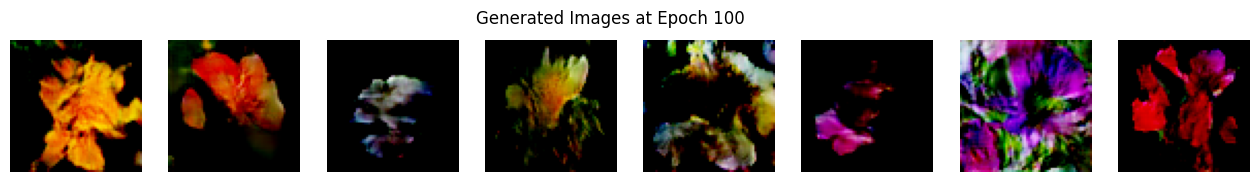

Epochs:  40%|████      | 101/250 [38:53<57:42, 23.24s/it]

Epoch [101/250] Step [0] Discriminator Loss: 0.6930666267871857 Generator Loss: 0.5838256478309631
Epoch [101/250] Step [600] Discriminator Loss: 0.6969331502914429 Generator Loss: 0.6371108293533325
Epoch [101/250] Step [1200] Discriminator Loss: 0.6777866184711456 Generator Loss: 0.6497229933738708
Epoch [101/250] Step [1800] Discriminator Loss: 0.6784605383872986 Generator Loss: 0.660731852054596
Epoch [101/250] Step [2400] Discriminator Loss: 0.6979005038738251 Generator Loss: 0.6435754299163818
Epoch [101/250] Step [3000] Discriminator Loss: 0.6763113439083099 Generator Loss: 0.6379668712615967
Epoch [101/250] Step [3600] Discriminator Loss: 0.6969366073608398 Generator Loss: 0.5903875827789307
Epoch [101/250] Step [4200] Discriminator Loss: 0.6967724561691284 Generator Loss: 0.6775006055831909
Epoch [101/250] Step [4800] Discriminator Loss: 0.6810549199581146 Generator Loss: 0.6286787986755371
Epoch [101/250] Step [5400] Discriminator Loss: 0.6908658742904663 Generator Loss: 0.63

Epochs:  41%|████      | 102/250 [39:16<57:10, 23.18s/it]

Epoch [102/250] Step [0] Discriminator Loss: 0.7030704021453857 Generator Loss: 0.6375679969787598
Epoch [102/250] Step [600] Discriminator Loss: 0.67387455701828 Generator Loss: 0.655670166015625
Epoch [102/250] Step [1200] Discriminator Loss: 0.6832137107849121 Generator Loss: 0.6493783593177795
Epoch [102/250] Step [1800] Discriminator Loss: 0.6774278879165649 Generator Loss: 0.6502024531364441
Epoch [102/250] Step [2400] Discriminator Loss: 0.6887121796607971 Generator Loss: 0.6082402467727661
Epoch [102/250] Step [3000] Discriminator Loss: 0.6742340922355652 Generator Loss: 0.619412362575531
Epoch [102/250] Step [3600] Discriminator Loss: 0.6784947514533997 Generator Loss: 0.6401545405387878
Epoch [102/250] Step [4200] Discriminator Loss: 0.6923991441726685 Generator Loss: 0.6309602856636047
Epoch [102/250] Step [4800] Discriminator Loss: 0.6821644604206085 Generator Loss: 0.6210409998893738
Epoch [102/250] Step [5400] Discriminator Loss: 0.6777454018592834 Generator Loss: 0.63567

Epochs:  41%|████      | 103/250 [39:39<56:39, 23.13s/it]

Epoch [103/250] Step [0] Discriminator Loss: 0.6868930160999298 Generator Loss: 0.6522635221481323
Epoch [103/250] Step [600] Discriminator Loss: 0.6771909594535828 Generator Loss: 0.6112472414970398
Epoch [103/250] Step [1200] Discriminator Loss: 0.693558931350708 Generator Loss: 0.6460073590278625
Epoch [103/250] Step [1800] Discriminator Loss: 0.6792994737625122 Generator Loss: 0.6085727214813232
Epoch [103/250] Step [2400] Discriminator Loss: 0.7024855017662048 Generator Loss: 0.6413766145706177
Epoch [103/250] Step [3000] Discriminator Loss: 0.6681046783924103 Generator Loss: 0.5464906096458435
Epoch [103/250] Step [3600] Discriminator Loss: 0.6740791499614716 Generator Loss: 0.6240284442901611
Epoch [103/250] Step [4200] Discriminator Loss: 0.6842563152313232 Generator Loss: 0.5972335338592529
Epoch [103/250] Step [4800] Discriminator Loss: 0.675395667552948 Generator Loss: 0.6511286497116089
Epoch [103/250] Step [5400] Discriminator Loss: 0.6795604228973389 Generator Loss: 0.649

Epochs:  42%|████▏     | 104/250 [40:02<56:12, 23.10s/it]

Epoch [104/250] Step [0] Discriminator Loss: 0.6812146008014679 Generator Loss: 0.6981065273284912
Epoch [104/250] Step [600] Discriminator Loss: 0.6882165670394897 Generator Loss: 0.626085638999939
Epoch [104/250] Step [1200] Discriminator Loss: 0.6925751268863678 Generator Loss: 0.6153741478919983
Epoch [104/250] Step [1800] Discriminator Loss: 0.6800611913204193 Generator Loss: 0.6271953582763672
Epoch [104/250] Step [2400] Discriminator Loss: 0.6915012001991272 Generator Loss: 0.5905221104621887
Epoch [104/250] Step [3000] Discriminator Loss: 0.6765390336513519 Generator Loss: 0.5526930093765259
Epoch [104/250] Step [3600] Discriminator Loss: 0.6912241280078888 Generator Loss: 0.6052256226539612
Epoch [104/250] Step [4200] Discriminator Loss: 0.6850599348545074 Generator Loss: 0.6928566694259644
Epoch [104/250] Step [4800] Discriminator Loss: 0.6970275342464447 Generator Loss: 0.5881717205047607
Epoch [104/250] Step [5400] Discriminator Loss: 0.6847860813140869 Generator Loss: 0.64

Epochs:  42%|████▏     | 105/250 [40:25<55:47, 23.08s/it]

Epoch [105/250] Step [0] Discriminator Loss: 0.6861823499202728 Generator Loss: 0.6425075531005859
Epoch [105/250] Step [600] Discriminator Loss: 0.7041755318641663 Generator Loss: 0.5172995924949646
Epoch [105/250] Step [1200] Discriminator Loss: 0.6855349242687225 Generator Loss: 0.613703727722168
Epoch [105/250] Step [1800] Discriminator Loss: 0.7246564626693726 Generator Loss: 0.6392233967781067
Epoch [105/250] Step [2400] Discriminator Loss: 0.722720742225647 Generator Loss: 0.6822704076766968
Epoch [105/250] Step [3000] Discriminator Loss: 0.7404483556747437 Generator Loss: 0.6190685033798218
Epoch [105/250] Step [3600] Discriminator Loss: 0.7099188566207886 Generator Loss: 0.6041362881660461
Epoch [105/250] Step [4200] Discriminator Loss: 0.6858414113521576 Generator Loss: 0.6034755110740662
Epoch [105/250] Step [4800] Discriminator Loss: 0.6828636527061462 Generator Loss: 0.6011175513267517
Epoch [105/250] Step [5400] Discriminator Loss: 0.6885117888450623 Generator Loss: 0.601

Epochs:  42%|████▏     | 106/250 [40:48<55:22, 23.07s/it]

Epoch [106/250] Step [0] Discriminator Loss: 0.6826141774654388 Generator Loss: 0.6122828722000122
Epoch [106/250] Step [600] Discriminator Loss: 0.6952457427978516 Generator Loss: 0.6285198330879211
Epoch [106/250] Step [1200] Discriminator Loss: 0.7059324979782104 Generator Loss: 0.5559994578361511
Epoch [106/250] Step [1800] Discriminator Loss: 0.6897404193878174 Generator Loss: 0.6491803526878357
Epoch [106/250] Step [2400] Discriminator Loss: 0.7194746434688568 Generator Loss: 0.6767768859863281
Epoch [106/250] Step [3000] Discriminator Loss: 0.7135769426822662 Generator Loss: 0.6492574214935303
Epoch [106/250] Step [3600] Discriminator Loss: 0.6844975650310516 Generator Loss: 0.6442700028419495
Epoch [106/250] Step [4200] Discriminator Loss: 0.6878859102725983 Generator Loss: 0.614576518535614
Epoch [106/250] Step [4800] Discriminator Loss: 0.7054769992828369 Generator Loss: 0.6508599519729614
Epoch [106/250] Step [5400] Discriminator Loss: 0.6695603132247925 Generator Loss: 0.62

Epochs:  43%|████▎     | 107/250 [41:11<54:58, 23.07s/it]

Epoch [107/250] Step [0] Discriminator Loss: 0.6717795431613922 Generator Loss: 0.6319321393966675
Epoch [107/250] Step [600] Discriminator Loss: 0.6825332641601562 Generator Loss: 0.6347880959510803
Epoch [107/250] Step [1200] Discriminator Loss: 0.7450380325317383 Generator Loss: 0.5974442362785339
Epoch [107/250] Step [1800] Discriminator Loss: 0.6810440123081207 Generator Loss: 0.6076989769935608
Epoch [107/250] Step [2400] Discriminator Loss: 0.7272035479545593 Generator Loss: 0.6412477493286133
Epoch [107/250] Step [3000] Discriminator Loss: 0.6901731491088867 Generator Loss: 0.6371632218360901
Epoch [107/250] Step [3600] Discriminator Loss: 0.6842070519924164 Generator Loss: 0.6559313535690308
Epoch [107/250] Step [4200] Discriminator Loss: 0.6929841935634613 Generator Loss: 0.651958167552948
Epoch [107/250] Step [4800] Discriminator Loss: 0.6706467866897583 Generator Loss: 0.6748955845832825
Epoch [107/250] Step [5400] Discriminator Loss: 0.7061379849910736 Generator Loss: 0.53

Epochs:  43%|████▎     | 108/250 [41:34<54:34, 23.06s/it]

Epoch [108/250] Step [0] Discriminator Loss: 0.695491760969162 Generator Loss: 0.6405613422393799
Epoch [108/250] Step [600] Discriminator Loss: 0.693172961473465 Generator Loss: 0.652884304523468
Epoch [108/250] Step [1200] Discriminator Loss: 0.6750189065933228 Generator Loss: 0.6586039662361145
Epoch [108/250] Step [1800] Discriminator Loss: 0.6855623126029968 Generator Loss: 0.5967329740524292
Epoch [108/250] Step [2400] Discriminator Loss: 0.6855537593364716 Generator Loss: 0.6507362127304077
Epoch [108/250] Step [3000] Discriminator Loss: 0.672271192073822 Generator Loss: 0.6417762637138367
Epoch [108/250] Step [3600] Discriminator Loss: 0.6716830730438232 Generator Loss: 0.6281806826591492
Epoch [108/250] Step [4200] Discriminator Loss: 0.6765067279338837 Generator Loss: 0.6625598669052124
Epoch [108/250] Step [4800] Discriminator Loss: 0.682468056678772 Generator Loss: 0.6083822846412659
Epoch [108/250] Step [5400] Discriminator Loss: 0.6770640015602112 Generator Loss: 0.655843

Epochs:  44%|████▎     | 109/250 [41:57<54:12, 23.07s/it]

Epoch [109/250] Step [0] Discriminator Loss: 0.6802428364753723 Generator Loss: 0.6326500177383423
Epoch [109/250] Step [600] Discriminator Loss: 0.6808202862739563 Generator Loss: 0.6087556481361389
Epoch [109/250] Step [1200] Discriminator Loss: 0.6767770648002625 Generator Loss: 0.6622663736343384
Epoch [109/250] Step [1800] Discriminator Loss: 0.6808337271213531 Generator Loss: 0.6380049586296082
Epoch [109/250] Step [2400] Discriminator Loss: 0.6866835057735443 Generator Loss: 0.6363111138343811
Epoch [109/250] Step [3000] Discriminator Loss: 0.6713433861732483 Generator Loss: 0.6559925675392151
Epoch [109/250] Step [3600] Discriminator Loss: 0.6834502816200256 Generator Loss: 0.651731014251709
Epoch [109/250] Step [4200] Discriminator Loss: 0.6869257390499115 Generator Loss: 0.6122854351997375
Epoch [109/250] Step [4800] Discriminator Loss: 0.6896645426750183 Generator Loss: 0.6430515646934509
Epoch [109/250] Step [5400] Discriminator Loss: 0.6734954118728638 Generator Loss: 0.64

Epochs:  44%|████▍     | 110/250 [42:20<53:49, 23.06s/it]

Epoch [110/250] Step [0] Discriminator Loss: 0.6885343790054321 Generator Loss: 0.6450514793395996
Epoch [110/250] Step [600] Discriminator Loss: 0.697631448507309 Generator Loss: 0.6298103332519531
Epoch [110/250] Step [1200] Discriminator Loss: 0.6794750690460205 Generator Loss: 0.6641354560852051
Epoch [110/250] Step [1800] Discriminator Loss: 0.6715556979179382 Generator Loss: 0.5887342691421509
Epoch [110/250] Step [2400] Discriminator Loss: 0.6718693971633911 Generator Loss: 0.6326236128807068
Epoch [110/250] Step [3000] Discriminator Loss: 0.6980169415473938 Generator Loss: 0.6618187427520752
Epoch [110/250] Step [3600] Discriminator Loss: 0.6777567267417908 Generator Loss: 0.637498676776886
Epoch [110/250] Step [4200] Discriminator Loss: 0.6853362917900085 Generator Loss: 0.6529409885406494
Epoch [110/250] Step [4800] Discriminator Loss: 0.6745317280292511 Generator Loss: 0.5941498875617981
Epoch [110/250] Step [5400] Discriminator Loss: 0.6788822710514069 Generator Loss: 0.597

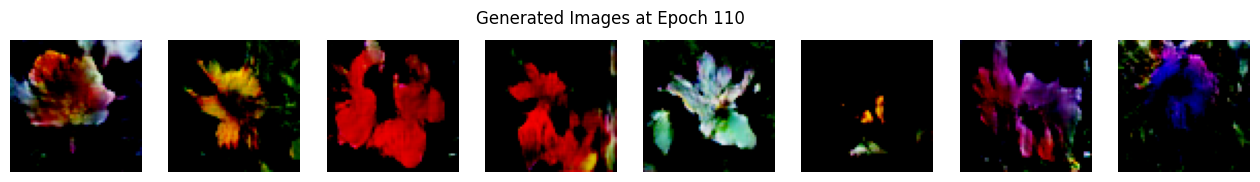

Epochs:  44%|████▍     | 111/250 [42:44<53:49, 23.24s/it]

Epoch [111/250] Step [0] Discriminator Loss: 0.6796540319919586 Generator Loss: 0.6043141484260559
Epoch [111/250] Step [600] Discriminator Loss: 0.6770578622817993 Generator Loss: 0.642214834690094
Epoch [111/250] Step [1200] Discriminator Loss: 0.6904730200767517 Generator Loss: 0.6718642711639404
Epoch [111/250] Step [1800] Discriminator Loss: 0.682706356048584 Generator Loss: 0.5938402414321899
Epoch [111/250] Step [2400] Discriminator Loss: 0.675157904624939 Generator Loss: 0.688683807849884
Epoch [111/250] Step [3000] Discriminator Loss: 0.6762391328811646 Generator Loss: 0.6474088430404663
Epoch [111/250] Step [3600] Discriminator Loss: 0.6799429357051849 Generator Loss: 0.6303619742393494
Epoch [111/250] Step [4200] Discriminator Loss: 0.6802145838737488 Generator Loss: 0.6738730072975159
Epoch [111/250] Step [4800] Discriminator Loss: 0.6786686778068542 Generator Loss: 0.6374534368515015
Epoch [111/250] Step [5400] Discriminator Loss: 0.6955264210700989 Generator Loss: 0.60637

Epochs:  45%|████▍     | 112/250 [43:07<53:18, 23.18s/it]

Epoch [112/250] Step [0] Discriminator Loss: 0.7025906443595886 Generator Loss: 0.5718689560890198
Epoch [112/250] Step [600] Discriminator Loss: 0.6687142848968506 Generator Loss: 0.6360466480255127
Epoch [112/250] Step [1200] Discriminator Loss: 0.7118535041809082 Generator Loss: 0.6702311635017395
Epoch [112/250] Step [1800] Discriminator Loss: 0.6708889305591583 Generator Loss: 0.626067578792572
Epoch [112/250] Step [2400] Discriminator Loss: 0.6798640787601471 Generator Loss: 0.6548408269882202
Epoch [112/250] Step [3000] Discriminator Loss: 0.7120909988880157 Generator Loss: 0.6052420139312744
Epoch [112/250] Step [3600] Discriminator Loss: 0.6683398485183716 Generator Loss: 0.6283071041107178
Epoch [112/250] Step [4200] Discriminator Loss: 0.6854466199874878 Generator Loss: 0.6663243174552917
Epoch [112/250] Step [4800] Discriminator Loss: 0.681885153055191 Generator Loss: 0.6277773976325989
Epoch [112/250] Step [5400] Discriminator Loss: 0.701348602771759 Generator Loss: 0.6575

Epochs:  45%|████▌     | 113/250 [43:30<52:50, 23.14s/it]

Epoch [113/250] Step [0] Discriminator Loss: 0.6999296844005585 Generator Loss: 0.6240733861923218
Epoch [113/250] Step [600] Discriminator Loss: 0.6818075180053711 Generator Loss: 0.6500517129898071
Epoch [113/250] Step [1200] Discriminator Loss: 0.6747177541255951 Generator Loss: 0.6148006319999695
Epoch [113/250] Step [1800] Discriminator Loss: 0.6842495501041412 Generator Loss: 0.6776787042617798
Epoch [113/250] Step [2400] Discriminator Loss: 0.6802057921886444 Generator Loss: 0.6515562534332275
Epoch [113/250] Step [3000] Discriminator Loss: 0.6756709814071655 Generator Loss: 0.6353140473365784
Epoch [113/250] Step [3600] Discriminator Loss: 0.6855935752391815 Generator Loss: 0.6727307438850403
Epoch [113/250] Step [4200] Discriminator Loss: 0.6870532631874084 Generator Loss: 0.671976625919342
Epoch [113/250] Step [4800] Discriminator Loss: 0.6951153874397278 Generator Loss: 0.5759066343307495
Epoch [113/250] Step [5400] Discriminator Loss: 0.7084358632564545 Generator Loss: 0.62

Epochs:  46%|████▌     | 114/250 [43:53<52:23, 23.12s/it]

Epoch [114/250] Step [0] Discriminator Loss: 0.6843012571334839 Generator Loss: 0.680560290813446
Epoch [114/250] Step [600] Discriminator Loss: 0.6906086802482605 Generator Loss: 0.5958018898963928
Epoch [114/250] Step [1200] Discriminator Loss: 0.7101418077945709 Generator Loss: 0.6760565042495728
Epoch [114/250] Step [1800] Discriminator Loss: 0.6949819326400757 Generator Loss: 0.5714325904846191
Epoch [114/250] Step [2400] Discriminator Loss: 0.7098514437675476 Generator Loss: 0.6288166046142578
Epoch [114/250] Step [3000] Discriminator Loss: 0.7037418186664581 Generator Loss: 0.6068866848945618
Epoch [114/250] Step [3600] Discriminator Loss: 0.6962974071502686 Generator Loss: 0.6415112614631653
Epoch [114/250] Step [4200] Discriminator Loss: 0.6715547442436218 Generator Loss: 0.6501895189285278
Epoch [114/250] Step [4800] Discriminator Loss: 0.6765654683113098 Generator Loss: 0.5969274044036865
Epoch [114/250] Step [5400] Discriminator Loss: 0.7062556743621826 Generator Loss: 0.65

Epochs:  46%|████▌     | 115/250 [44:16<51:57, 23.10s/it]

Epoch [115/250] Step [0] Discriminator Loss: 0.6993786096572876 Generator Loss: 0.642238974571228
Epoch [115/250] Step [600] Discriminator Loss: 0.6955013871192932 Generator Loss: 0.6308220624923706
Epoch [115/250] Step [1200] Discriminator Loss: 0.6831202507019043 Generator Loss: 0.6330190896987915
Epoch [115/250] Step [1800] Discriminator Loss: 0.6845646500587463 Generator Loss: 0.6609803438186646
Epoch [115/250] Step [2400] Discriminator Loss: 0.6847415864467621 Generator Loss: 0.6125088334083557
Epoch [115/250] Step [3000] Discriminator Loss: 0.7014991343021393 Generator Loss: 0.648765504360199
Epoch [115/250] Step [3600] Discriminator Loss: 0.696715921163559 Generator Loss: 0.643038272857666
Epoch [115/250] Step [4200] Discriminator Loss: 0.670794278383255 Generator Loss: 0.6123039126396179
Epoch [115/250] Step [4800] Discriminator Loss: 0.6820545792579651 Generator Loss: 0.6287481784820557
Epoch [115/250] Step [5400] Discriminator Loss: 0.6853167116641998 Generator Loss: 0.670268

Epochs:  46%|████▋     | 116/250 [44:39<51:32, 23.08s/it]

Epoch [116/250] Step [0] Discriminator Loss: 0.6665798425674438 Generator Loss: 0.6342018842697144
Epoch [116/250] Step [600] Discriminator Loss: 0.685762494802475 Generator Loss: 0.6093698740005493
Epoch [116/250] Step [1200] Discriminator Loss: 0.6758987307548523 Generator Loss: 0.6551651954650879
Epoch [116/250] Step [1800] Discriminator Loss: 0.6807422339916229 Generator Loss: 0.6249101758003235
Epoch [116/250] Step [2400] Discriminator Loss: 0.6852217018604279 Generator Loss: 0.6469560265541077
Epoch [116/250] Step [3000] Discriminator Loss: 0.6686776280403137 Generator Loss: 0.6354725360870361
Epoch [116/250] Step [3600] Discriminator Loss: 0.701549619436264 Generator Loss: 0.6476725339889526
Epoch [116/250] Step [4200] Discriminator Loss: 0.6984675824642181 Generator Loss: 0.6427595019340515
Epoch [116/250] Step [4800] Discriminator Loss: 0.6705268621444702 Generator Loss: 0.6350190043449402
Epoch [116/250] Step [5400] Discriminator Loss: 0.6877806484699249 Generator Loss: 0.635

Epochs:  47%|████▋     | 117/250 [45:02<51:09, 23.08s/it]

Epoch [117/250] Step [0] Discriminator Loss: 0.6701768040657043 Generator Loss: 0.6367882490158081
Epoch [117/250] Step [600] Discriminator Loss: 0.6800848841667175 Generator Loss: 0.634192168712616
Epoch [117/250] Step [1200] Discriminator Loss: 0.6897237598896027 Generator Loss: 0.6264395117759705
Epoch [117/250] Step [1800] Discriminator Loss: 0.6926645040512085 Generator Loss: 0.569480299949646
Epoch [117/250] Step [2400] Discriminator Loss: 0.6667672991752625 Generator Loss: 0.6602299213409424
Epoch [117/250] Step [3000] Discriminator Loss: 0.6769446134567261 Generator Loss: 0.6660814881324768
Epoch [117/250] Step [3600] Discriminator Loss: 0.6760468780994415 Generator Loss: 0.6254817247390747
Epoch [117/250] Step [4200] Discriminator Loss: 0.6810634732246399 Generator Loss: 0.6157368421554565
Epoch [117/250] Step [4800] Discriminator Loss: 0.685162216424942 Generator Loss: 0.6134882569313049
Epoch [117/250] Step [5400] Discriminator Loss: 0.691704124212265 Generator Loss: 0.62851

Epochs:  47%|████▋     | 118/250 [45:25<50:46, 23.08s/it]

Epoch [118/250] Step [0] Discriminator Loss: 0.6704698204994202 Generator Loss: 0.6268404126167297
Epoch [118/250] Step [600] Discriminator Loss: 0.6887445151805878 Generator Loss: 0.6668253540992737
Epoch [118/250] Step [1200] Discriminator Loss: 0.6692399978637695 Generator Loss: 0.647635281085968
Epoch [118/250] Step [1800] Discriminator Loss: 0.6693959832191467 Generator Loss: 0.6344955563545227
Epoch [118/250] Step [2400] Discriminator Loss: 0.6780819296836853 Generator Loss: 0.6221581697463989
Epoch [118/250] Step [3000] Discriminator Loss: 0.674945741891861 Generator Loss: 0.658270537853241
Epoch [118/250] Step [3600] Discriminator Loss: 0.6725074648857117 Generator Loss: 0.6268254518508911
Epoch [118/250] Step [4200] Discriminator Loss: 0.6773278713226318 Generator Loss: 0.6631670594215393
Epoch [118/250] Step [4800] Discriminator Loss: 0.6833210587501526 Generator Loss: 0.6484509706497192
Epoch [118/250] Step [5400] Discriminator Loss: 0.6718121469020844 Generator Loss: 0.6139

Epochs:  48%|████▊     | 119/250 [45:48<50:22, 23.08s/it]

Epoch [119/250] Step [0] Discriminator Loss: 0.6965248584747314 Generator Loss: 0.6258774399757385
Epoch [119/250] Step [600] Discriminator Loss: 0.6888888478279114 Generator Loss: 0.5817391276359558
Epoch [119/250] Step [1200] Discriminator Loss: 0.6747388243675232 Generator Loss: 0.638411283493042
Epoch [119/250] Step [1800] Discriminator Loss: 0.663368821144104 Generator Loss: 0.634952187538147
Epoch [119/250] Step [2400] Discriminator Loss: 0.6697677373886108 Generator Loss: 0.6388055086135864
Epoch [119/250] Step [3000] Discriminator Loss: 0.6700629889965057 Generator Loss: 0.6439959406852722
Epoch [119/250] Step [3600] Discriminator Loss: 0.6823338270187378 Generator Loss: 0.660037636756897
Epoch [119/250] Step [4200] Discriminator Loss: 0.6816043257713318 Generator Loss: 0.5941916704177856
Epoch [119/250] Step [4800] Discriminator Loss: 0.6756049394607544 Generator Loss: 0.6435537934303284
Epoch [119/250] Step [5400] Discriminator Loss: 0.679789125919342 Generator Loss: 0.683195

Epochs:  48%|████▊     | 120/250 [46:11<49:59, 23.07s/it]

Epoch [120/250] Step [0] Discriminator Loss: 0.6799187958240509 Generator Loss: 0.6182861328125
Epoch [120/250] Step [600] Discriminator Loss: 0.6954146027565002 Generator Loss: 0.6268150210380554
Epoch [120/250] Step [1200] Discriminator Loss: 0.7058410346508026 Generator Loss: 0.6474373936653137
Epoch [120/250] Step [1800] Discriminator Loss: 0.7077561914920807 Generator Loss: 0.5943019390106201
Epoch [120/250] Step [2400] Discriminator Loss: 0.675185352563858 Generator Loss: 0.6265745759010315
Epoch [120/250] Step [3000] Discriminator Loss: 0.6741649508476257 Generator Loss: 0.6295227408409119
Epoch [120/250] Step [3600] Discriminator Loss: 0.6832685470581055 Generator Loss: 0.60453200340271
Epoch [120/250] Step [4200] Discriminator Loss: 0.6662232279777527 Generator Loss: 0.6427310705184937
Epoch [120/250] Step [4800] Discriminator Loss: 0.6801565587520599 Generator Loss: 0.6503483057022095
Epoch [120/250] Step [5400] Discriminator Loss: 0.6769213080406189 Generator Loss: 0.5861306

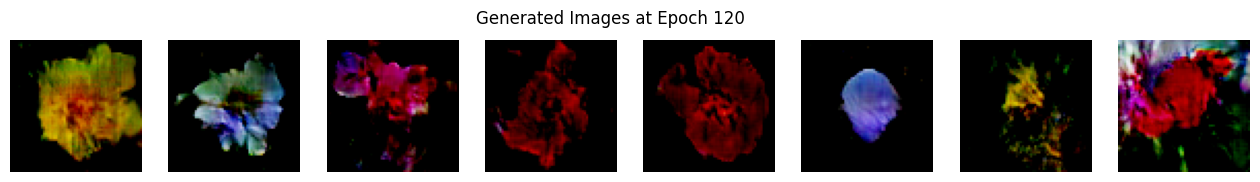

Epochs:  48%|████▊     | 121/250 [46:35<49:57, 23.24s/it]

Epoch [121/250] Step [0] Discriminator Loss: 0.6850062906742096 Generator Loss: 0.6730355620384216
Epoch [121/250] Step [600] Discriminator Loss: 0.7124205231666565 Generator Loss: 0.6267678737640381
Epoch [121/250] Step [1200] Discriminator Loss: 0.6845877766609192 Generator Loss: 0.6082428693771362
Epoch [121/250] Step [1800] Discriminator Loss: 0.6844211518764496 Generator Loss: 0.6645679473876953
Epoch [121/250] Step [2400] Discriminator Loss: 0.698865532875061 Generator Loss: 0.6134759187698364
Epoch [121/250] Step [3000] Discriminator Loss: 0.6900069713592529 Generator Loss: 0.6153134703636169
Epoch [121/250] Step [3600] Discriminator Loss: 0.6722481846809387 Generator Loss: 0.6633859276771545
Epoch [121/250] Step [4200] Discriminator Loss: 0.6977917551994324 Generator Loss: 0.6269223690032959
Epoch [121/250] Step [4800] Discriminator Loss: 0.7075110971927643 Generator Loss: 0.672022819519043
Epoch [121/250] Step [5400] Discriminator Loss: 0.7063950896263123 Generator Loss: 0.650

Epochs:  49%|████▉     | 122/250 [46:58<49:27, 23.18s/it]

Epoch [122/250] Step [0] Discriminator Loss: 0.6967493891716003 Generator Loss: 0.6825910806655884
Epoch [122/250] Step [600] Discriminator Loss: 0.6921012699604034 Generator Loss: 0.6141476631164551
Epoch [122/250] Step [1200] Discriminator Loss: 0.6989949345588684 Generator Loss: 0.6302850246429443
Epoch [122/250] Step [1800] Discriminator Loss: 0.7007605731487274 Generator Loss: 0.626156747341156
Epoch [122/250] Step [2400] Discriminator Loss: 0.6963252127170563 Generator Loss: 0.6255651116371155
Epoch [122/250] Step [3000] Discriminator Loss: 0.6790676116943359 Generator Loss: 0.6784679889678955
Epoch [122/250] Step [3600] Discriminator Loss: 0.6824919879436493 Generator Loss: 0.6300756931304932
Epoch [122/250] Step [4200] Discriminator Loss: 0.7059864401817322 Generator Loss: 0.671162486076355
Epoch [122/250] Step [4800] Discriminator Loss: 0.6934337317943573 Generator Loss: 0.6443519592285156
Epoch [122/250] Step [5400] Discriminator Loss: 0.6803622841835022 Generator Loss: 0.626

Epochs:  49%|████▉     | 123/250 [47:21<49:00, 23.15s/it]

Epoch [123/250] Step [0] Discriminator Loss: 0.6796914339065552 Generator Loss: 0.6521890759468079
Epoch [123/250] Step [600] Discriminator Loss: 0.6734167337417603 Generator Loss: 0.635710597038269
Epoch [123/250] Step [1200] Discriminator Loss: 0.6730081140995026 Generator Loss: 0.6765283346176147
Epoch [123/250] Step [1800] Discriminator Loss: 0.6947270929813385 Generator Loss: 0.6738574504852295
Epoch [123/250] Step [2400] Discriminator Loss: 0.6749757528305054 Generator Loss: 0.5646172761917114
Epoch [123/250] Step [3000] Discriminator Loss: 0.6769991815090179 Generator Loss: 0.5893067121505737
Epoch [123/250] Step [3600] Discriminator Loss: 0.6732907593250275 Generator Loss: 0.6489081978797913
Epoch [123/250] Step [4200] Discriminator Loss: 0.6683211624622345 Generator Loss: 0.645361065864563
Epoch [123/250] Step [4800] Discriminator Loss: 0.6763121485710144 Generator Loss: 0.6165528893470764
Epoch [123/250] Step [5400] Discriminator Loss: 0.6839576661586761 Generator Loss: 0.668

Epochs:  50%|████▉     | 124/250 [47:44<48:34, 23.13s/it]

Epoch [124/250] Step [0] Discriminator Loss: 0.6818345785140991 Generator Loss: 0.6286564469337463
Epoch [124/250] Step [600] Discriminator Loss: 0.6805205643177032 Generator Loss: 0.6147797107696533
Epoch [124/250] Step [1200] Discriminator Loss: 0.6830534934997559 Generator Loss: 0.6556124091148376
Epoch [124/250] Step [1800] Discriminator Loss: 0.6873903572559357 Generator Loss: 0.6671698689460754
Epoch [124/250] Step [2400] Discriminator Loss: 0.685652494430542 Generator Loss: 0.5920544266700745
Epoch [124/250] Step [3000] Discriminator Loss: 0.6822837889194489 Generator Loss: 0.6208175420761108
Epoch [124/250] Step [3600] Discriminator Loss: 0.6712950766086578 Generator Loss: 0.6038509011268616
Epoch [124/250] Step [4200] Discriminator Loss: 0.6948544085025787 Generator Loss: 0.6341402530670166
Epoch [124/250] Step [4800] Discriminator Loss: 0.6972416043281555 Generator Loss: 0.6035417914390564
Epoch [124/250] Step [5400] Discriminator Loss: 0.6708875894546509 Generator Loss: 0.63

Epochs:  50%|█████     | 125/250 [48:07<48:09, 23.11s/it]

Epoch [125/250] Step [0] Discriminator Loss: 0.6696983277797699 Generator Loss: 0.6211051940917969
Epoch [125/250] Step [600] Discriminator Loss: 0.6622919142246246 Generator Loss: 0.6474515795707703
Epoch [125/250] Step [1200] Discriminator Loss: 0.6779612898826599 Generator Loss: 0.613521158695221
Epoch [125/250] Step [1800] Discriminator Loss: 0.6701861023902893 Generator Loss: 0.635032594203949
Epoch [125/250] Step [2400] Discriminator Loss: 0.6839496195316315 Generator Loss: 0.6238324046134949
Epoch [125/250] Step [3000] Discriminator Loss: 0.6951211988925934 Generator Loss: 0.6408756971359253
Epoch [125/250] Step [3600] Discriminator Loss: 0.6888844072818756 Generator Loss: 0.6355308294296265
Epoch [125/250] Step [4200] Discriminator Loss: 0.6800060570240021 Generator Loss: 0.623947024345398
Epoch [125/250] Step [4800] Discriminator Loss: 0.6669739186763763 Generator Loss: 0.646800696849823
Epoch [125/250] Step [5400] Discriminator Loss: 0.6638660132884979 Generator Loss: 0.64030

Epochs:  50%|█████     | 126/250 [48:30<47:44, 23.10s/it]

Epoch [126/250] Step [0] Discriminator Loss: 0.6644198894500732 Generator Loss: 0.6252811551094055
Epoch [126/250] Step [600] Discriminator Loss: 0.6668657660484314 Generator Loss: 0.6178527474403381
Epoch [126/250] Step [1200] Discriminator Loss: 0.6713659167289734 Generator Loss: 0.6409146189689636
Epoch [126/250] Step [1800] Discriminator Loss: 0.6654398739337921 Generator Loss: 0.646814227104187
Epoch [126/250] Step [2400] Discriminator Loss: 0.6795116066932678 Generator Loss: 0.6593766212463379
Epoch [126/250] Step [3000] Discriminator Loss: 0.6698843836784363 Generator Loss: 0.6442669630050659
Epoch [126/250] Step [3600] Discriminator Loss: 0.6669408679008484 Generator Loss: 0.6488209366798401
Epoch [126/250] Step [4200] Discriminator Loss: 0.6901368200778961 Generator Loss: 0.6662855744361877
Epoch [126/250] Step [4800] Discriminator Loss: 0.6794981360435486 Generator Loss: 0.6411888003349304
Epoch [126/250] Step [5400] Discriminator Loss: 0.6810145974159241 Generator Loss: 0.65

Epochs:  51%|█████     | 127/250 [48:53<47:22, 23.11s/it]

Epoch [127/250] Step [0] Discriminator Loss: 0.6858376264572144 Generator Loss: 0.6035969853401184
Epoch [127/250] Step [600] Discriminator Loss: 0.6936586797237396 Generator Loss: 0.6638010144233704
Epoch [127/250] Step [1200] Discriminator Loss: 0.6675260663032532 Generator Loss: 0.6485276222229004
Epoch [127/250] Step [1800] Discriminator Loss: 0.6731845736503601 Generator Loss: 0.651422917842865
Epoch [127/250] Step [2400] Discriminator Loss: 0.6759435832500458 Generator Loss: 0.645435094833374
Epoch [127/250] Step [3000] Discriminator Loss: 0.6757344603538513 Generator Loss: 0.6515360474586487
Epoch [127/250] Step [3600] Discriminator Loss: 0.6662014722824097 Generator Loss: 0.6201735138893127
Epoch [127/250] Step [4200] Discriminator Loss: 0.6878311634063721 Generator Loss: 0.6043922901153564
Epoch [127/250] Step [4800] Discriminator Loss: 0.6649523079395294 Generator Loss: 0.6435613632202148
Epoch [127/250] Step [5400] Discriminator Loss: 0.6628324389457703 Generator Loss: 0.663

Epochs:  51%|█████     | 128/250 [49:16<46:59, 23.11s/it]

Epoch [128/250] Step [0] Discriminator Loss: 0.6777015030384064 Generator Loss: 0.6791549324989319
Epoch [128/250] Step [600] Discriminator Loss: 0.6665223240852356 Generator Loss: 0.6063612699508667
Epoch [128/250] Step [1200] Discriminator Loss: 0.6857790648937225 Generator Loss: 0.6337760090827942
Epoch [128/250] Step [1800] Discriminator Loss: 0.6837349534034729 Generator Loss: 0.6667580604553223
Epoch [128/250] Step [2400] Discriminator Loss: 0.6726371645927429 Generator Loss: 0.6449578404426575
Epoch [128/250] Step [3000] Discriminator Loss: 0.684701681137085 Generator Loss: 0.6152527332305908
Epoch [128/250] Step [3600] Discriminator Loss: 0.6752485632896423 Generator Loss: 0.6400482058525085
Epoch [128/250] Step [4200] Discriminator Loss: 0.6712697446346283 Generator Loss: 0.58611661195755
Epoch [128/250] Step [4800] Discriminator Loss: 0.6704880595207214 Generator Loss: 0.6249526739120483
Epoch [128/250] Step [5400] Discriminator Loss: 0.6700573265552521 Generator Loss: 0.6210

Epochs:  52%|█████▏    | 129/250 [49:39<46:35, 23.10s/it]

Epoch [129/250] Step [0] Discriminator Loss: 0.6790791153907776 Generator Loss: 0.5914148688316345
Epoch [129/250] Step [600] Discriminator Loss: 0.670306384563446 Generator Loss: 0.6245066523551941
Epoch [129/250] Step [1200] Discriminator Loss: 0.6816242337226868 Generator Loss: 0.6549137830734253
Epoch [129/250] Step [1800] Discriminator Loss: 0.668075680732727 Generator Loss: 0.6963001489639282
Epoch [129/250] Step [2400] Discriminator Loss: 0.6777911484241486 Generator Loss: 0.6488222479820251
Epoch [129/250] Step [3000] Discriminator Loss: 0.712347149848938 Generator Loss: 0.5900070071220398
Epoch [129/250] Step [3600] Discriminator Loss: 0.6956278085708618 Generator Loss: 0.6426876187324524
Epoch [129/250] Step [4200] Discriminator Loss: 0.6914639174938202 Generator Loss: 0.6288405656814575
Epoch [129/250] Step [4800] Discriminator Loss: 0.679601639509201 Generator Loss: 0.6314833760261536
Epoch [129/250] Step [5400] Discriminator Loss: 0.6762869954109192 Generator Loss: 0.58591

Epochs:  52%|█████▏    | 130/250 [50:03<46:12, 23.10s/it]

Epoch [130/250] Step [0] Discriminator Loss: 0.6810403764247894 Generator Loss: 0.6237390041351318
Epoch [130/250] Step [600] Discriminator Loss: 0.6946201622486115 Generator Loss: 0.6654393076896667
Epoch [130/250] Step [1200] Discriminator Loss: 0.6792320311069489 Generator Loss: 0.6272786259651184
Epoch [130/250] Step [1800] Discriminator Loss: 0.6774625778198242 Generator Loss: 0.6182205080986023
Epoch [130/250] Step [2400] Discriminator Loss: 0.6776528060436249 Generator Loss: 0.6424738168716431
Epoch [130/250] Step [3000] Discriminator Loss: 0.6769514679908752 Generator Loss: 0.6133059859275818
Epoch [130/250] Step [3600] Discriminator Loss: 0.6806409358978271 Generator Loss: 0.5891234278678894
Epoch [130/250] Step [4200] Discriminator Loss: 0.6781122386455536 Generator Loss: 0.6703953742980957
Epoch [130/250] Step [4800] Discriminator Loss: 0.6759096682071686 Generator Loss: 0.6637520790100098
Epoch [130/250] Step [5400] Discriminator Loss: 0.6748450994491577 Generator Loss: 0.6

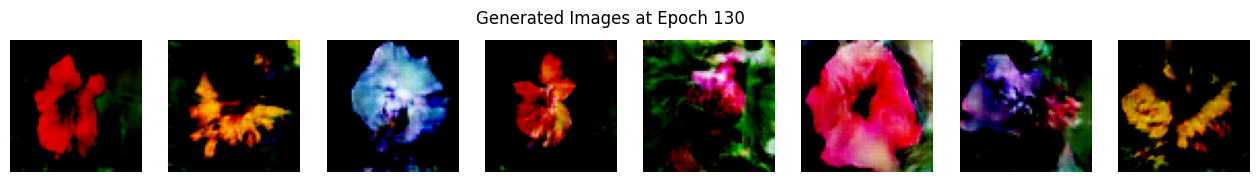

Epochs:  52%|█████▏    | 131/250 [50:26<46:10, 23.28s/it]

Epoch [131/250] Step [0] Discriminator Loss: 0.6848119795322418 Generator Loss: 0.5929560661315918
Epoch [131/250] Step [600] Discriminator Loss: 0.6820453703403473 Generator Loss: 0.6412662267684937
Epoch [131/250] Step [1200] Discriminator Loss: 0.7020892202854156 Generator Loss: 0.6204080581665039
Epoch [131/250] Step [1800] Discriminator Loss: 0.7015103995800018 Generator Loss: 0.6306867599487305
Epoch [131/250] Step [2400] Discriminator Loss: 0.6719187498092651 Generator Loss: 0.6627915501594543
Epoch [131/250] Step [3000] Discriminator Loss: 0.6728121936321259 Generator Loss: 0.6934986710548401
Epoch [131/250] Step [3600] Discriminator Loss: 0.6763991713523865 Generator Loss: 0.6335483193397522
Epoch [131/250] Step [4200] Discriminator Loss: 0.6767881512641907 Generator Loss: 0.6749479174613953
Epoch [131/250] Step [4800] Discriminator Loss: 0.6693522036075592 Generator Loss: 0.5829440951347351
Epoch [131/250] Step [5400] Discriminator Loss: 0.6662582159042358 Generator Loss: 0.6

Epochs:  53%|█████▎    | 132/250 [50:49<45:40, 23.23s/it]

Epoch [132/250] Step [0] Discriminator Loss: 0.6714793741703033 Generator Loss: 0.6612231731414795
Epoch [132/250] Step [600] Discriminator Loss: 0.6893143355846405 Generator Loss: 0.6684032678604126
Epoch [132/250] Step [1200] Discriminator Loss: 0.6733109354972839 Generator Loss: 0.6337801814079285
Epoch [132/250] Step [1800] Discriminator Loss: 0.6789429783821106 Generator Loss: 0.6118825674057007
Epoch [132/250] Step [2400] Discriminator Loss: 0.6759328842163086 Generator Loss: 0.6376769542694092
Epoch [132/250] Step [3000] Discriminator Loss: 0.6770815551280975 Generator Loss: 0.6150110363960266
Epoch [132/250] Step [3600] Discriminator Loss: 0.6727093458175659 Generator Loss: 0.616927444934845
Epoch [132/250] Step [4200] Discriminator Loss: 0.6735780239105225 Generator Loss: 0.630692183971405
Epoch [132/250] Step [4800] Discriminator Loss: 0.697078138589859 Generator Loss: 0.6240243911743164
Epoch [132/250] Step [5400] Discriminator Loss: 0.6710071265697479 Generator Loss: 0.6379

Epochs:  53%|█████▎    | 133/250 [51:12<45:13, 23.20s/it]

Epoch [133/250] Step [0] Discriminator Loss: 0.6653459370136261 Generator Loss: 0.6403359770774841
Epoch [133/250] Step [600] Discriminator Loss: 0.6761485934257507 Generator Loss: 0.6167048811912537
Epoch [133/250] Step [1200] Discriminator Loss: 0.6823429465293884 Generator Loss: 0.6606931686401367
Epoch [133/250] Step [1800] Discriminator Loss: 0.6875072121620178 Generator Loss: 0.6441167593002319
Epoch [133/250] Step [2400] Discriminator Loss: 0.6871543824672699 Generator Loss: 0.6442176103591919
Epoch [133/250] Step [3000] Discriminator Loss: 0.6786841750144958 Generator Loss: 0.6508583426475525
Epoch [133/250] Step [3600] Discriminator Loss: 0.6648035049438477 Generator Loss: 0.6434882283210754
Epoch [133/250] Step [4200] Discriminator Loss: 0.6698909103870392 Generator Loss: 0.6419200301170349
Epoch [133/250] Step [4800] Discriminator Loss: 0.6627578735351562 Generator Loss: 0.6209931969642639
Epoch [133/250] Step [5400] Discriminator Loss: 0.668069988489151 Generator Loss: 0.60

Epochs:  54%|█████▎    | 134/250 [51:36<44:47, 23.17s/it]

Epoch [134/250] Step [0] Discriminator Loss: 0.6768021881580353 Generator Loss: 0.6697809100151062
Epoch [134/250] Step [600] Discriminator Loss: 0.6671642363071442 Generator Loss: 0.6372403502464294
Epoch [134/250] Step [1200] Discriminator Loss: 0.6709138453006744 Generator Loss: 0.6758816838264465
Epoch [134/250] Step [1800] Discriminator Loss: 0.6867523193359375 Generator Loss: 0.6049332022666931
Epoch [134/250] Step [2400] Discriminator Loss: 0.6723251938819885 Generator Loss: 0.6136939525604248
Epoch [134/250] Step [3000] Discriminator Loss: 0.6829005479812622 Generator Loss: 0.6176297068595886
Epoch [134/250] Step [3600] Discriminator Loss: 0.6720241904258728 Generator Loss: 0.6556445360183716
Epoch [134/250] Step [4200] Discriminator Loss: 0.6862374544143677 Generator Loss: 0.6559068560600281
Epoch [134/250] Step [4800] Discriminator Loss: 0.6784789264202118 Generator Loss: 0.5654255151748657
Epoch [134/250] Step [5400] Discriminator Loss: 0.6897551417350769 Generator Loss: 0.6

Epochs:  54%|█████▍    | 135/250 [51:59<44:22, 23.15s/it]

Epoch [135/250] Step [0] Discriminator Loss: 0.6850647032260895 Generator Loss: 0.6227865815162659
Epoch [135/250] Step [600] Discriminator Loss: 0.6693039238452911 Generator Loss: 0.6325588226318359
Epoch [135/250] Step [1200] Discriminator Loss: 0.6654809415340424 Generator Loss: 0.6438565254211426
Epoch [135/250] Step [1800] Discriminator Loss: 0.6644901633262634 Generator Loss: 0.6597651839256287
Epoch [135/250] Step [2400] Discriminator Loss: 0.6675393879413605 Generator Loss: 0.6459575891494751
Epoch [135/250] Step [3000] Discriminator Loss: 0.6639082133769989 Generator Loss: 0.6575906872749329
Epoch [135/250] Step [3600] Discriminator Loss: 0.6684924364089966 Generator Loss: 0.6455395221710205
Epoch [135/250] Step [4200] Discriminator Loss: 0.6653955578804016 Generator Loss: 0.6096611618995667
Epoch [135/250] Step [4800] Discriminator Loss: 0.6653411388397217 Generator Loss: 0.6570335030555725
Epoch [135/250] Step [5400] Discriminator Loss: 0.6618578433990479 Generator Loss: 0.6

Epochs:  54%|█████▍    | 136/250 [52:22<43:58, 23.14s/it]

Epoch [136/250] Step [0] Discriminator Loss: 0.6710183322429657 Generator Loss: 0.600009024143219
Epoch [136/250] Step [600] Discriminator Loss: 0.665201872587204 Generator Loss: 0.5806244611740112
Epoch [136/250] Step [1200] Discriminator Loss: 0.6740382611751556 Generator Loss: 0.5942475199699402
Epoch [136/250] Step [1800] Discriminator Loss: 0.6634157001972198 Generator Loss: 0.6275876760482788
Epoch [136/250] Step [2400] Discriminator Loss: 0.6696634888648987 Generator Loss: 0.6302940845489502
Epoch [136/250] Step [3000] Discriminator Loss: 0.6733332872390747 Generator Loss: 0.6435331702232361
Epoch [136/250] Step [3600] Discriminator Loss: 0.6670406758785248 Generator Loss: 0.5929780602455139
Epoch [136/250] Step [4200] Discriminator Loss: 0.6669229865074158 Generator Loss: 0.6307432651519775
Epoch [136/250] Step [4800] Discriminator Loss: 0.6912499666213989 Generator Loss: 0.6476300954818726
Epoch [136/250] Step [5400] Discriminator Loss: 0.6646745204925537 Generator Loss: 0.673

Epochs:  55%|█████▍    | 137/250 [52:45<43:33, 23.13s/it]

Epoch [137/250] Step [0] Discriminator Loss: 0.6726991534233093 Generator Loss: 0.6033360362052917
Epoch [137/250] Step [600] Discriminator Loss: 0.662381649017334 Generator Loss: 0.6368041634559631
Epoch [137/250] Step [1200] Discriminator Loss: 0.6577810347080231 Generator Loss: 0.6104199290275574
Epoch [137/250] Step [1800] Discriminator Loss: 0.6846125423908234 Generator Loss: 0.6531509160995483
Epoch [137/250] Step [2400] Discriminator Loss: 0.6643894612789154 Generator Loss: 0.6596157550811768
Epoch [137/250] Step [3000] Discriminator Loss: 0.6794461011886597 Generator Loss: 0.6298086643218994
Epoch [137/250] Step [3600] Discriminator Loss: 0.6670238971710205 Generator Loss: 0.6304653882980347
Epoch [137/250] Step [4200] Discriminator Loss: 0.6741501688957214 Generator Loss: 0.6588830947875977
Epoch [137/250] Step [4800] Discriminator Loss: 0.6712989509105682 Generator Loss: 0.5890358686447144
Epoch [137/250] Step [5400] Discriminator Loss: 0.6702899634838104 Generator Loss: 0.64

Epochs:  55%|█████▌    | 138/250 [53:08<43:10, 23.13s/it]

Epoch [138/250] Step [0] Discriminator Loss: 0.6642463803291321 Generator Loss: 0.6304964423179626
Epoch [138/250] Step [600] Discriminator Loss: 0.6769405007362366 Generator Loss: 0.650023877620697
Epoch [138/250] Step [1200] Discriminator Loss: 0.685481458902359 Generator Loss: 0.6539735198020935
Epoch [138/250] Step [1800] Discriminator Loss: 0.6823438107967377 Generator Loss: 0.633800208568573
Epoch [138/250] Step [2400] Discriminator Loss: 0.6710699200630188 Generator Loss: 0.632800817489624
Epoch [138/250] Step [3000] Discriminator Loss: 0.6775087416172028 Generator Loss: 0.6250199675559998
Epoch [138/250] Step [3600] Discriminator Loss: 0.6780918538570404 Generator Loss: 0.6589997410774231
Epoch [138/250] Step [4200] Discriminator Loss: 0.6728668510913849 Generator Loss: 0.6617096662521362
Epoch [138/250] Step [4800] Discriminator Loss: 0.6857346892356873 Generator Loss: 0.6015598177909851
Epoch [138/250] Step [5400] Discriminator Loss: 0.6754373013973236 Generator Loss: 0.65392

Epochs:  56%|█████▌    | 139/250 [53:31<42:47, 23.13s/it]

Epoch [139/250] Step [0] Discriminator Loss: 0.6870284378528595 Generator Loss: 0.6667178869247437
Epoch [139/250] Step [600] Discriminator Loss: 0.6798934042453766 Generator Loss: 0.6413883566856384
Epoch [139/250] Step [1200] Discriminator Loss: 0.7026997208595276 Generator Loss: 0.6188844442367554
Epoch [139/250] Step [1800] Discriminator Loss: 0.6716007590293884 Generator Loss: 0.6872940063476562
Epoch [139/250] Step [2400] Discriminator Loss: 0.671525239944458 Generator Loss: 0.6318711042404175
Epoch [139/250] Step [3000] Discriminator Loss: 0.6892932951450348 Generator Loss: 0.6175559759140015
Epoch [139/250] Step [3600] Discriminator Loss: 0.6958735585212708 Generator Loss: 0.6203271746635437
Epoch [139/250] Step [4200] Discriminator Loss: 0.6775836944580078 Generator Loss: 0.6227208375930786
Epoch [139/250] Step [4800] Discriminator Loss: 0.6799749433994293 Generator Loss: 0.5650152564048767
Epoch [139/250] Step [5400] Discriminator Loss: 0.6725769937038422 Generator Loss: 0.66

Epochs:  56%|█████▌    | 140/250 [53:54<42:23, 23.13s/it]

Epoch [140/250] Step [0] Discriminator Loss: 0.6834543645381927 Generator Loss: 0.6119625568389893
Epoch [140/250] Step [600] Discriminator Loss: 0.6817261874675751 Generator Loss: 0.6509791016578674
Epoch [140/250] Step [1200] Discriminator Loss: 0.6773585975170135 Generator Loss: 0.6453165411949158
Epoch [140/250] Step [1800] Discriminator Loss: 0.6867004632949829 Generator Loss: 0.6470046639442444
Epoch [140/250] Step [2400] Discriminator Loss: 0.6767451465129852 Generator Loss: 0.6555309891700745
Epoch [140/250] Step [3000] Discriminator Loss: 0.6833870112895966 Generator Loss: 0.6071171760559082
Epoch [140/250] Step [3600] Discriminator Loss: 0.7091671526432037 Generator Loss: 0.6055527329444885
Epoch [140/250] Step [4200] Discriminator Loss: 0.7074428498744965 Generator Loss: 0.5876306295394897
Epoch [140/250] Step [4800] Discriminator Loss: 0.6922957599163055 Generator Loss: 0.5804318785667419
Epoch [140/250] Step [5400] Discriminator Loss: 0.6786079704761505 Generator Loss: 0.6

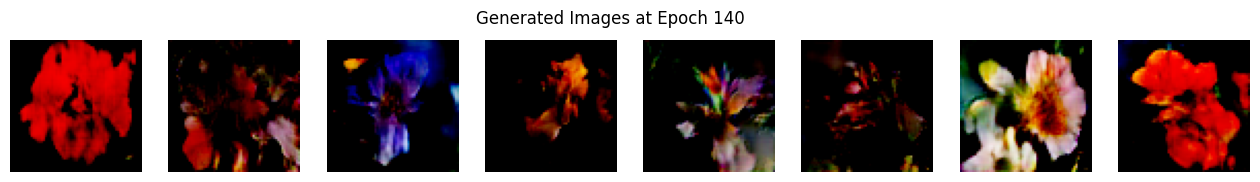

Epochs:  56%|█████▋    | 141/250 [54:18<42:32, 23.41s/it]

Epoch [141/250] Step [0] Discriminator Loss: 0.6715189218521118 Generator Loss: 0.6346362233161926
Epoch [141/250] Step [600] Discriminator Loss: 0.6905933618545532 Generator Loss: 0.6241224408149719
Epoch [141/250] Step [1200] Discriminator Loss: 0.6961862444877625 Generator Loss: 0.6426264047622681
Epoch [141/250] Step [1800] Discriminator Loss: 0.6829231083393097 Generator Loss: 0.6291213035583496
Epoch [141/250] Step [2400] Discriminator Loss: 0.6739329695701599 Generator Loss: 0.6815491318702698
Epoch [141/250] Step [3000] Discriminator Loss: 0.668567419052124 Generator Loss: 0.6406949758529663
Epoch [141/250] Step [3600] Discriminator Loss: 0.6916097104549408 Generator Loss: 0.6543524265289307
Epoch [141/250] Step [4200] Discriminator Loss: 0.7198327779769897 Generator Loss: 0.56690514087677
Epoch [141/250] Step [4800] Discriminator Loss: 0.6875405609607697 Generator Loss: 0.6541767716407776
Epoch [141/250] Step [5400] Discriminator Loss: 0.6734437346458435 Generator Loss: 0.6527

Epochs:  57%|█████▋    | 142/250 [54:41<41:58, 23.32s/it]

Epoch [142/250] Step [0] Discriminator Loss: 0.6665678024291992 Generator Loss: 0.6365677118301392
Epoch [142/250] Step [600] Discriminator Loss: 0.6753212809562683 Generator Loss: 0.6369202136993408
Epoch [142/250] Step [1200] Discriminator Loss: 0.6653389930725098 Generator Loss: 0.6504310965538025
Epoch [142/250] Step [1800] Discriminator Loss: 0.6663171350955963 Generator Loss: 0.6500104665756226
Epoch [142/250] Step [2400] Discriminator Loss: 0.667050302028656 Generator Loss: 0.6499286890029907
Epoch [142/250] Step [3000] Discriminator Loss: 0.6962850689888 Generator Loss: 0.6388572454452515
Epoch [142/250] Step [3600] Discriminator Loss: 0.6760849058628082 Generator Loss: 0.644496738910675
Epoch [142/250] Step [4200] Discriminator Loss: 0.682078093290329 Generator Loss: 0.6766319274902344
Epoch [142/250] Step [4800] Discriminator Loss: 0.6794076859951019 Generator Loss: 0.6341767311096191
Epoch [142/250] Step [5400] Discriminator Loss: 0.6901925206184387 Generator Loss: 0.6092584

Epochs:  57%|█████▋    | 143/250 [55:05<41:29, 23.26s/it]

Epoch [143/250] Step [0] Discriminator Loss: 0.6725343465805054 Generator Loss: 0.6285788416862488
Epoch [143/250] Step [600] Discriminator Loss: 0.6734170317649841 Generator Loss: 0.6447383761405945
Epoch [143/250] Step [1200] Discriminator Loss: 0.6645217835903168 Generator Loss: 0.6321125030517578
Epoch [143/250] Step [1800] Discriminator Loss: 0.6748971045017242 Generator Loss: 0.6407991051673889
Epoch [143/250] Step [2400] Discriminator Loss: 0.6771909296512604 Generator Loss: 0.6567785739898682
Epoch [143/250] Step [3000] Discriminator Loss: 0.6805748343467712 Generator Loss: 0.6570704579353333
Epoch [143/250] Step [3600] Discriminator Loss: 0.6632102727890015 Generator Loss: 0.60362309217453
Epoch [143/250] Step [4200] Discriminator Loss: 0.6779166162014008 Generator Loss: 0.653798520565033
Epoch [143/250] Step [4800] Discriminator Loss: 0.6685384809970856 Generator Loss: 0.6643000841140747
Epoch [143/250] Step [5400] Discriminator Loss: 0.6911429762840271 Generator Loss: 0.6222

Epochs:  58%|█████▊    | 144/250 [55:28<41:00, 23.22s/it]

Epoch [144/250] Step [0] Discriminator Loss: 0.6647171080112457 Generator Loss: 0.6688172817230225
Epoch [144/250] Step [600] Discriminator Loss: 0.673884779214859 Generator Loss: 0.5996198654174805
Epoch [144/250] Step [1200] Discriminator Loss: 0.6719830632209778 Generator Loss: 0.6216961741447449
Epoch [144/250] Step [1800] Discriminator Loss: 0.6686240434646606 Generator Loss: 0.6713549494743347
Epoch [144/250] Step [2400] Discriminator Loss: 0.6719718277454376 Generator Loss: 0.6073639392852783
Epoch [144/250] Step [3000] Discriminator Loss: 0.6646268367767334 Generator Loss: 0.645744264125824
Epoch [144/250] Step [3600] Discriminator Loss: 0.6737341582775116 Generator Loss: 0.6494328379631042
Epoch [144/250] Step [4200] Discriminator Loss: 0.6704339683055878 Generator Loss: 0.6467095613479614
Epoch [144/250] Step [4800] Discriminator Loss: 0.6662648916244507 Generator Loss: 0.6337005496025085
Epoch [144/250] Step [5400] Discriminator Loss: 0.6695218086242676 Generator Loss: 0.609

Epochs:  58%|█████▊    | 145/250 [55:51<40:33, 23.18s/it]

Epoch [145/250] Step [0] Discriminator Loss: 0.6751815676689148 Generator Loss: 0.6315019130706787
Epoch [145/250] Step [600] Discriminator Loss: 0.6661750972270966 Generator Loss: 0.6045082807540894
Epoch [145/250] Step [1200] Discriminator Loss: 0.6720040440559387 Generator Loss: 0.6513556838035583
Epoch [145/250] Step [1800] Discriminator Loss: 0.6638448238372803 Generator Loss: 0.6506211757659912
Epoch [145/250] Step [2400] Discriminator Loss: 0.6762031614780426 Generator Loss: 0.6240510940551758
Epoch [145/250] Step [3000] Discriminator Loss: 0.6616200506687164 Generator Loss: 0.6325803995132446
Epoch [145/250] Step [3600] Discriminator Loss: 0.6657283306121826 Generator Loss: 0.6301409006118774
Epoch [145/250] Step [4200] Discriminator Loss: 0.6962115466594696 Generator Loss: 0.62173992395401
Epoch [145/250] Step [4800] Discriminator Loss: 0.6733002960681915 Generator Loss: 0.6305273175239563
Epoch [145/250] Step [5400] Discriminator Loss: 0.6832104325294495 Generator Loss: 0.614

Epochs:  58%|█████▊    | 146/250 [56:14<40:07, 23.15s/it]

Epoch [146/250] Step [0] Discriminator Loss: 0.6613553166389465 Generator Loss: 0.6556402444839478
Epoch [146/250] Step [600] Discriminator Loss: 0.6620627045631409 Generator Loss: 0.5990507006645203
Epoch [146/250] Step [1200] Discriminator Loss: 0.6698791980743408 Generator Loss: 0.659286618232727
Epoch [146/250] Step [1800] Discriminator Loss: 0.661390483379364 Generator Loss: 0.5961512923240662
Epoch [146/250] Step [2400] Discriminator Loss: 0.6698477268218994 Generator Loss: 0.6554528474807739
Epoch [146/250] Step [3000] Discriminator Loss: 0.6785522997379303 Generator Loss: 0.6440640687942505
Epoch [146/250] Step [3600] Discriminator Loss: 0.678593784570694 Generator Loss: 0.6758070588111877
Epoch [146/250] Step [4200] Discriminator Loss: 0.6929500699043274 Generator Loss: 0.658658504486084
Epoch [146/250] Step [4800] Discriminator Loss: 0.6767999231815338 Generator Loss: 0.6307685971260071
Epoch [146/250] Step [5400] Discriminator Loss: 0.6785328984260559 Generator Loss: 0.61563

Epochs:  59%|█████▉    | 147/250 [56:37<39:41, 23.12s/it]

Epoch [147/250] Step [0] Discriminator Loss: 0.683569610118866 Generator Loss: 0.6719267964363098
Epoch [147/250] Step [600] Discriminator Loss: 0.671345055103302 Generator Loss: 0.6722479462623596
Epoch [147/250] Step [1200] Discriminator Loss: 0.6666101515293121 Generator Loss: 0.6206945180892944
Epoch [147/250] Step [1800] Discriminator Loss: 0.674220621585846 Generator Loss: 0.5971226692199707
Epoch [147/250] Step [2400] Discriminator Loss: 0.6776294708251953 Generator Loss: 0.6394028663635254
Epoch [147/250] Step [3000] Discriminator Loss: 0.7099226415157318 Generator Loss: 0.6690076589584351
Epoch [147/250] Step [3600] Discriminator Loss: 0.6727401316165924 Generator Loss: 0.6472415328025818
Epoch [147/250] Step [4200] Discriminator Loss: 0.6933318972587585 Generator Loss: 0.6719944477081299
Epoch [147/250] Step [4800] Discriminator Loss: 0.682096004486084 Generator Loss: 0.659213125705719
Epoch [147/250] Step [5400] Discriminator Loss: 0.6982760727405548 Generator Loss: 0.653958

Epochs:  59%|█████▉    | 148/250 [57:00<39:17, 23.11s/it]

Epoch [148/250] Step [0] Discriminator Loss: 0.6894589066505432 Generator Loss: 0.6824920773506165
Epoch [148/250] Step [600] Discriminator Loss: 0.6726256310939789 Generator Loss: 0.5932272672653198
Epoch [148/250] Step [1200] Discriminator Loss: 0.6690964996814728 Generator Loss: 0.6193065643310547
Epoch [148/250] Step [1800] Discriminator Loss: 0.6983632743358612 Generator Loss: 0.6602256894111633
Epoch [148/250] Step [2400] Discriminator Loss: 0.6779252886772156 Generator Loss: 0.6507485508918762
Epoch [148/250] Step [3000] Discriminator Loss: 0.6732097268104553 Generator Loss: 0.6421821117401123
Epoch [148/250] Step [3600] Discriminator Loss: 0.686055988073349 Generator Loss: 0.6233775019645691
Epoch [148/250] Step [4200] Discriminator Loss: 0.6948664486408234 Generator Loss: 0.6578195095062256
Epoch [148/250] Step [4800] Discriminator Loss: 0.6654244065284729 Generator Loss: 0.6540682315826416
Epoch [148/250] Step [5400] Discriminator Loss: 0.6666792035102844 Generator Loss: 0.64

Epochs:  60%|█████▉    | 149/250 [57:23<38:53, 23.11s/it]

Epoch [149/250] Step [0] Discriminator Loss: 0.6642860174179077 Generator Loss: 0.6345798373222351
Epoch [149/250] Step [600] Discriminator Loss: 0.670073002576828 Generator Loss: 0.6099847555160522
Epoch [149/250] Step [1200] Discriminator Loss: 0.6715373694896698 Generator Loss: 0.637035071849823
Epoch [149/250] Step [1800] Discriminator Loss: 0.6694737076759338 Generator Loss: 0.6656494736671448
Epoch [149/250] Step [2400] Discriminator Loss: 0.6791276931762695 Generator Loss: 0.6260804533958435
Epoch [149/250] Step [3000] Discriminator Loss: 0.6758954524993896 Generator Loss: 0.6499664783477783
Epoch [149/250] Step [3600] Discriminator Loss: 0.6762868165969849 Generator Loss: 0.640760600566864
Epoch [149/250] Step [4200] Discriminator Loss: 0.6811693906784058 Generator Loss: 0.6393260955810547
Epoch [149/250] Step [4800] Discriminator Loss: 0.6689330041408539 Generator Loss: 0.6666885018348694
Epoch [149/250] Step [5400] Discriminator Loss: 0.6605978012084961 Generator Loss: 0.6579

Epochs:  60%|██████    | 150/250 [57:46<38:28, 23.08s/it]

Epoch [150/250] Step [0] Discriminator Loss: 0.6819999516010284 Generator Loss: 0.6399897336959839
Epoch [150/250] Step [600] Discriminator Loss: 0.6920812129974365 Generator Loss: 0.5770873427391052
Epoch [150/250] Step [1200] Discriminator Loss: 0.6745191216468811 Generator Loss: 0.628713071346283
Epoch [150/250] Step [1800] Discriminator Loss: 0.6701548993587494 Generator Loss: 0.6413958668708801
Epoch [150/250] Step [2400] Discriminator Loss: 0.6826310157775879 Generator Loss: 0.677837073802948
Epoch [150/250] Step [3000] Discriminator Loss: 0.6751793920993805 Generator Loss: 0.62278151512146
Epoch [150/250] Step [3600] Discriminator Loss: 0.6752385497093201 Generator Loss: 0.6135044097900391
Epoch [150/250] Step [4200] Discriminator Loss: 0.6634433567523956 Generator Loss: 0.610137939453125
Epoch [150/250] Step [4800] Discriminator Loss: 0.6652468144893646 Generator Loss: 0.6136770248413086
Epoch [150/250] Step [5400] Discriminator Loss: 0.664898157119751 Generator Loss: 0.6654960

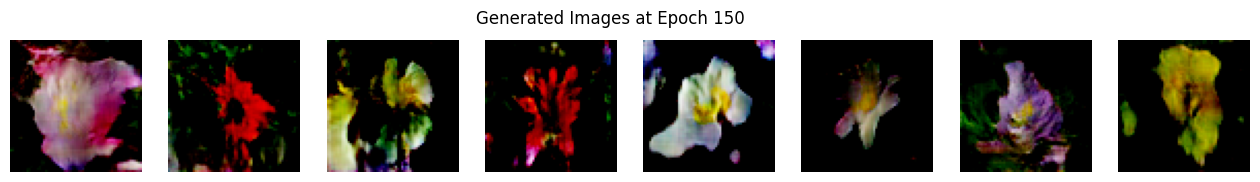

Epochs:  60%|██████    | 151/250 [58:10<38:19, 23.22s/it]

Epoch [151/250] Step [0] Discriminator Loss: 0.6664118766784668 Generator Loss: 0.6496008038520813
Epoch [151/250] Step [600] Discriminator Loss: 0.6765936613082886 Generator Loss: 0.6376140117645264
Epoch [151/250] Step [1200] Discriminator Loss: 0.6673029959201813 Generator Loss: 0.6257669925689697
Epoch [151/250] Step [1800] Discriminator Loss: 0.674869030714035 Generator Loss: 0.6568349599838257
Epoch [151/250] Step [2400] Discriminator Loss: 0.6756846308708191 Generator Loss: 0.6359630227088928
Epoch [151/250] Step [3000] Discriminator Loss: 0.6949862241744995 Generator Loss: 0.6342858672142029
Epoch [151/250] Step [3600] Discriminator Loss: 0.6786171495914459 Generator Loss: 0.6470362544059753
Epoch [151/250] Step [4200] Discriminator Loss: 0.6677093505859375 Generator Loss: 0.5962676405906677
Epoch [151/250] Step [4800] Discriminator Loss: 0.6968953013420105 Generator Loss: 0.6512067317962646
Epoch [151/250] Step [5400] Discriminator Loss: 0.6768143177032471 Generator Loss: 0.61

Epochs:  61%|██████    | 152/250 [58:33<37:49, 23.16s/it]

Epoch [152/250] Step [0] Discriminator Loss: 0.6820337474346161 Generator Loss: 0.6536191701889038
Epoch [152/250] Step [600] Discriminator Loss: 0.6733478307723999 Generator Loss: 0.5983203053474426
Epoch [152/250] Step [1200] Discriminator Loss: 0.6695180535316467 Generator Loss: 0.6258325576782227
Epoch [152/250] Step [1800] Discriminator Loss: 0.6703214049339294 Generator Loss: 0.6494640707969666
Epoch [152/250] Step [2400] Discriminator Loss: 0.66294726729393 Generator Loss: 0.6611264944076538
Epoch [152/250] Step [3000] Discriminator Loss: 0.6649017035961151 Generator Loss: 0.6287493109703064
Epoch [152/250] Step [3600] Discriminator Loss: 0.6744278371334076 Generator Loss: 0.6347662806510925
Epoch [152/250] Step [4200] Discriminator Loss: 0.6631084680557251 Generator Loss: 0.6467005610466003
Epoch [152/250] Step [4800] Discriminator Loss: 0.6688085496425629 Generator Loss: 0.6508291363716125
Epoch [152/250] Step [5400] Discriminator Loss: 0.6662611961364746 Generator Loss: 0.651

Epochs:  61%|██████    | 153/250 [58:56<37:23, 23.13s/it]

Epoch [153/250] Step [0] Discriminator Loss: 0.6648612320423126 Generator Loss: 0.6131852865219116
Epoch [153/250] Step [600] Discriminator Loss: 0.6645428240299225 Generator Loss: 0.6513296365737915
Epoch [153/250] Step [1200] Discriminator Loss: 0.6689030230045319 Generator Loss: 0.6400711536407471
Epoch [153/250] Step [1800] Discriminator Loss: 0.6645875573158264 Generator Loss: 0.6434808969497681
Epoch [153/250] Step [2400] Discriminator Loss: 0.6813054084777832 Generator Loss: 0.5786595940589905
Epoch [153/250] Step [3000] Discriminator Loss: 0.6581583321094513 Generator Loss: 0.6522095799446106
Epoch [153/250] Step [3600] Discriminator Loss: 0.6704113483428955 Generator Loss: 0.5866575837135315
Epoch [153/250] Step [4200] Discriminator Loss: 0.673895001411438 Generator Loss: 0.6201108694076538
Epoch [153/250] Step [4800] Discriminator Loss: 0.6662969291210175 Generator Loss: 0.6470975875854492
Epoch [153/250] Step [5400] Discriminator Loss: 0.6792234778404236 Generator Loss: 0.63

Epochs:  62%|██████▏   | 154/250 [59:19<36:58, 23.11s/it]

Epoch [154/250] Step [0] Discriminator Loss: 0.6633879542350769 Generator Loss: 0.6520436406135559
Epoch [154/250] Step [600] Discriminator Loss: 0.6727113723754883 Generator Loss: 0.6660003066062927
Epoch [154/250] Step [1200] Discriminator Loss: 0.672921746969223 Generator Loss: 0.6250938177108765
Epoch [154/250] Step [1800] Discriminator Loss: 0.6696266829967499 Generator Loss: 0.650185763835907
Epoch [154/250] Step [2400] Discriminator Loss: 0.6834041178226471 Generator Loss: 0.6683134436607361
Epoch [154/250] Step [3000] Discriminator Loss: 0.6843360066413879 Generator Loss: 0.6209560036659241
Epoch [154/250] Step [3600] Discriminator Loss: 0.6658958792686462 Generator Loss: 0.6243550777435303
Epoch [154/250] Step [4200] Discriminator Loss: 0.6827296912670135 Generator Loss: 0.6825569868087769
Epoch [154/250] Step [4800] Discriminator Loss: 0.6735765635967255 Generator Loss: 0.6335474252700806
Epoch [154/250] Step [5400] Discriminator Loss: 0.6747601926326752 Generator Loss: 0.620

Epochs:  62%|██████▏   | 155/250 [59:42<36:33, 23.09s/it]

Epoch [155/250] Step [0] Discriminator Loss: 0.6812279224395752 Generator Loss: 0.5897732973098755
Epoch [155/250] Step [600] Discriminator Loss: 0.6862077116966248 Generator Loss: 0.6315580010414124
Epoch [155/250] Step [1200] Discriminator Loss: 0.6914315819740295 Generator Loss: 0.6200827956199646
Epoch [155/250] Step [1800] Discriminator Loss: 0.6883699595928192 Generator Loss: 0.6098054647445679
Epoch [155/250] Step [2400] Discriminator Loss: 0.6843936145305634 Generator Loss: 0.6381210684776306
Epoch [155/250] Step [3000] Discriminator Loss: 0.6747218072414398 Generator Loss: 0.6283128261566162
Epoch [155/250] Step [3600] Discriminator Loss: 0.6882597804069519 Generator Loss: 0.6053854823112488
Epoch [155/250] Step [4200] Discriminator Loss: 0.6814607977867126 Generator Loss: 0.622522234916687
Epoch [155/250] Step [4800] Discriminator Loss: 0.669403463602066 Generator Loss: 0.612612783908844
Epoch [155/250] Step [5400] Discriminator Loss: 0.7040574550628662 Generator Loss: 0.6541

Epochs:  62%|██████▏   | 156/250 [1:00:05<36:08, 23.07s/it]

Epoch [156/250] Step [0] Discriminator Loss: 0.6761895418167114 Generator Loss: 0.638557493686676
Epoch [156/250] Step [600] Discriminator Loss: 0.7048317492008209 Generator Loss: 0.6768338084220886
Epoch [156/250] Step [1200] Discriminator Loss: 0.6781921982765198 Generator Loss: 0.6130590438842773
Epoch [156/250] Step [1800] Discriminator Loss: 0.6710844337940216 Generator Loss: 0.6053006052970886
Epoch [156/250] Step [2400] Discriminator Loss: 0.6958090960979462 Generator Loss: 0.6571614742279053
Epoch [156/250] Step [3000] Discriminator Loss: 0.6623428463935852 Generator Loss: 0.6062195301055908
Epoch [156/250] Step [3600] Discriminator Loss: 0.6661064028739929 Generator Loss: 0.632186770439148
Epoch [156/250] Step [4200] Discriminator Loss: 0.6807360351085663 Generator Loss: 0.6601905822753906
Epoch [156/250] Step [4800] Discriminator Loss: 0.6904965937137604 Generator Loss: 0.6523351073265076
Epoch [156/250] Step [5400] Discriminator Loss: 0.6763939261436462 Generator Loss: 0.656

Epochs:  63%|██████▎   | 157/250 [1:00:28<35:44, 23.06s/it]

Epoch [157/250] Step [0] Discriminator Loss: 0.6733041107654572 Generator Loss: 0.6623204350471497
Epoch [157/250] Step [600] Discriminator Loss: 0.6647249758243561 Generator Loss: 0.6646872758865356
Epoch [157/250] Step [1200] Discriminator Loss: 0.6765664219856262 Generator Loss: 0.6363674998283386
Epoch [157/250] Step [1800] Discriminator Loss: 0.6940999031066895 Generator Loss: 0.6521751284599304
Epoch [157/250] Step [2400] Discriminator Loss: 0.6718170046806335 Generator Loss: 0.6633108258247375
Epoch [157/250] Step [3000] Discriminator Loss: 0.6642650961875916 Generator Loss: 0.6228031516075134
Epoch [157/250] Step [3600] Discriminator Loss: 0.6767975687980652 Generator Loss: 0.6388137936592102
Epoch [157/250] Step [4200] Discriminator Loss: 0.6665697395801544 Generator Loss: 0.6626461148262024
Epoch [157/250] Step [4800] Discriminator Loss: 0.6710185408592224 Generator Loss: 0.6089143753051758
Epoch [157/250] Step [5400] Discriminator Loss: 0.6635279655456543 Generator Loss: 0.6

Epochs:  63%|██████▎   | 158/250 [1:00:51<35:18, 23.03s/it]

Epoch [158/250] Step [0] Discriminator Loss: 0.67844557762146 Generator Loss: 0.6477745771408081
Epoch [158/250] Step [600] Discriminator Loss: 0.6875419616699219 Generator Loss: 0.6140211224555969
Epoch [158/250] Step [1200] Discriminator Loss: 0.6601040363311768 Generator Loss: 0.6516993045806885
Epoch [158/250] Step [1800] Discriminator Loss: 0.6659740209579468 Generator Loss: 0.6380468010902405
Epoch [158/250] Step [2400] Discriminator Loss: 0.6689614355564117 Generator Loss: 0.644943118095398
Epoch [158/250] Step [3000] Discriminator Loss: 0.6811928153038025 Generator Loss: 0.6423362493515015
Epoch [158/250] Step [3600] Discriminator Loss: 0.6776992678642273 Generator Loss: 0.6810024976730347
Epoch [158/250] Step [4200] Discriminator Loss: 0.6593187749385834 Generator Loss: 0.5682991147041321
Epoch [158/250] Step [4800] Discriminator Loss: 0.6790665090084076 Generator Loss: 0.6433247923851013
Epoch [158/250] Step [5400] Discriminator Loss: 0.6836880147457123 Generator Loss: 0.6406

Epochs:  64%|██████▎   | 159/250 [1:01:14<34:54, 23.01s/it]

Epoch [159/250] Step [0] Discriminator Loss: 0.6639438569545746 Generator Loss: 0.5983120203018188
Epoch [159/250] Step [600] Discriminator Loss: 0.7146449983119965 Generator Loss: 0.5664594769477844
Epoch [159/250] Step [1200] Discriminator Loss: 0.6753811240196228 Generator Loss: 0.6580366492271423
Epoch [159/250] Step [1800] Discriminator Loss: 0.6719637811183929 Generator Loss: 0.6506420373916626
Epoch [159/250] Step [2400] Discriminator Loss: 0.6679366528987885 Generator Loss: 0.6514595150947571
Epoch [159/250] Step [3000] Discriminator Loss: 0.6885155439376831 Generator Loss: 0.658615231513977
Epoch [159/250] Step [3600] Discriminator Loss: 0.662390947341919 Generator Loss: 0.6599932312965393
Epoch [159/250] Step [4200] Discriminator Loss: 0.6647935211658478 Generator Loss: 0.6319419741630554
Epoch [159/250] Step [4800] Discriminator Loss: 0.6670168340206146 Generator Loss: 0.657404363155365
Epoch [159/250] Step [5400] Discriminator Loss: 0.6587054133415222 Generator Loss: 0.6379

Epochs:  64%|██████▍   | 160/250 [1:01:37<34:30, 23.00s/it]

Epoch [160/250] Step [0] Discriminator Loss: 0.6721759736537933 Generator Loss: 0.630181074142456
Epoch [160/250] Step [600] Discriminator Loss: 0.6674402058124542 Generator Loss: 0.6665403842926025
Epoch [160/250] Step [1200] Discriminator Loss: 0.6877681612968445 Generator Loss: 0.6189190745353699
Epoch [160/250] Step [1800] Discriminator Loss: 0.6709179878234863 Generator Loss: 0.6096999645233154
Epoch [160/250] Step [2400] Discriminator Loss: 0.6903093755245209 Generator Loss: 0.6249355673789978
Epoch [160/250] Step [3000] Discriminator Loss: 0.6913379728794098 Generator Loss: 0.6754012107849121
Epoch [160/250] Step [3600] Discriminator Loss: 0.6621948480606079 Generator Loss: 0.6491825580596924
Epoch [160/250] Step [4200] Discriminator Loss: 0.6714607179164886 Generator Loss: 0.5841794013977051
Epoch [160/250] Step [4800] Discriminator Loss: 0.6823073327541351 Generator Loss: 0.639884889125824
Epoch [160/250] Step [5400] Discriminator Loss: 0.6722458600997925 Generator Loss: 0.626

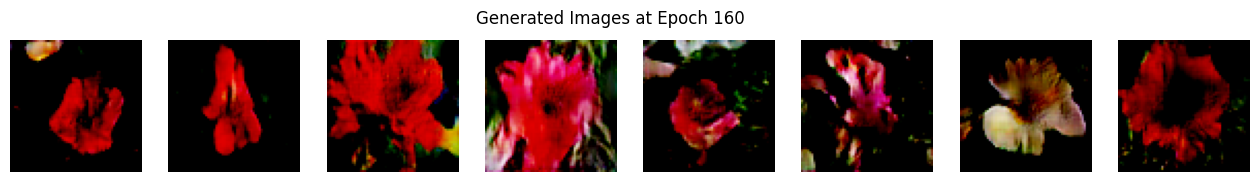

Epochs:  64%|██████▍   | 161/250 [1:02:00<34:23, 23.18s/it]

Epoch [161/250] Step [0] Discriminator Loss: 0.6652880311012268 Generator Loss: 0.6455169320106506
Epoch [161/250] Step [600] Discriminator Loss: 0.680707722902298 Generator Loss: 0.6648522615432739
Epoch [161/250] Step [1200] Discriminator Loss: 0.6821539103984833 Generator Loss: 0.6433022022247314
Epoch [161/250] Step [1800] Discriminator Loss: 0.66834756731987 Generator Loss: 0.6161105632781982
Epoch [161/250] Step [2400] Discriminator Loss: 0.6687475442886353 Generator Loss: 0.6427690386772156
Epoch [161/250] Step [3000] Discriminator Loss: 0.6923209130764008 Generator Loss: 0.5977159738540649
Epoch [161/250] Step [3600] Discriminator Loss: 0.6873102784156799 Generator Loss: 0.6327477097511292
Epoch [161/250] Step [4200] Discriminator Loss: 0.6788740158081055 Generator Loss: 0.6807242035865784
Epoch [161/250] Step [4800] Discriminator Loss: 0.6842640340328217 Generator Loss: 0.6412037014961243
Epoch [161/250] Step [5400] Discriminator Loss: 0.668328583240509 Generator Loss: 0.62937

Epochs:  65%|██████▍   | 162/250 [1:02:23<33:56, 23.14s/it]

Epoch [162/250] Step [0] Discriminator Loss: 0.6730769872665405 Generator Loss: 0.6455938816070557
Epoch [162/250] Step [600] Discriminator Loss: 0.6629746556282043 Generator Loss: 0.6612714529037476
Epoch [162/250] Step [1200] Discriminator Loss: 0.6708591282367706 Generator Loss: 0.6272761821746826
Epoch [162/250] Step [1800] Discriminator Loss: 0.6673385202884674 Generator Loss: 0.6554258465766907
Epoch [162/250] Step [2400] Discriminator Loss: 0.6687615215778351 Generator Loss: 0.6365981698036194
Epoch [162/250] Step [3000] Discriminator Loss: 0.666085809469223 Generator Loss: 0.6323290467262268
Epoch [162/250] Step [3600] Discriminator Loss: 0.661228746175766 Generator Loss: 0.6351975798606873
Epoch [162/250] Step [4200] Discriminator Loss: 0.6583525538444519 Generator Loss: 0.6304721236228943
Epoch [162/250] Step [4800] Discriminator Loss: 0.6723608076572418 Generator Loss: 0.5973476767539978
Epoch [162/250] Step [5400] Discriminator Loss: 0.659100353717804 Generator Loss: 0.6097

Epochs:  65%|██████▌   | 163/250 [1:02:46<33:29, 23.10s/it]

Epoch [163/250] Step [0] Discriminator Loss: 0.6623575389385223 Generator Loss: 0.6502293348312378
Epoch [163/250] Step [600] Discriminator Loss: 0.6758831739425659 Generator Loss: 0.6188340783119202
Epoch [163/250] Step [1200] Discriminator Loss: 0.6675569415092468 Generator Loss: 0.66224604845047
Epoch [163/250] Step [1800] Discriminator Loss: 0.6816146671772003 Generator Loss: 0.6200124621391296
Epoch [163/250] Step [2400] Discriminator Loss: 0.662117213010788 Generator Loss: 0.6534314751625061
Epoch [163/250] Step [3000] Discriminator Loss: 0.6699177920818329 Generator Loss: 0.6673877239227295
Epoch [163/250] Step [3600] Discriminator Loss: 0.6662670969963074 Generator Loss: 0.6492701172828674
Epoch [163/250] Step [4200] Discriminator Loss: 0.6610306799411774 Generator Loss: 0.6181796193122864
Epoch [163/250] Step [4800] Discriminator Loss: 0.664491593837738 Generator Loss: 0.6328184604644775
Epoch [163/250] Step [5400] Discriminator Loss: 0.6684946715831757 Generator Loss: 0.65751

Epochs:  66%|██████▌   | 164/250 [1:03:09<33:04, 23.07s/it]

Epoch [164/250] Step [0] Discriminator Loss: 0.6656967997550964 Generator Loss: 0.6352717280387878
Epoch [164/250] Step [600] Discriminator Loss: 0.6641553342342377 Generator Loss: 0.6395145058631897
Epoch [164/250] Step [1200] Discriminator Loss: 0.6596458256244659 Generator Loss: 0.6526402831077576
Epoch [164/250] Step [1800] Discriminator Loss: 0.6756263375282288 Generator Loss: 0.5970064401626587
Epoch [164/250] Step [2400] Discriminator Loss: 0.6641483306884766 Generator Loss: 0.6510829329490662
Epoch [164/250] Step [3000] Discriminator Loss: 0.6682692170143127 Generator Loss: 0.6221895813941956
Epoch [164/250] Step [3600] Discriminator Loss: 0.671177327632904 Generator Loss: 0.6558471322059631
Epoch [164/250] Step [4200] Discriminator Loss: 0.6659910976886749 Generator Loss: 0.6059437394142151
Epoch [164/250] Step [4800] Discriminator Loss: 0.6652834415435791 Generator Loss: 0.6339681148529053
Epoch [164/250] Step [5400] Discriminator Loss: 0.6670949161052704 Generator Loss: 0.66

Epochs:  66%|██████▌   | 165/250 [1:03:32<32:39, 23.05s/it]

Epoch [165/250] Step [0] Discriminator Loss: 0.673271507024765 Generator Loss: 0.635290265083313
Epoch [165/250] Step [600] Discriminator Loss: 0.6694459021091461 Generator Loss: 0.625960648059845
Epoch [165/250] Step [1200] Discriminator Loss: 0.6974137127399445 Generator Loss: 0.6709750890731812
Epoch [165/250] Step [1800] Discriminator Loss: 0.6654898822307587 Generator Loss: 0.5839600563049316
Epoch [165/250] Step [2400] Discriminator Loss: 0.6655305624008179 Generator Loss: 0.6180664896965027
Epoch [165/250] Step [3000] Discriminator Loss: 0.6735441982746124 Generator Loss: 0.644681453704834
Epoch [165/250] Step [3600] Discriminator Loss: 0.6781317889690399 Generator Loss: 0.6352505683898926
Epoch [165/250] Step [4200] Discriminator Loss: 0.6641659736633301 Generator Loss: 0.6406149864196777
Epoch [165/250] Step [4800] Discriminator Loss: 0.6638731062412262 Generator Loss: 0.6331746578216553
Epoch [165/250] Step [5400] Discriminator Loss: 0.6666009724140167 Generator Loss: 0.65511

Epochs:  66%|██████▋   | 166/250 [1:03:55<32:14, 23.03s/it]

Epoch [166/250] Step [0] Discriminator Loss: 0.688400000333786 Generator Loss: 0.6452854871749878
Epoch [166/250] Step [600] Discriminator Loss: 0.6657922267913818 Generator Loss: 0.5809817910194397
Epoch [166/250] Step [1200] Discriminator Loss: 0.6732554733753204 Generator Loss: 0.6611796021461487
Epoch [166/250] Step [1800] Discriminator Loss: 0.67861407995224 Generator Loss: 0.6390620470046997
Epoch [166/250] Step [2400] Discriminator Loss: 0.6681511104106903 Generator Loss: 0.6484391689300537
Epoch [166/250] Step [3000] Discriminator Loss: 0.6700518727302551 Generator Loss: 0.6674915552139282
Epoch [166/250] Step [3600] Discriminator Loss: 0.6754706799983978 Generator Loss: 0.6412883996963501
Epoch [166/250] Step [4200] Discriminator Loss: 0.6780160367488861 Generator Loss: 0.6724507212638855
Epoch [166/250] Step [4800] Discriminator Loss: 0.6628538370132446 Generator Loss: 0.6281597018241882
Epoch [166/250] Step [5400] Discriminator Loss: 0.6636978983879089 Generator Loss: 0.6083

Epochs:  67%|██████▋   | 167/250 [1:04:18<31:50, 23.02s/it]

Epoch [167/250] Step [0] Discriminator Loss: 0.679442971944809 Generator Loss: 0.610697865486145
Epoch [167/250] Step [600] Discriminator Loss: 0.6690965294837952 Generator Loss: 0.6042720675468445
Epoch [167/250] Step [1200] Discriminator Loss: 0.6680300533771515 Generator Loss: 0.6236221194267273
Epoch [167/250] Step [1800] Discriminator Loss: 0.6712102293968201 Generator Loss: 0.6220098733901978
Epoch [167/250] Step [2400] Discriminator Loss: 0.6766888201236725 Generator Loss: 0.6458989977836609
Epoch [167/250] Step [3000] Discriminator Loss: 0.6688825190067291 Generator Loss: 0.618367612361908
Epoch [167/250] Step [3600] Discriminator Loss: 0.6851072013378143 Generator Loss: 0.5803993940353394
Epoch [167/250] Step [4200] Discriminator Loss: 0.667840838432312 Generator Loss: 0.6526796221733093
Epoch [167/250] Step [4800] Discriminator Loss: 0.6624455749988556 Generator Loss: 0.649283230304718
Epoch [167/250] Step [5400] Discriminator Loss: 0.6639225780963898 Generator Loss: 0.649235

Epochs:  67%|██████▋   | 168/250 [1:04:41<31:27, 23.02s/it]

Epoch [168/250] Step [0] Discriminator Loss: 0.672857940196991 Generator Loss: 0.6146668791770935
Epoch [168/250] Step [600] Discriminator Loss: 0.6658395528793335 Generator Loss: 0.6150922775268555
Epoch [168/250] Step [1200] Discriminator Loss: 0.6705168187618256 Generator Loss: 0.6543987989425659
Epoch [168/250] Step [1800] Discriminator Loss: 0.665253221988678 Generator Loss: 0.660129189491272
Epoch [168/250] Step [2400] Discriminator Loss: 0.665533035993576 Generator Loss: 0.661051332950592
Epoch [168/250] Step [3000] Discriminator Loss: 0.6697971522808075 Generator Loss: 0.6134111285209656
Epoch [168/250] Step [3600] Discriminator Loss: 0.6742095053195953 Generator Loss: 0.6094094514846802
Epoch [168/250] Step [4200] Discriminator Loss: 0.6768206357955933 Generator Loss: 0.651036262512207
Epoch [168/250] Step [4800] Discriminator Loss: 0.6750583946704865 Generator Loss: 0.6586140990257263
Epoch [168/250] Step [5400] Discriminator Loss: 0.660394549369812 Generator Loss: 0.62439930

Epochs:  68%|██████▊   | 169/250 [1:05:04<31:04, 23.02s/it]

Epoch [169/250] Step [0] Discriminator Loss: 0.6674119234085083 Generator Loss: 0.662846028804779
Epoch [169/250] Step [600] Discriminator Loss: 0.6664702892303467 Generator Loss: 0.6470152735710144
Epoch [169/250] Step [1200] Discriminator Loss: 0.6632896065711975 Generator Loss: 0.6692681312561035
Epoch [169/250] Step [1800] Discriminator Loss: 0.6736376881599426 Generator Loss: 0.6782391667366028
Epoch [169/250] Step [2400] Discriminator Loss: 0.6675733625888824 Generator Loss: 0.6229580044746399
Epoch [169/250] Step [3000] Discriminator Loss: 0.6646915972232819 Generator Loss: 0.6288878917694092
Epoch [169/250] Step [3600] Discriminator Loss: 0.6626443862915039 Generator Loss: 0.6310003995895386
Epoch [169/250] Step [4200] Discriminator Loss: 0.6605876088142395 Generator Loss: 0.6630684733390808
Epoch [169/250] Step [4800] Discriminator Loss: 0.666981428861618 Generator Loss: 0.6236565709114075
Epoch [169/250] Step [5400] Discriminator Loss: 0.6707111597061157 Generator Loss: 0.675

Epochs:  68%|██████▊   | 170/250 [1:05:28<30:42, 23.03s/it]

Epoch [170/250] Step [0] Discriminator Loss: 0.6623737215995789 Generator Loss: 0.628806471824646
Epoch [170/250] Step [600] Discriminator Loss: 0.664053350687027 Generator Loss: 0.666395902633667
Epoch [170/250] Step [1200] Discriminator Loss: 0.6603634059429169 Generator Loss: 0.6577335596084595
Epoch [170/250] Step [1800] Discriminator Loss: 0.6605162918567657 Generator Loss: 0.579336941242218
Epoch [170/250] Step [2400] Discriminator Loss: 0.661917120218277 Generator Loss: 0.6481319069862366
Epoch [170/250] Step [3000] Discriminator Loss: 0.662986159324646 Generator Loss: 0.6243500113487244
Epoch [170/250] Step [3600] Discriminator Loss: 0.6619265079498291 Generator Loss: 0.6665207147598267
Epoch [170/250] Step [4200] Discriminator Loss: 0.6722645461559296 Generator Loss: 0.6030838489532471
Epoch [170/250] Step [4800] Discriminator Loss: 0.6584701538085938 Generator Loss: 0.6409620046615601
Epoch [170/250] Step [5400] Discriminator Loss: 0.667039543390274 Generator Loss: 0.65643626

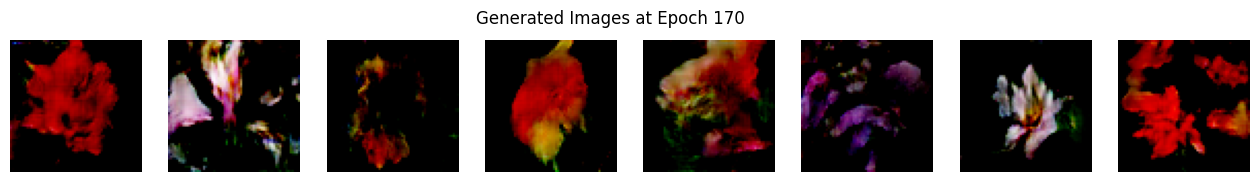

Epochs:  68%|██████▊   | 171/250 [1:05:51<30:33, 23.21s/it]

Epoch [171/250] Step [0] Discriminator Loss: 0.661016583442688 Generator Loss: 0.6123690009117126
Epoch [171/250] Step [600] Discriminator Loss: 0.659635603427887 Generator Loss: 0.6349588632583618
Epoch [171/250] Step [1200] Discriminator Loss: 0.6754277646541595 Generator Loss: 0.6015373468399048
Epoch [171/250] Step [1800] Discriminator Loss: 0.6696584522724152 Generator Loss: 0.6349928975105286
Epoch [171/250] Step [2400] Discriminator Loss: 0.656940758228302 Generator Loss: 0.6184760332107544
Epoch [171/250] Step [3000] Discriminator Loss: 0.6893838346004486 Generator Loss: 0.5825026035308838
Epoch [171/250] Step [3600] Discriminator Loss: 0.6609298586845398 Generator Loss: 0.660836935043335
Epoch [171/250] Step [4200] Discriminator Loss: 0.6641168296337128 Generator Loss: 0.6442810893058777
Epoch [171/250] Step [4800] Discriminator Loss: 0.6714857220649719 Generator Loss: 0.6219962239265442
Epoch [171/250] Step [5400] Discriminator Loss: 0.6753012239933014 Generator Loss: 0.61027

Epochs:  69%|██████▉   | 172/250 [1:06:14<30:06, 23.16s/it]

Epoch [172/250] Step [0] Discriminator Loss: 0.6655873954296112 Generator Loss: 0.6249728202819824
Epoch [172/250] Step [600] Discriminator Loss: 0.6646597683429718 Generator Loss: 0.6347196698188782
Epoch [172/250] Step [1200] Discriminator Loss: 0.6678906083106995 Generator Loss: 0.6128361225128174
Epoch [172/250] Step [1800] Discriminator Loss: 0.6667917370796204 Generator Loss: 0.6389249563217163
Epoch [172/250] Step [2400] Discriminator Loss: 0.6662956774234772 Generator Loss: 0.632839024066925
Epoch [172/250] Step [3000] Discriminator Loss: 0.6654210984706879 Generator Loss: 0.644536018371582
Epoch [172/250] Step [3600] Discriminator Loss: 0.6662567257881165 Generator Loss: 0.6195394396781921
Epoch [172/250] Step [4200] Discriminator Loss: 0.6656136214733124 Generator Loss: 0.6364991664886475
Epoch [172/250] Step [4800] Discriminator Loss: 0.6628903448581696 Generator Loss: 0.6117770075798035
Epoch [172/250] Step [5400] Discriminator Loss: 0.6774337887763977 Generator Loss: 0.643

Epochs:  69%|██████▉   | 173/250 [1:06:37<29:40, 23.12s/it]

Epoch [173/250] Step [0] Discriminator Loss: 0.6733188927173615 Generator Loss: 0.6314083933830261
Epoch [173/250] Step [600] Discriminator Loss: 0.6665282845497131 Generator Loss: 0.6339786648750305
Epoch [173/250] Step [1200] Discriminator Loss: 0.6705635190010071 Generator Loss: 0.6280152797698975
Epoch [173/250] Step [1800] Discriminator Loss: 0.6582577526569366 Generator Loss: 0.6572889089584351
Epoch [173/250] Step [2400] Discriminator Loss: 0.6743512153625488 Generator Loss: 0.6517940163612366
Epoch [173/250] Step [3000] Discriminator Loss: 0.6682730317115784 Generator Loss: 0.6320338249206543
Epoch [173/250] Step [3600] Discriminator Loss: 0.6696442663669586 Generator Loss: 0.6263949871063232
Epoch [173/250] Step [4200] Discriminator Loss: 0.6596284806728363 Generator Loss: 0.6572442054748535
Epoch [173/250] Step [4800] Discriminator Loss: 0.6620166897773743 Generator Loss: 0.6367524266242981
Epoch [173/250] Step [5400] Discriminator Loss: 0.6649893820285797 Generator Loss: 0.6

Epochs:  70%|██████▉   | 174/250 [1:07:00<29:15, 23.10s/it]

Epoch [174/250] Step [0] Discriminator Loss: 0.6712141931056976 Generator Loss: 0.6719274520874023
Epoch [174/250] Step [600] Discriminator Loss: 0.6860202848911285 Generator Loss: 0.6326146721839905
Epoch [174/250] Step [1200] Discriminator Loss: 0.6624144911766052 Generator Loss: 0.6556137204170227
Epoch [174/250] Step [1800] Discriminator Loss: 0.6707258224487305 Generator Loss: 0.6780148148536682
Epoch [174/250] Step [2400] Discriminator Loss: 0.6615414917469025 Generator Loss: 0.6207208037376404
Epoch [174/250] Step [3000] Discriminator Loss: 0.6702340841293335 Generator Loss: 0.6397565603256226
Epoch [174/250] Step [3600] Discriminator Loss: 0.6800547242164612 Generator Loss: 0.6074008345603943
Epoch [174/250] Step [4200] Discriminator Loss: 0.6632037460803986 Generator Loss: 0.6553537845611572
Epoch [174/250] Step [4800] Discriminator Loss: 0.6756423115730286 Generator Loss: 0.6693660616874695
Epoch [174/250] Step [5400] Discriminator Loss: 0.6765875220298767 Generator Loss: 0.6

Epochs:  70%|███████   | 175/250 [1:07:23<28:51, 23.09s/it]

Epoch [175/250] Step [0] Discriminator Loss: 0.6635679304599762 Generator Loss: 0.6333456635475159
Epoch [175/250] Step [600] Discriminator Loss: 0.6702422797679901 Generator Loss: 0.5882324576377869
Epoch [175/250] Step [1200] Discriminator Loss: 0.6657220125198364 Generator Loss: 0.6501675248146057
Epoch [175/250] Step [1800] Discriminator Loss: 0.6804164350032806 Generator Loss: 0.6298572421073914
Epoch [175/250] Step [2400] Discriminator Loss: 0.6619527637958527 Generator Loss: 0.6307075619697571
Epoch [175/250] Step [3000] Discriminator Loss: 0.6706308722496033 Generator Loss: 0.6553171277046204
Epoch [175/250] Step [3600] Discriminator Loss: 0.6621566116809845 Generator Loss: 0.6030412912368774
Epoch [175/250] Step [4200] Discriminator Loss: 0.6671463549137115 Generator Loss: 0.6213013529777527
Epoch [175/250] Step [4800] Discriminator Loss: 0.6717876195907593 Generator Loss: 0.6311420202255249
Epoch [175/250] Step [5400] Discriminator Loss: 0.6727175116539001 Generator Loss: 0.6

Epochs:  70%|███████   | 176/250 [1:07:46<28:27, 23.08s/it]

Epoch [176/250] Step [0] Discriminator Loss: 0.660413384437561 Generator Loss: 0.6389567255973816
Epoch [176/250] Step [600] Discriminator Loss: 0.675754725933075 Generator Loss: 0.6356849074363708
Epoch [176/250] Step [1200] Discriminator Loss: 0.6688403189182281 Generator Loss: 0.6449633836746216
Epoch [176/250] Step [1800] Discriminator Loss: 0.6592084765434265 Generator Loss: 0.632427453994751
Epoch [176/250] Step [2400] Discriminator Loss: 0.6745555400848389 Generator Loss: 0.642271876335144
Epoch [176/250] Step [3000] Discriminator Loss: 0.7193149626255035 Generator Loss: 0.6654151082038879
Epoch [176/250] Step [3600] Discriminator Loss: 0.6734342575073242 Generator Loss: 0.6373106837272644
Epoch [176/250] Step [4200] Discriminator Loss: 0.7187815010547638 Generator Loss: 0.6393587589263916
Epoch [176/250] Step [4800] Discriminator Loss: 0.6636263132095337 Generator Loss: 0.5913305282592773
Epoch [176/250] Step [5400] Discriminator Loss: 0.6783598065376282 Generator Loss: 0.59895

Epochs:  71%|███████   | 177/250 [1:08:09<28:03, 23.06s/it]

Epoch [177/250] Step [0] Discriminator Loss: 0.6665202379226685 Generator Loss: 0.5875314474105835
Epoch [177/250] Step [600] Discriminator Loss: 0.665660560131073 Generator Loss: 0.6268401145935059
Epoch [177/250] Step [1200] Discriminator Loss: 0.6674924492835999 Generator Loss: 0.6402420401573181
Epoch [177/250] Step [1800] Discriminator Loss: 0.6702410876750946 Generator Loss: 0.5850151777267456
Epoch [177/250] Step [2400] Discriminator Loss: 0.6742723882198334 Generator Loss: 0.6323416233062744
Epoch [177/250] Step [3000] Discriminator Loss: 0.6645143628120422 Generator Loss: 0.6225326061248779
Epoch [177/250] Step [3600] Discriminator Loss: 0.6688850522041321 Generator Loss: 0.6023854613304138
Epoch [177/250] Step [4200] Discriminator Loss: 0.6634688973426819 Generator Loss: 0.6366695761680603
Epoch [177/250] Step [4800] Discriminator Loss: 0.6898691356182098 Generator Loss: 0.6500745415687561
Epoch [177/250] Step [5400] Discriminator Loss: 0.6674900352954865 Generator Loss: 0.57

Epochs:  71%|███████   | 178/250 [1:08:32<27:40, 23.06s/it]

Epoch [178/250] Step [0] Discriminator Loss: 0.6766784191131592 Generator Loss: 0.6578533053398132
Epoch [178/250] Step [600] Discriminator Loss: 0.714150458574295 Generator Loss: 0.6319823861122131
Epoch [178/250] Step [1200] Discriminator Loss: 0.665380597114563 Generator Loss: 0.6279883980751038
Epoch [178/250] Step [1800] Discriminator Loss: 0.6765202283859253 Generator Loss: 0.6489152908325195
Epoch [178/250] Step [2400] Discriminator Loss: 0.6601400077342987 Generator Loss: 0.5985245108604431
Epoch [178/250] Step [3000] Discriminator Loss: 0.6628450751304626 Generator Loss: 0.6483669877052307
Epoch [178/250] Step [3600] Discriminator Loss: 0.6584177613258362 Generator Loss: 0.6159631013870239
Epoch [178/250] Step [4200] Discriminator Loss: 0.6661520600318909 Generator Loss: 0.6466798782348633
Epoch [178/250] Step [4800] Discriminator Loss: 0.6669987142086029 Generator Loss: 0.6330903768539429
Epoch [178/250] Step [5400] Discriminator Loss: 0.6789677739143372 Generator Loss: 0.601

Epochs:  72%|███████▏  | 179/250 [1:08:55<27:16, 23.05s/it]

Epoch [179/250] Step [0] Discriminator Loss: 0.6779212951660156 Generator Loss: 0.617365300655365
Epoch [179/250] Step [600] Discriminator Loss: 0.6740686893463135 Generator Loss: 0.6481550931930542
Epoch [179/250] Step [1200] Discriminator Loss: 0.6633580923080444 Generator Loss: 0.6438788175582886
Epoch [179/250] Step [1800] Discriminator Loss: 0.6661339402198792 Generator Loss: 0.638477087020874
Epoch [179/250] Step [2400] Discriminator Loss: 0.6604187488555908 Generator Loss: 0.6167990565299988
Epoch [179/250] Step [3000] Discriminator Loss: 0.6656767725944519 Generator Loss: 0.6153042912483215
Epoch [179/250] Step [3600] Discriminator Loss: 0.6590086817741394 Generator Loss: 0.6397611498832703
Epoch [179/250] Step [4200] Discriminator Loss: 0.662754625082016 Generator Loss: 0.6695065498352051
Epoch [179/250] Step [4800] Discriminator Loss: 0.6632862985134125 Generator Loss: 0.6559582352638245
Epoch [179/250] Step [5400] Discriminator Loss: 0.6581845879554749 Generator Loss: 0.6592

Epochs:  72%|███████▏  | 180/250 [1:09:19<26:53, 23.05s/it]

Epoch [180/250] Step [0] Discriminator Loss: 0.658624529838562 Generator Loss: 0.6491459012031555
Epoch [180/250] Step [600] Discriminator Loss: 0.6658086776733398 Generator Loss: 0.6580743789672852
Epoch [180/250] Step [1200] Discriminator Loss: 0.6761933863162994 Generator Loss: 0.6512362957000732
Epoch [180/250] Step [1800] Discriminator Loss: 0.6622072458267212 Generator Loss: 0.6200348734855652
Epoch [180/250] Step [2400] Discriminator Loss: 0.6720768213272095 Generator Loss: 0.6517138481140137
Epoch [180/250] Step [3000] Discriminator Loss: 0.6886234283447266 Generator Loss: 0.6122105717658997
Epoch [180/250] Step [3600] Discriminator Loss: 0.6644086837768555 Generator Loss: 0.6632599234580994
Epoch [180/250] Step [4200] Discriminator Loss: 0.6648479402065277 Generator Loss: 0.6174893975257874
Epoch [180/250] Step [4800] Discriminator Loss: 0.6783044934272766 Generator Loss: 0.627444863319397
Epoch [180/250] Step [5400] Discriminator Loss: 0.6850786209106445 Generator Loss: 0.579

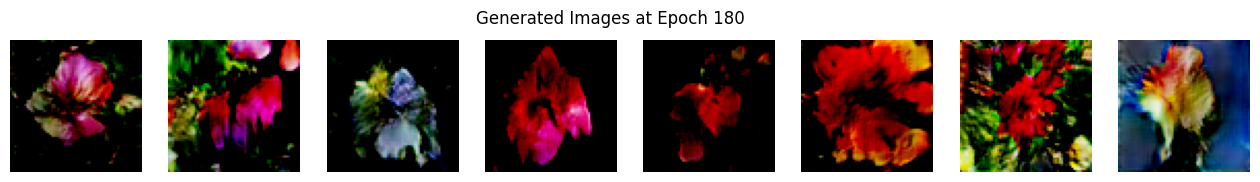

Epochs:  72%|███████▏  | 181/250 [1:09:42<26:42, 23.23s/it]

Epoch [181/250] Step [0] Discriminator Loss: 0.662403017282486 Generator Loss: 0.6453561186790466
Epoch [181/250] Step [600] Discriminator Loss: 0.6694375872612 Generator Loss: 0.6539538502693176
Epoch [181/250] Step [1200] Discriminator Loss: 0.6714892983436584 Generator Loss: 0.6438207626342773
Epoch [181/250] Step [1800] Discriminator Loss: 0.6623221039772034 Generator Loss: 0.6393810510635376
Epoch [181/250] Step [2400] Discriminator Loss: 0.6738051474094391 Generator Loss: 0.6333916187286377
Epoch [181/250] Step [3000] Discriminator Loss: 0.6686989367008209 Generator Loss: 0.5619609951972961
Epoch [181/250] Step [3600] Discriminator Loss: 0.6643535494804382 Generator Loss: 0.6383640766143799
Epoch [181/250] Step [4200] Discriminator Loss: 0.6881038844585419 Generator Loss: 0.6161381006240845
Epoch [181/250] Step [4800] Discriminator Loss: 0.668749213218689 Generator Loss: 0.6512800455093384
Epoch [181/250] Step [5400] Discriminator Loss: 0.6684876978397369 Generator Loss: 0.651778

Epochs:  73%|███████▎  | 182/250 [1:10:05<26:15, 23.17s/it]

Epoch [182/250] Step [0] Discriminator Loss: 0.6672782301902771 Generator Loss: 0.6213345527648926
Epoch [182/250] Step [600] Discriminator Loss: 0.6674411296844482 Generator Loss: 0.6566178798675537
Epoch [182/250] Step [1200] Discriminator Loss: 0.673375129699707 Generator Loss: 0.6437833309173584
Epoch [182/250] Step [1800] Discriminator Loss: 0.6679792106151581 Generator Loss: 0.6207634210586548
Epoch [182/250] Step [2400] Discriminator Loss: 0.6819327771663666 Generator Loss: 0.6187566518783569
Epoch [182/250] Step [3000] Discriminator Loss: 0.6861461997032166 Generator Loss: 0.6482828855514526
Epoch [182/250] Step [3600] Discriminator Loss: 0.6664018332958221 Generator Loss: 0.6117994785308838
Epoch [182/250] Step [4200] Discriminator Loss: 0.6913796663284302 Generator Loss: 0.6180928945541382
Epoch [182/250] Step [4800] Discriminator Loss: 0.6562923789024353 Generator Loss: 0.6108437180519104
Epoch [182/250] Step [5400] Discriminator Loss: 0.6645224690437317 Generator Loss: 0.63

Epochs:  73%|███████▎  | 183/250 [1:10:28<25:50, 23.13s/it]

Epoch [183/250] Step [0] Discriminator Loss: 0.667410284280777 Generator Loss: 0.6303691267967224
Epoch [183/250] Step [600] Discriminator Loss: 0.6741008460521698 Generator Loss: 0.6695114970207214
Epoch [183/250] Step [1200] Discriminator Loss: 0.6896018981933594 Generator Loss: 0.6804593801498413
Epoch [183/250] Step [1800] Discriminator Loss: 0.6706836819648743 Generator Loss: 0.6452333331108093
Epoch [183/250] Step [2400] Discriminator Loss: 0.6658057570457458 Generator Loss: 0.627459704875946
Epoch [183/250] Step [3000] Discriminator Loss: 0.6603969931602478 Generator Loss: 0.6579719185829163
Epoch [183/250] Step [3600] Discriminator Loss: 0.6703544557094574 Generator Loss: 0.6313851475715637
Epoch [183/250] Step [4200] Discriminator Loss: 0.6673335134983063 Generator Loss: 0.6326578855514526
Epoch [183/250] Step [4800] Discriminator Loss: 0.6653518378734589 Generator Loss: 0.6200048327445984
Epoch [183/250] Step [5400] Discriminator Loss: 0.6672699451446533 Generator Loss: 0.629

Epochs:  74%|███████▎  | 184/250 [1:10:51<25:25, 23.11s/it]

Epoch [184/250] Step [0] Discriminator Loss: 0.681150496006012 Generator Loss: 0.6018837094306946
Epoch [184/250] Step [600] Discriminator Loss: 0.6736395359039307 Generator Loss: 0.6618875861167908
Epoch [184/250] Step [1200] Discriminator Loss: 0.6866381168365479 Generator Loss: 0.6569142937660217
Epoch [184/250] Step [1800] Discriminator Loss: 0.6707785427570343 Generator Loss: 0.6258675456047058
Epoch [184/250] Step [2400] Discriminator Loss: 0.670359194278717 Generator Loss: 0.6475191116333008
Epoch [184/250] Step [3000] Discriminator Loss: 0.6660940945148468 Generator Loss: 0.607439398765564
Epoch [184/250] Step [3600] Discriminator Loss: 0.6674140095710754 Generator Loss: 0.6534913778305054
Epoch [184/250] Step [4200] Discriminator Loss: 0.6680881679058075 Generator Loss: 0.6262772679328918
Epoch [184/250] Step [4800] Discriminator Loss: 0.6589881181716919 Generator Loss: 0.610735297203064
Epoch [184/250] Step [5400] Discriminator Loss: 0.6674751341342926 Generator Loss: 0.61396

Epochs:  74%|███████▍  | 185/250 [1:11:14<25:01, 23.10s/it]

Epoch [185/250] Step [0] Discriminator Loss: 0.6634587943553925 Generator Loss: 0.6325513124465942
Epoch [185/250] Step [600] Discriminator Loss: 0.6607946455478668 Generator Loss: 0.616682231426239
Epoch [185/250] Step [1200] Discriminator Loss: 0.6598016619682312 Generator Loss: 0.6535440683364868
Epoch [185/250] Step [1800] Discriminator Loss: 0.6607654690742493 Generator Loss: 0.6182782649993896
Epoch [185/250] Step [2400] Discriminator Loss: 0.6638938188552856 Generator Loss: 0.6467711329460144
Epoch [185/250] Step [3000] Discriminator Loss: 0.6671918332576752 Generator Loss: 0.6561645865440369
Epoch [185/250] Step [3600] Discriminator Loss: 0.6672584116458893 Generator Loss: 0.663713812828064
Epoch [185/250] Step [4200] Discriminator Loss: 0.6605349779129028 Generator Loss: 0.6610938310623169
Epoch [185/250] Step [4800] Discriminator Loss: 0.6616660952568054 Generator Loss: 0.6439945697784424
Epoch [185/250] Step [5400] Discriminator Loss: 0.6758849918842316 Generator Loss: 0.593

Epochs:  74%|███████▍  | 186/250 [1:11:37<24:37, 23.09s/it]

Epoch [186/250] Step [0] Discriminator Loss: 0.6577755808830261 Generator Loss: 0.6487325429916382
Epoch [186/250] Step [600] Discriminator Loss: 0.655107855796814 Generator Loss: 0.6368110775947571
Epoch [186/250] Step [1200] Discriminator Loss: 0.6553947329521179 Generator Loss: 0.6244105696678162
Epoch [186/250] Step [1800] Discriminator Loss: 0.6635786294937134 Generator Loss: 0.6421602368354797
Epoch [186/250] Step [2400] Discriminator Loss: 0.6544301509857178 Generator Loss: 0.6312585473060608
Epoch [186/250] Step [3000] Discriminator Loss: 0.6557406485080719 Generator Loss: 0.648958146572113
Epoch [186/250] Step [3600] Discriminator Loss: 0.664570689201355 Generator Loss: 0.655124843120575
Epoch [186/250] Step [4200] Discriminator Loss: 0.6669629812240601 Generator Loss: 0.6431515216827393
Epoch [186/250] Step [4800] Discriminator Loss: 0.6632094085216522 Generator Loss: 0.6045019030570984
Epoch [186/250] Step [5400] Discriminator Loss: 0.7041434645652771 Generator Loss: 0.68760

Epochs:  75%|███████▍  | 187/250 [1:12:01<24:14, 23.08s/it]

Epoch [187/250] Step [0] Discriminator Loss: 0.6814974546432495 Generator Loss: 0.6659655570983887
Epoch [187/250] Step [600] Discriminator Loss: 0.6631105244159698 Generator Loss: 0.6308264136314392
Epoch [187/250] Step [1200] Discriminator Loss: 0.6719972491264343 Generator Loss: 0.6640661954879761
Epoch [187/250] Step [1800] Discriminator Loss: 0.6614759266376495 Generator Loss: 0.6495605111122131
Epoch [187/250] Step [2400] Discriminator Loss: 0.6759512424468994 Generator Loss: 0.6873198747634888
Epoch [187/250] Step [3000] Discriminator Loss: 0.6733472347259521 Generator Loss: 0.6487016677856445
Epoch [187/250] Step [3600] Discriminator Loss: 0.7030877470970154 Generator Loss: 0.6388740539550781
Epoch [187/250] Step [4200] Discriminator Loss: 0.6714331805706024 Generator Loss: 0.6184581518173218
Epoch [187/250] Step [4800] Discriminator Loss: 0.6775808036327362 Generator Loss: 0.6367958188056946
Epoch [187/250] Step [5400] Discriminator Loss: 0.6709997057914734 Generator Loss: 0.6

Epochs:  75%|███████▌  | 188/250 [1:12:24<23:50, 23.07s/it]

Epoch [188/250] Step [0] Discriminator Loss: 0.6862585246562958 Generator Loss: 0.6903844475746155
Epoch [188/250] Step [600] Discriminator Loss: 0.6665527522563934 Generator Loss: 0.6308748126029968
Epoch [188/250] Step [1200] Discriminator Loss: 0.6698383390903473 Generator Loss: 0.5910214781761169
Epoch [188/250] Step [1800] Discriminator Loss: 0.6678261756896973 Generator Loss: 0.6262093782424927
Epoch [188/250] Step [2400] Discriminator Loss: 0.661976158618927 Generator Loss: 0.6625150442123413
Epoch [188/250] Step [3000] Discriminator Loss: 0.6619336903095245 Generator Loss: 0.6244450211524963
Epoch [188/250] Step [3600] Discriminator Loss: 0.6797196865081787 Generator Loss: 0.6234147548675537
Epoch [188/250] Step [4200] Discriminator Loss: 0.6686603724956512 Generator Loss: 0.6378746032714844
Epoch [188/250] Step [4800] Discriminator Loss: 0.675210177898407 Generator Loss: 0.6390865445137024
Epoch [188/250] Step [5400] Discriminator Loss: 0.6621092259883881 Generator Loss: 0.634

Epochs:  76%|███████▌  | 189/250 [1:12:47<23:27, 23.07s/it]

Epoch [189/250] Step [0] Discriminator Loss: 0.6616306900978088 Generator Loss: 0.673292875289917
Epoch [189/250] Step [600] Discriminator Loss: 0.6836944818496704 Generator Loss: 0.5706079602241516
Epoch [189/250] Step [1200] Discriminator Loss: 0.663111686706543 Generator Loss: 0.6430740356445312
Epoch [189/250] Step [1800] Discriminator Loss: 0.6740828454494476 Generator Loss: 0.6491392850875854
Epoch [189/250] Step [2400] Discriminator Loss: 0.6579766273498535 Generator Loss: 0.595247209072113
Epoch [189/250] Step [3000] Discriminator Loss: 0.6659020185470581 Generator Loss: 0.6459316611289978
Epoch [189/250] Step [3600] Discriminator Loss: 0.6607036888599396 Generator Loss: 0.6425792574882507
Epoch [189/250] Step [4200] Discriminator Loss: 0.6668162643909454 Generator Loss: 0.6608178615570068
Epoch [189/250] Step [4800] Discriminator Loss: 0.6806416213512421 Generator Loss: 0.5842863917350769
Epoch [189/250] Step [5400] Discriminator Loss: 0.6649805009365082 Generator Loss: 0.6285

Epochs:  76%|███████▌  | 190/250 [1:13:10<23:03, 23.06s/it]

Epoch [190/250] Step [0] Discriminator Loss: 0.6765322089195251 Generator Loss: 0.6604976058006287
Epoch [190/250] Step [600] Discriminator Loss: 0.671652615070343 Generator Loss: 0.6316971778869629
Epoch [190/250] Step [1200] Discriminator Loss: 0.6672414541244507 Generator Loss: 0.6671351194381714
Epoch [190/250] Step [1800] Discriminator Loss: 0.6660882830619812 Generator Loss: 0.6605051755905151
Epoch [190/250] Step [2400] Discriminator Loss: 0.6699442565441132 Generator Loss: 0.6201225519180298
Epoch [190/250] Step [3000] Discriminator Loss: 0.6597624719142914 Generator Loss: 0.6149608492851257
Epoch [190/250] Step [3600] Discriminator Loss: 0.6827464401721954 Generator Loss: 0.6019450426101685
Epoch [190/250] Step [4200] Discriminator Loss: 0.6654517352581024 Generator Loss: 0.6290625333786011
Epoch [190/250] Step [4800] Discriminator Loss: 0.6701700389385223 Generator Loss: 0.63664311170578
Epoch [190/250] Step [5400] Discriminator Loss: 0.6612204611301422 Generator Loss: 0.6273

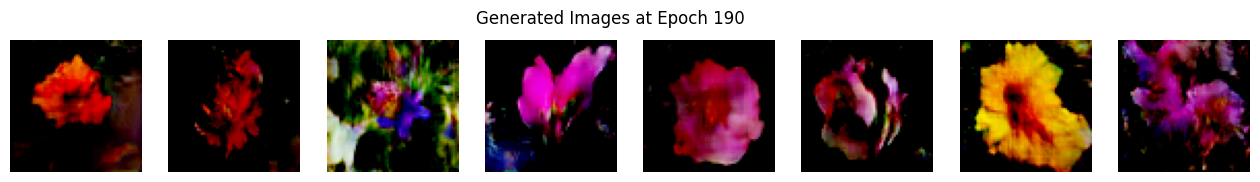

Epochs:  76%|███████▋  | 191/250 [1:13:33<22:50, 23.23s/it]

Epoch [191/250] Step [0] Discriminator Loss: 0.6655697226524353 Generator Loss: 0.6320363879203796
Epoch [191/250] Step [600] Discriminator Loss: 0.6743472218513489 Generator Loss: 0.6577135324478149
Epoch [191/250] Step [1200] Discriminator Loss: 0.6590891778469086 Generator Loss: 0.6615095734596252
Epoch [191/250] Step [1800] Discriminator Loss: 0.666660726070404 Generator Loss: 0.5974439382553101
Epoch [191/250] Step [2400] Discriminator Loss: 0.6923780739307404 Generator Loss: 0.6566365957260132
Epoch [191/250] Step [3000] Discriminator Loss: 0.6598432660102844 Generator Loss: 0.6257644295692444
Epoch [191/250] Step [3600] Discriminator Loss: 0.6621985137462616 Generator Loss: 0.6332132816314697
Epoch [191/250] Step [4200] Discriminator Loss: 0.6791454255580902 Generator Loss: 0.6007076501846313
Epoch [191/250] Step [4800] Discriminator Loss: 0.6746207475662231 Generator Loss: 0.6397901177406311
Epoch [191/250] Step [5400] Discriminator Loss: 0.6658608913421631 Generator Loss: 0.63

Epochs:  77%|███████▋  | 192/250 [1:13:56<22:23, 23.17s/it]

Epoch [192/250] Step [0] Discriminator Loss: 0.6645386815071106 Generator Loss: 0.6129998564720154
Epoch [192/250] Step [600] Discriminator Loss: 0.6888266205787659 Generator Loss: 0.6695494651794434
Epoch [192/250] Step [1200] Discriminator Loss: 0.6630019545555115 Generator Loss: 0.6172131299972534
Epoch [192/250] Step [1800] Discriminator Loss: 0.6639823019504547 Generator Loss: 0.625619649887085
Epoch [192/250] Step [2400] Discriminator Loss: 0.6742238998413086 Generator Loss: 0.5946431756019592
Epoch [192/250] Step [3000] Discriminator Loss: 0.6721326410770416 Generator Loss: 0.6381800174713135
Epoch [192/250] Step [3600] Discriminator Loss: 0.6660431623458862 Generator Loss: 0.6291906833648682
Epoch [192/250] Step [4200] Discriminator Loss: 0.6705133020877838 Generator Loss: 0.5722593665122986
Epoch [192/250] Step [4800] Discriminator Loss: 0.6602797210216522 Generator Loss: 0.644181489944458
Epoch [192/250] Step [5400] Discriminator Loss: 0.6820639669895172 Generator Loss: 0.652

Epochs:  77%|███████▋  | 193/250 [1:14:19<21:58, 23.13s/it]

Epoch [193/250] Step [0] Discriminator Loss: 0.6566319465637207 Generator Loss: 0.6447415947914124
Epoch [193/250] Step [600] Discriminator Loss: 0.6650634109973907 Generator Loss: 0.6080779433250427
Epoch [193/250] Step [1200] Discriminator Loss: 0.6770967245101929 Generator Loss: 0.6627349257469177
Epoch [193/250] Step [1800] Discriminator Loss: 0.6689785122871399 Generator Loss: 0.6521883010864258
Epoch [193/250] Step [2400] Discriminator Loss: 0.6687020361423492 Generator Loss: 0.6671972870826721
Epoch [193/250] Step [3000] Discriminator Loss: 0.6638137102127075 Generator Loss: 0.621707558631897
Epoch [193/250] Step [3600] Discriminator Loss: 0.6630779504776001 Generator Loss: 0.6515229940414429
Epoch [193/250] Step [4200] Discriminator Loss: 0.6647239327430725 Generator Loss: 0.6227952837944031
Epoch [193/250] Step [4800] Discriminator Loss: 0.6588440835475922 Generator Loss: 0.6371336579322815
Epoch [193/250] Step [5400] Discriminator Loss: 0.6647855639457703 Generator Loss: 0.62

Epochs:  78%|███████▊  | 194/250 [1:14:42<21:33, 23.11s/it]

Epoch [194/250] Step [0] Discriminator Loss: 0.6625660061836243 Generator Loss: 0.6112580895423889
Epoch [194/250] Step [600] Discriminator Loss: 0.6650910973548889 Generator Loss: 0.6522089838981628
Epoch [194/250] Step [1200] Discriminator Loss: 0.6619200110435486 Generator Loss: 0.6271134614944458
Epoch [194/250] Step [1800] Discriminator Loss: 0.66062992811203 Generator Loss: 0.6451963186264038
Epoch [194/250] Step [2400] Discriminator Loss: 0.6708866953849792 Generator Loss: 0.6468031406402588
Epoch [194/250] Step [3000] Discriminator Loss: 0.6591970324516296 Generator Loss: 0.6498279571533203
Epoch [194/250] Step [3600] Discriminator Loss: 0.6564911007881165 Generator Loss: 0.6416079998016357
Epoch [194/250] Step [4200] Discriminator Loss: 0.6639427840709686 Generator Loss: 0.6344268918037415
Epoch [194/250] Step [4800] Discriminator Loss: 0.6627912223339081 Generator Loss: 0.6364124417304993
Epoch [194/250] Step [5400] Discriminator Loss: 0.6603378653526306 Generator Loss: 0.612

Epochs:  78%|███████▊  | 195/250 [1:15:05<21:10, 23.09s/it]

Epoch [195/250] Step [0] Discriminator Loss: 0.6584521532058716 Generator Loss: 0.6543329954147339
Epoch [195/250] Step [600] Discriminator Loss: 0.6571430563926697 Generator Loss: 0.6340792775154114
Epoch [195/250] Step [1200] Discriminator Loss: 0.6654709577560425 Generator Loss: 0.6455950736999512
Epoch [195/250] Step [1800] Discriminator Loss: 0.6608439087867737 Generator Loss: 0.6338774561882019
Epoch [195/250] Step [2400] Discriminator Loss: 0.6577453911304474 Generator Loss: 0.6482855677604675
Epoch [195/250] Step [3000] Discriminator Loss: 0.6723246276378632 Generator Loss: 0.657899796962738
Epoch [195/250] Step [3600] Discriminator Loss: 0.662174254655838 Generator Loss: 0.6410062313079834
Epoch [195/250] Step [4200] Discriminator Loss: 0.6611151099205017 Generator Loss: 0.621364951133728
Epoch [195/250] Step [4800] Discriminator Loss: 0.6641212701797485 Generator Loss: 0.6414806842803955
Epoch [195/250] Step [5400] Discriminator Loss: 0.6621306538581848 Generator Loss: 0.6332

Epochs:  78%|███████▊  | 196/250 [1:15:29<20:46, 23.08s/it]

Epoch [196/250] Step [0] Discriminator Loss: 0.6585578322410583 Generator Loss: 0.6476261615753174
Epoch [196/250] Step [600] Discriminator Loss: 0.6827215850353241 Generator Loss: 0.6383857727050781
Epoch [196/250] Step [1200] Discriminator Loss: 0.6809762418270111 Generator Loss: 0.6524203419685364
Epoch [196/250] Step [1800] Discriminator Loss: 0.659371554851532 Generator Loss: 0.6527567505836487
Epoch [196/250] Step [2400] Discriminator Loss: 0.6604958772659302 Generator Loss: 0.6415343284606934
Epoch [196/250] Step [3000] Discriminator Loss: 0.6676388680934906 Generator Loss: 0.6672785878181458
Epoch [196/250] Step [3600] Discriminator Loss: 0.6694569289684296 Generator Loss: 0.6163651347160339
Epoch [196/250] Step [4200] Discriminator Loss: 0.6790991127490997 Generator Loss: 0.6790169477462769
Epoch [196/250] Step [4800] Discriminator Loss: 0.6616149246692657 Generator Loss: 0.6384373903274536
Epoch [196/250] Step [5400] Discriminator Loss: 0.6607880592346191 Generator Loss: 0.60

Epochs:  79%|███████▉  | 197/250 [1:15:52<20:22, 23.07s/it]

Epoch [197/250] Step [0] Discriminator Loss: 0.6629387140274048 Generator Loss: 0.6847871541976929
Epoch [197/250] Step [600] Discriminator Loss: 0.6611717343330383 Generator Loss: 0.6176933646202087
Epoch [197/250] Step [1200] Discriminator Loss: 0.6879070103168488 Generator Loss: 0.5933724641799927
Epoch [197/250] Step [1800] Discriminator Loss: 0.6655054688453674 Generator Loss: 0.6338209509849548
Epoch [197/250] Step [2400] Discriminator Loss: 0.6704274415969849 Generator Loss: 0.6058855652809143
Epoch [197/250] Step [3000] Discriminator Loss: 0.6692316830158234 Generator Loss: 0.6328030824661255
Epoch [197/250] Step [3600] Discriminator Loss: 0.775422215461731 Generator Loss: 0.6590189337730408
Epoch [197/250] Step [4200] Discriminator Loss: 0.6863933205604553 Generator Loss: 0.6537296175956726
Epoch [197/250] Step [4800] Discriminator Loss: 0.6783956289291382 Generator Loss: 0.6175021529197693
Epoch [197/250] Step [5400] Discriminator Loss: 0.6872544288635254 Generator Loss: 0.62

Epochs:  79%|███████▉  | 198/250 [1:16:15<19:59, 23.08s/it]

Epoch [198/250] Step [0] Discriminator Loss: 0.6660022735595703 Generator Loss: 0.6351560950279236
Epoch [198/250] Step [600] Discriminator Loss: 0.6625089943408966 Generator Loss: 0.6403670310974121
Epoch [198/250] Step [1200] Discriminator Loss: 0.6655581593513489 Generator Loss: 0.6416775584220886
Epoch [198/250] Step [1800] Discriminator Loss: 0.6690949201583862 Generator Loss: 0.6652360558509827
Epoch [198/250] Step [2400] Discriminator Loss: 0.6669860184192657 Generator Loss: 0.643347978591919
Epoch [198/250] Step [3000] Discriminator Loss: 0.6689795851707458 Generator Loss: 0.6388674378395081
Epoch [198/250] Step [3600] Discriminator Loss: 0.6608091592788696 Generator Loss: 0.6508608460426331
Epoch [198/250] Step [4200] Discriminator Loss: 0.6762166917324066 Generator Loss: 0.6663375496864319
Epoch [198/250] Step [4800] Discriminator Loss: 0.6624237596988678 Generator Loss: 0.6377851963043213
Epoch [198/250] Step [5400] Discriminator Loss: 0.6645257771015167 Generator Loss: 0.63

Epochs:  80%|███████▉  | 199/250 [1:16:38<19:36, 23.07s/it]

Epoch [199/250] Step [0] Discriminator Loss: 0.6677312254905701 Generator Loss: 0.646559476852417
Epoch [199/250] Step [600] Discriminator Loss: 0.6664484739303589 Generator Loss: 0.6223137378692627
Epoch [199/250] Step [1200] Discriminator Loss: 0.6572801172733307 Generator Loss: 0.6601603627204895
Epoch [199/250] Step [1800] Discriminator Loss: 0.65861976146698 Generator Loss: 0.6466135382652283
Epoch [199/250] Step [2400] Discriminator Loss: 0.6613433659076691 Generator Loss: 0.6540089249610901
Epoch [199/250] Step [3000] Discriminator Loss: 0.6580291390419006 Generator Loss: 0.6457669734954834
Epoch [199/250] Step [3600] Discriminator Loss: 0.6602007448673248 Generator Loss: 0.6105709671974182
Epoch [199/250] Step [4200] Discriminator Loss: 0.6640677452087402 Generator Loss: 0.6393816471099854
Epoch [199/250] Step [4800] Discriminator Loss: 0.6772947609424591 Generator Loss: 0.6376598477363586
Epoch [199/250] Step [5400] Discriminator Loss: 0.6699062287807465 Generator Loss: 0.6460

Epochs:  80%|████████  | 200/250 [1:17:01<19:14, 23.08s/it]

Epoch [200/250] Step [0] Discriminator Loss: 0.6667308211326599 Generator Loss: 0.6079738140106201
Epoch [200/250] Step [600] Discriminator Loss: 0.6739843189716339 Generator Loss: 0.6370182633399963
Epoch [200/250] Step [1200] Discriminator Loss: 0.6566601693630219 Generator Loss: 0.6314630508422852
Epoch [200/250] Step [1800] Discriminator Loss: 0.6546435952186584 Generator Loss: 0.6237245202064514
Epoch [200/250] Step [2400] Discriminator Loss: 0.6576498746871948 Generator Loss: 0.6412609815597534
Epoch [200/250] Step [3000] Discriminator Loss: 0.6630979180335999 Generator Loss: 0.6416618227958679
Epoch [200/250] Step [3600] Discriminator Loss: 0.6576179265975952 Generator Loss: 0.6451326608657837
Epoch [200/250] Step [4200] Discriminator Loss: 0.6647666692733765 Generator Loss: 0.6226956844329834
Epoch [200/250] Step [4800] Discriminator Loss: 0.660053551197052 Generator Loss: 0.6407773494720459
Epoch [200/250] Step [5400] Discriminator Loss: 0.6570128202438354 Generator Loss: 0.63

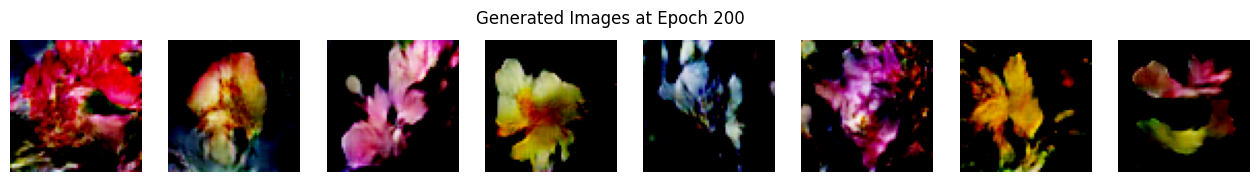

Epochs:  80%|████████  | 201/250 [1:17:25<18:59, 23.26s/it]

Epoch [201/250] Step [0] Discriminator Loss: 0.6562109589576721 Generator Loss: 0.6585155129432678
Epoch [201/250] Step [600] Discriminator Loss: 0.6562708020210266 Generator Loss: 0.6594238877296448
Epoch [201/250] Step [1200] Discriminator Loss: 0.6654876172542572 Generator Loss: 0.6651603579521179
Epoch [201/250] Step [1800] Discriminator Loss: 0.6556665301322937 Generator Loss: 0.6379387378692627
Epoch [201/250] Step [2400] Discriminator Loss: 0.6634663045406342 Generator Loss: 0.6569052338600159
Epoch [201/250] Step [3000] Discriminator Loss: 0.6769569516181946 Generator Loss: 0.6354014277458191
Epoch [201/250] Step [3600] Discriminator Loss: 0.6558258831501007 Generator Loss: 0.6563488841056824
Epoch [201/250] Step [4200] Discriminator Loss: 0.661003589630127 Generator Loss: 0.6442731022834778
Epoch [201/250] Step [4800] Discriminator Loss: 0.6572944223880768 Generator Loss: 0.6272722482681274
Epoch [201/250] Step [5400] Discriminator Loss: 0.6635513007640839 Generator Loss: 0.64

Epochs:  81%|████████  | 202/250 [1:17:48<18:33, 23.20s/it]

Epoch [202/250] Step [0] Discriminator Loss: 0.657334566116333 Generator Loss: 0.6398316025733948
Epoch [202/250] Step [600] Discriminator Loss: 0.6593371033668518 Generator Loss: 0.6377391815185547
Epoch [202/250] Step [1200] Discriminator Loss: 0.6632076799869537 Generator Loss: 0.640643835067749
Epoch [202/250] Step [1800] Discriminator Loss: 0.6564047634601593 Generator Loss: 0.6494759917259216
Epoch [202/250] Step [2400] Discriminator Loss: 0.6554134786128998 Generator Loss: 0.6385025978088379
Epoch [202/250] Step [3000] Discriminator Loss: 0.6549973785877228 Generator Loss: 0.6417003273963928
Epoch [202/250] Step [3600] Discriminator Loss: 0.656600147485733 Generator Loss: 0.6345351338386536
Epoch [202/250] Step [4200] Discriminator Loss: 0.6583310663700104 Generator Loss: 0.6417642831802368
Epoch [202/250] Step [4800] Discriminator Loss: 0.6580235958099365 Generator Loss: 0.6480416655540466
Epoch [202/250] Step [5400] Discriminator Loss: 0.6634353995323181 Generator Loss: 0.6564

Epochs:  81%|████████  | 203/250 [1:18:11<18:08, 23.15s/it]

Epoch [203/250] Step [0] Discriminator Loss: 0.6744791269302368 Generator Loss: 0.6745049953460693
Epoch [203/250] Step [600] Discriminator Loss: 0.6588336825370789 Generator Loss: 0.6518808007240295
Epoch [203/250] Step [1200] Discriminator Loss: 0.6535526216030121 Generator Loss: 0.6508048176765442
Epoch [203/250] Step [1800] Discriminator Loss: 0.661815732717514 Generator Loss: 0.6468146443367004
Epoch [203/250] Step [2400] Discriminator Loss: 0.6558931469917297 Generator Loss: 0.6594310402870178
Epoch [203/250] Step [3000] Discriminator Loss: 0.6743066310882568 Generator Loss: 0.6124786138534546
Epoch [203/250] Step [3600] Discriminator Loss: 0.6645974516868591 Generator Loss: 0.6509676575660706
Epoch [203/250] Step [4200] Discriminator Loss: 0.6806737780570984 Generator Loss: 0.5897113680839539
Epoch [203/250] Step [4800] Discriminator Loss: 0.6791818141937256 Generator Loss: 0.6155229210853577
Epoch [203/250] Step [5400] Discriminator Loss: 0.6646606028079987 Generator Loss: 0.64

Epochs:  82%|████████▏ | 204/250 [1:18:34<17:43, 23.12s/it]

Epoch [204/250] Step [0] Discriminator Loss: 0.6710336804389954 Generator Loss: 0.6137495636940002
Epoch [204/250] Step [600] Discriminator Loss: 0.6778399050235748 Generator Loss: 0.6724491715431213
Epoch [204/250] Step [1200] Discriminator Loss: 0.6850959658622742 Generator Loss: 0.6625645756721497
Epoch [204/250] Step [1800] Discriminator Loss: 0.8165833950042725 Generator Loss: 0.40235742926597595
Epoch [204/250] Step [2400] Discriminator Loss: 0.6774523556232452 Generator Loss: 0.6386210918426514
Epoch [204/250] Step [3000] Discriminator Loss: 0.6859403550624847 Generator Loss: 0.6534101366996765
Epoch [204/250] Step [3600] Discriminator Loss: 0.7005870640277863 Generator Loss: 0.6027729511260986
Epoch [204/250] Step [4200] Discriminator Loss: 0.669659286737442 Generator Loss: 0.6616265177726746
Epoch [204/250] Step [4800] Discriminator Loss: 0.6742790937423706 Generator Loss: 0.645279586315155
Epoch [204/250] Step [5400] Discriminator Loss: 0.7298747301101685 Generator Loss: 0.60

Epochs:  82%|████████▏ | 205/250 [1:18:57<17:19, 23.10s/it]

Epoch [205/250] Step [0] Discriminator Loss: 0.6757290065288544 Generator Loss: 0.6103540062904358
Epoch [205/250] Step [600] Discriminator Loss: 0.675253838300705 Generator Loss: 0.6366825699806213
Epoch [205/250] Step [1200] Discriminator Loss: 0.6825871765613556 Generator Loss: 0.682802140712738
Epoch [205/250] Step [1800] Discriminator Loss: 0.6924011707305908 Generator Loss: 0.6314334869384766
Epoch [205/250] Step [2400] Discriminator Loss: 0.6694334745407104 Generator Loss: 0.6538392305374146
Epoch [205/250] Step [3000] Discriminator Loss: 0.6734778881072998 Generator Loss: 0.651783287525177
Epoch [205/250] Step [3600] Discriminator Loss: 0.6598394215106964 Generator Loss: 0.634302020072937
Epoch [205/250] Step [4200] Discriminator Loss: 0.6612444519996643 Generator Loss: 0.6149788498878479
Epoch [205/250] Step [4800] Discriminator Loss: 0.6618058383464813 Generator Loss: 0.6019670963287354
Epoch [205/250] Step [5400] Discriminator Loss: 0.6912673711776733 Generator Loss: 0.63811

Epochs:  82%|████████▏ | 206/250 [1:19:20<16:55, 23.08s/it]

Epoch [206/250] Step [0] Discriminator Loss: 0.6824838221073151 Generator Loss: 0.6500647664070129
Epoch [206/250] Step [600] Discriminator Loss: 0.6649957001209259 Generator Loss: 0.6111306548118591
Epoch [206/250] Step [1200] Discriminator Loss: 0.6697961688041687 Generator Loss: 0.6615573167800903
Epoch [206/250] Step [1800] Discriminator Loss: 0.673476368188858 Generator Loss: 0.6576483845710754
Epoch [206/250] Step [2400] Discriminator Loss: 0.6632773876190186 Generator Loss: 0.6353471875190735
Epoch [206/250] Step [3000] Discriminator Loss: 0.6581586003303528 Generator Loss: 0.6431582570075989
Epoch [206/250] Step [3600] Discriminator Loss: 0.6589345932006836 Generator Loss: 0.6348854899406433
Epoch [206/250] Step [4200] Discriminator Loss: 0.6808008849620819 Generator Loss: 0.6444130539894104
Epoch [206/250] Step [4800] Discriminator Loss: 0.6592590808868408 Generator Loss: 0.6340506672859192
Epoch [206/250] Step [5400] Discriminator Loss: 0.67119500041008 Generator Loss: 0.6401

Epochs:  83%|████████▎ | 207/250 [1:19:43<16:31, 23.06s/it]

Epoch [207/250] Step [0] Discriminator Loss: 0.6611789464950562 Generator Loss: 0.6548302173614502
Epoch [207/250] Step [600] Discriminator Loss: 0.6586524248123169 Generator Loss: 0.6323288679122925
Epoch [207/250] Step [1200] Discriminator Loss: 0.6712703704833984 Generator Loss: 0.6556261777877808
Epoch [207/250] Step [1800] Discriminator Loss: 0.6695674955844879 Generator Loss: 0.6432185769081116
Epoch [207/250] Step [2400] Discriminator Loss: 0.662502259016037 Generator Loss: 0.6301436424255371
Epoch [207/250] Step [3000] Discriminator Loss: 0.6670709252357483 Generator Loss: 0.6426584124565125
Epoch [207/250] Step [3600] Discriminator Loss: 0.6619243621826172 Generator Loss: 0.6168046593666077
Epoch [207/250] Step [4200] Discriminator Loss: 0.6556445956230164 Generator Loss: 0.657516598701477
Epoch [207/250] Step [4800] Discriminator Loss: 0.6568557620048523 Generator Loss: 0.6401262879371643
Epoch [207/250] Step [5400] Discriminator Loss: 0.6536630094051361 Generator Loss: 0.628

Epochs:  83%|████████▎ | 208/250 [1:20:06<16:08, 23.06s/it]

Epoch [208/250] Step [0] Discriminator Loss: 0.658195972442627 Generator Loss: 0.6445910334587097
Epoch [208/250] Step [600] Discriminator Loss: 0.6550248861312866 Generator Loss: 0.6366282105445862
Epoch [208/250] Step [1200] Discriminator Loss: 0.6574208736419678 Generator Loss: 0.6279809474945068
Epoch [208/250] Step [1800] Discriminator Loss: 0.6589690744876862 Generator Loss: 0.6520932912826538
Epoch [208/250] Step [2400] Discriminator Loss: 0.6618278920650482 Generator Loss: 0.6315967440605164
Epoch [208/250] Step [3000] Discriminator Loss: 0.6598707735538483 Generator Loss: 0.6414465308189392
Epoch [208/250] Step [3600] Discriminator Loss: 0.6558568477630615 Generator Loss: 0.6530275344848633
Epoch [208/250] Step [4200] Discriminator Loss: 0.6542512774467468 Generator Loss: 0.647291362285614
Epoch [208/250] Step [4800] Discriminator Loss: 0.6543033719062805 Generator Loss: 0.6323729157447815
Epoch [208/250] Step [5400] Discriminator Loss: 0.661152720451355 Generator Loss: 0.6289

Epochs:  84%|████████▎ | 209/250 [1:20:29<15:45, 23.05s/it]

Epoch [209/250] Step [0] Discriminator Loss: 0.6545171439647675 Generator Loss: 0.6321802139282227
Epoch [209/250] Step [600] Discriminator Loss: 0.6581981480121613 Generator Loss: 0.6346648931503296
Epoch [209/250] Step [1200] Discriminator Loss: 0.6589517295360565 Generator Loss: 0.6241326332092285
Epoch [209/250] Step [1800] Discriminator Loss: 0.6554092764854431 Generator Loss: 0.6497997045516968
Epoch [209/250] Step [2400] Discriminator Loss: 0.6542368233203888 Generator Loss: 0.6381965279579163
Epoch [209/250] Step [3000] Discriminator Loss: 0.653925895690918 Generator Loss: 0.6405799388885498
Epoch [209/250] Step [3600] Discriminator Loss: 0.6543134450912476 Generator Loss: 0.6224493384361267
Epoch [209/250] Step [4200] Discriminator Loss: 0.6517790257930756 Generator Loss: 0.6312259435653687
Epoch [209/250] Step [4800] Discriminator Loss: 0.654178112745285 Generator Loss: 0.6294323801994324
Epoch [209/250] Step [5400] Discriminator Loss: 0.6538317501544952 Generator Loss: 0.638

Epochs:  84%|████████▍ | 210/250 [1:20:52<15:22, 23.05s/it]

Epoch [210/250] Step [0] Discriminator Loss: 0.6597081124782562 Generator Loss: 0.6177557110786438
Epoch [210/250] Step [600] Discriminator Loss: 0.6592448949813843 Generator Loss: 0.6390843391418457
Epoch [210/250] Step [1200] Discriminator Loss: 0.6579999327659607 Generator Loss: 0.6502065658569336
Epoch [210/250] Step [1800] Discriminator Loss: 0.6572785377502441 Generator Loss: 0.6601172685623169
Epoch [210/250] Step [2400] Discriminator Loss: 0.6561816334724426 Generator Loss: 0.6297803521156311
Epoch [210/250] Step [3000] Discriminator Loss: 0.6546736359596252 Generator Loss: 0.6457895040512085
Epoch [210/250] Step [3600] Discriminator Loss: 0.6545416116714478 Generator Loss: 0.6347428560256958
Epoch [210/250] Step [4200] Discriminator Loss: 0.6544305086135864 Generator Loss: 0.6175661683082581
Epoch [210/250] Step [4800] Discriminator Loss: 0.6649260520935059 Generator Loss: 0.6189330816268921
Epoch [210/250] Step [5400] Discriminator Loss: 0.657869815826416 Generator Loss: 0.63

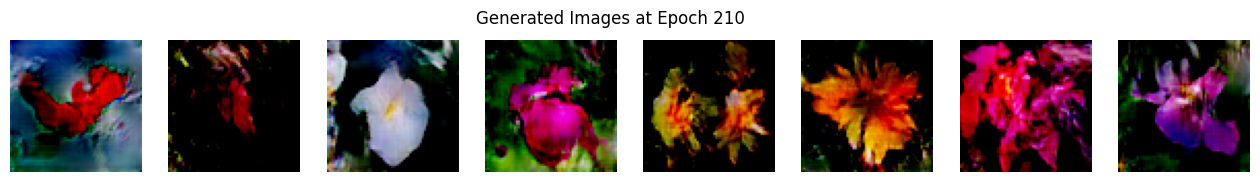

Epochs:  84%|████████▍ | 211/250 [1:21:16<15:06, 23.23s/it]

Epoch [211/250] Step [0] Discriminator Loss: 0.6580579280853271 Generator Loss: 0.6236173510551453
Epoch [211/250] Step [600] Discriminator Loss: 0.6556189954280853 Generator Loss: 0.6410884857177734
Epoch [211/250] Step [1200] Discriminator Loss: 0.6583692729473114 Generator Loss: 0.651373028755188
Epoch [211/250] Step [1800] Discriminator Loss: 0.6602741479873657 Generator Loss: 0.6130121946334839
Epoch [211/250] Step [2400] Discriminator Loss: 0.6603306233882904 Generator Loss: 0.6434509754180908
Epoch [211/250] Step [3000] Discriminator Loss: 0.6564376354217529 Generator Loss: 0.6329783797264099
Epoch [211/250] Step [3600] Discriminator Loss: 0.6584538221359253 Generator Loss: 0.6228613257408142
Epoch [211/250] Step [4200] Discriminator Loss: 0.6636995077133179 Generator Loss: 0.6558127999305725
Epoch [211/250] Step [4800] Discriminator Loss: 0.6584067940711975 Generator Loss: 0.6485316157341003
Epoch [211/250] Step [5400] Discriminator Loss: 0.6637918949127197 Generator Loss: 0.63

Epochs:  85%|████████▍ | 212/250 [1:21:39<14:40, 23.17s/it]

Epoch [212/250] Step [0] Discriminator Loss: 0.6589558720588684 Generator Loss: 0.5975740551948547
Epoch [212/250] Step [600] Discriminator Loss: 0.6642433106899261 Generator Loss: 0.6582071781158447
Epoch [212/250] Step [1200] Discriminator Loss: 0.6653716862201691 Generator Loss: 0.6235078573226929
Epoch [212/250] Step [1800] Discriminator Loss: 0.6602479219436646 Generator Loss: 0.5894539952278137
Epoch [212/250] Step [2400] Discriminator Loss: 0.6647064089775085 Generator Loss: 0.6470606923103333
Epoch [212/250] Step [3000] Discriminator Loss: 0.6696145832538605 Generator Loss: 0.6352357864379883
Epoch [212/250] Step [3600] Discriminator Loss: 0.6784230470657349 Generator Loss: 0.6297227740287781
Epoch [212/250] Step [4200] Discriminator Loss: 0.6945562362670898 Generator Loss: 0.6453955769538879
Epoch [212/250] Step [4800] Discriminator Loss: 0.6620554029941559 Generator Loss: 0.6309622526168823
Epoch [212/250] Step [5400] Discriminator Loss: 0.6957638263702393 Generator Loss: 0.6

Epochs:  85%|████████▌ | 213/250 [1:22:02<14:16, 23.14s/it]

Epoch [213/250] Step [0] Discriminator Loss: 0.6805266737937927 Generator Loss: 0.6308121681213379
Epoch [213/250] Step [600] Discriminator Loss: 0.7001434564590454 Generator Loss: 0.6113554835319519
Epoch [213/250] Step [1200] Discriminator Loss: 0.7001550495624542 Generator Loss: 0.6659138202667236
Epoch [213/250] Step [1800] Discriminator Loss: 0.714229553937912 Generator Loss: 0.5524852871894836
Epoch [213/250] Step [2400] Discriminator Loss: 0.6773074269294739 Generator Loss: 0.6243589520454407
Epoch [213/250] Step [3000] Discriminator Loss: 0.664609968662262 Generator Loss: 0.6237150430679321
Epoch [213/250] Step [3600] Discriminator Loss: 0.6668653786182404 Generator Loss: 0.6717554926872253
Epoch [213/250] Step [4200] Discriminator Loss: 0.7127255797386169 Generator Loss: 0.5775676965713501
Epoch [213/250] Step [4800] Discriminator Loss: 0.697393536567688 Generator Loss: 0.6406758427619934
Epoch [213/250] Step [5400] Discriminator Loss: 0.6987438499927521 Generator Loss: 0.5795

Epochs:  86%|████████▌ | 214/250 [1:22:25<13:52, 23.12s/it]

Epoch [214/250] Step [0] Discriminator Loss: 0.6817561686038971 Generator Loss: 0.6525061130523682
Epoch [214/250] Step [600] Discriminator Loss: 0.7009466290473938 Generator Loss: 0.6321644186973572
Epoch [214/250] Step [1200] Discriminator Loss: 0.6936168670654297 Generator Loss: 0.658310055732727
Epoch [214/250] Step [1800] Discriminator Loss: 0.6676554381847382 Generator Loss: 0.6176303029060364
Epoch [214/250] Step [2400] Discriminator Loss: 0.6732592880725861 Generator Loss: 0.6294721961021423
Epoch [214/250] Step [3000] Discriminator Loss: 0.6622494161128998 Generator Loss: 0.6516745090484619
Epoch [214/250] Step [3600] Discriminator Loss: 0.6780393123626709 Generator Loss: 0.6510080099105835
Epoch [214/250] Step [4200] Discriminator Loss: 0.6788989007472992 Generator Loss: 0.6102354526519775
Epoch [214/250] Step [4800] Discriminator Loss: 0.6705653071403503 Generator Loss: 0.6260827779769897
Epoch [214/250] Step [5400] Discriminator Loss: 0.6629801392555237 Generator Loss: 0.62

Epochs:  86%|████████▌ | 215/250 [1:22:48<13:28, 23.10s/it]

Epoch [215/250] Step [0] Discriminator Loss: 0.6633810997009277 Generator Loss: 0.6509783267974854
Epoch [215/250] Step [600] Discriminator Loss: 0.6647108197212219 Generator Loss: 0.6089699864387512
Epoch [215/250] Step [1200] Discriminator Loss: 0.6633491516113281 Generator Loss: 0.6346479654312134
Epoch [215/250] Step [1800] Discriminator Loss: 0.6620724201202393 Generator Loss: 0.6652455925941467
Epoch [215/250] Step [2400] Discriminator Loss: 0.659511148929596 Generator Loss: 0.6349624991416931
Epoch [215/250] Step [3000] Discriminator Loss: 0.6665280759334564 Generator Loss: 0.6058393120765686
Epoch [215/250] Step [3600] Discriminator Loss: 0.6588079929351807 Generator Loss: 0.6331613063812256
Epoch [215/250] Step [4200] Discriminator Loss: 0.6718626022338867 Generator Loss: 0.6357935070991516
Epoch [215/250] Step [4800] Discriminator Loss: 0.6581710875034332 Generator Loss: 0.617972731590271
Epoch [215/250] Step [5400] Discriminator Loss: 0.6679520606994629 Generator Loss: 0.638

Epochs:  86%|████████▋ | 216/250 [1:23:11<13:04, 23.08s/it]

Epoch [216/250] Step [0] Discriminator Loss: 0.6802761256694794 Generator Loss: 0.6421495676040649
Epoch [216/250] Step [600] Discriminator Loss: 0.6616613566875458 Generator Loss: 0.6441852450370789
Epoch [216/250] Step [1200] Discriminator Loss: 0.6563245356082916 Generator Loss: 0.6583155989646912
Epoch [216/250] Step [1800] Discriminator Loss: 0.6560332179069519 Generator Loss: 0.6511156558990479
Epoch [216/250] Step [2400] Discriminator Loss: 0.6583539545536041 Generator Loss: 0.6098455786705017
Epoch [216/250] Step [3000] Discriminator Loss: 0.6573521792888641 Generator Loss: 0.6329801082611084
Epoch [216/250] Step [3600] Discriminator Loss: 0.6550183892250061 Generator Loss: 0.6387871503829956
Epoch [216/250] Step [4200] Discriminator Loss: 0.6557698249816895 Generator Loss: 0.6301732063293457
Epoch [216/250] Step [4800] Discriminator Loss: 0.6566713452339172 Generator Loss: 0.643908679485321
Epoch [216/250] Step [5400] Discriminator Loss: 0.6597874760627747 Generator Loss: 0.65

Epochs:  87%|████████▋ | 217/250 [1:23:34<12:41, 23.08s/it]

Epoch [217/250] Step [0] Discriminator Loss: 0.6551143825054169 Generator Loss: 0.6391595005989075
Epoch [217/250] Step [600] Discriminator Loss: 0.6572153866291046 Generator Loss: 0.6300171613693237
Epoch [217/250] Step [1200] Discriminator Loss: 0.6605497598648071 Generator Loss: 0.6671008467674255
Epoch [217/250] Step [1800] Discriminator Loss: 0.6561063826084137 Generator Loss: 0.6256574392318726
Epoch [217/250] Step [2400] Discriminator Loss: 0.6603040099143982 Generator Loss: 0.6195874214172363
Epoch [217/250] Step [3000] Discriminator Loss: 0.659318596124649 Generator Loss: 0.6256622076034546
Epoch [217/250] Step [3600] Discriminator Loss: 0.655577540397644 Generator Loss: 0.6269168853759766
Epoch [217/250] Step [4200] Discriminator Loss: 0.6716898381710052 Generator Loss: 0.6434624195098877
Epoch [217/250] Step [4800] Discriminator Loss: 0.6564830541610718 Generator Loss: 0.6371042728424072
Epoch [217/250] Step [5400] Discriminator Loss: 0.6569819152355194 Generator Loss: 0.636

Epochs:  87%|████████▋ | 218/250 [1:23:57<12:18, 23.07s/it]

Epoch [218/250] Step [0] Discriminator Loss: 0.6533763110637665 Generator Loss: 0.629584014415741
Epoch [218/250] Step [600] Discriminator Loss: 0.6527364253997803 Generator Loss: 0.6408462524414062
Epoch [218/250] Step [1200] Discriminator Loss: 0.6571268141269684 Generator Loss: 0.6280783414840698
Epoch [218/250] Step [1800] Discriminator Loss: 0.6546000838279724 Generator Loss: 0.6458919644355774
Epoch [218/250] Step [2400] Discriminator Loss: 0.653603732585907 Generator Loss: 0.6268430948257446
Epoch [218/250] Step [3000] Discriminator Loss: 0.6553664207458496 Generator Loss: 0.5978261828422546
Epoch [218/250] Step [3600] Discriminator Loss: 0.6612398028373718 Generator Loss: 0.6543263792991638
Epoch [218/250] Step [4200] Discriminator Loss: 0.6545738577842712 Generator Loss: 0.614520788192749
Epoch [218/250] Step [4800] Discriminator Loss: 0.6561018228530884 Generator Loss: 0.6425930261611938
Epoch [218/250] Step [5400] Discriminator Loss: 0.6633490324020386 Generator Loss: 0.6579

Epochs:  88%|████████▊ | 219/250 [1:24:20<11:54, 23.06s/it]

Epoch [219/250] Step [0] Discriminator Loss: 0.6534616947174072 Generator Loss: 0.6394546031951904
Epoch [219/250] Step [600] Discriminator Loss: 0.6546710431575775 Generator Loss: 0.6567085385322571
Epoch [219/250] Step [1200] Discriminator Loss: 0.6551418602466583 Generator Loss: 0.6314256191253662
Epoch [219/250] Step [1800] Discriminator Loss: 0.6552787721157074 Generator Loss: 0.6441807150840759
Epoch [219/250] Step [2400] Discriminator Loss: 0.657850980758667 Generator Loss: 0.6632975935935974
Epoch [219/250] Step [3000] Discriminator Loss: 0.6559585630893707 Generator Loss: 0.6329033970832825
Epoch [219/250] Step [3600] Discriminator Loss: 0.6559909582138062 Generator Loss: 0.6337065100669861
Epoch [219/250] Step [4200] Discriminator Loss: 0.6561009883880615 Generator Loss: 0.6250993609428406
Epoch [219/250] Step [4800] Discriminator Loss: 0.6533259153366089 Generator Loss: 0.6354084014892578
Epoch [219/250] Step [5400] Discriminator Loss: 0.6546640694141388 Generator Loss: 0.63

Epochs:  88%|████████▊ | 220/250 [1:24:43<11:31, 23.06s/it]

Epoch [220/250] Step [0] Discriminator Loss: 0.6549554169178009 Generator Loss: 0.6511784791946411
Epoch [220/250] Step [600] Discriminator Loss: 0.655677855014801 Generator Loss: 0.6412306427955627
Epoch [220/250] Step [1200] Discriminator Loss: 0.658520519733429 Generator Loss: 0.6305868029594421
Epoch [220/250] Step [1800] Discriminator Loss: 0.6607641279697418 Generator Loss: 0.6547839045524597
Epoch [220/250] Step [2400] Discriminator Loss: 0.6538052558898926 Generator Loss: 0.626401960849762
Epoch [220/250] Step [3000] Discriminator Loss: 0.6577386260032654 Generator Loss: 0.6462026238441467
Epoch [220/250] Step [3600] Discriminator Loss: 0.6542159616947174 Generator Loss: 0.6477618217468262
Epoch [220/250] Step [4200] Discriminator Loss: 0.66326704621315 Generator Loss: 0.6488864421844482
Epoch [220/250] Step [4800] Discriminator Loss: 0.6547330617904663 Generator Loss: 0.6467159390449524
Epoch [220/250] Step [5400] Discriminator Loss: 0.6866691708564758 Generator Loss: 0.686231

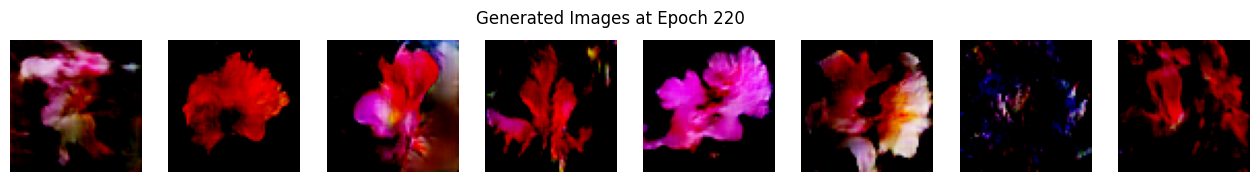

Epochs:  88%|████████▊ | 221/250 [1:25:07<11:13, 23.23s/it]

Epoch [221/250] Step [0] Discriminator Loss: 0.6741710603237152 Generator Loss: 0.671973705291748
Epoch [221/250] Step [600] Discriminator Loss: 0.6602061092853546 Generator Loss: 0.6213945150375366
Epoch [221/250] Step [1200] Discriminator Loss: 0.6807491779327393 Generator Loss: 0.6152785420417786
Epoch [221/250] Step [1800] Discriminator Loss: 0.6675196588039398 Generator Loss: 0.6427137851715088
Epoch [221/250] Step [2400] Discriminator Loss: 0.6674560308456421 Generator Loss: 0.6574986577033997
Epoch [221/250] Step [3000] Discriminator Loss: 0.6742984354496002 Generator Loss: 0.6379035711288452
Epoch [221/250] Step [3600] Discriminator Loss: 0.6624275147914886 Generator Loss: 0.6352701187133789
Epoch [221/250] Step [4200] Discriminator Loss: 0.6709104776382446 Generator Loss: 0.60355144739151
Epoch [221/250] Step [4800] Discriminator Loss: 0.6940366327762604 Generator Loss: 0.6544724106788635
Epoch [221/250] Step [5400] Discriminator Loss: 0.6828580498695374 Generator Loss: 0.6468

Epochs:  89%|████████▉ | 222/250 [1:25:30<10:48, 23.18s/it]

Epoch [222/250] Step [0] Discriminator Loss: 0.702189713716507 Generator Loss: 0.5671055316925049
Epoch [222/250] Step [600] Discriminator Loss: 0.6923067271709442 Generator Loss: 0.5926695466041565
Epoch [222/250] Step [1200] Discriminator Loss: 0.6698026657104492 Generator Loss: 0.640267014503479
Epoch [222/250] Step [1800] Discriminator Loss: 0.6936309635639191 Generator Loss: 0.6508602499961853
Epoch [222/250] Step [2400] Discriminator Loss: 0.671339213848114 Generator Loss: 0.5764540433883667
Epoch [222/250] Step [3000] Discriminator Loss: 0.6831234395503998 Generator Loss: 0.649514377117157
Epoch [222/250] Step [3600] Discriminator Loss: 0.6776825785636902 Generator Loss: 0.6221187710762024
Epoch [222/250] Step [4200] Discriminator Loss: 0.6925618946552277 Generator Loss: 0.6727195978164673
Epoch [222/250] Step [4800] Discriminator Loss: 0.6819889843463898 Generator Loss: 0.6377651691436768
Epoch [222/250] Step [5400] Discriminator Loss: 0.6666698753833771 Generator Loss: 0.64902

Epochs:  89%|████████▉ | 223/250 [1:25:53<10:24, 23.14s/it]

Epoch [223/250] Step [0] Discriminator Loss: 0.6620500683784485 Generator Loss: 0.6206110715866089
Epoch [223/250] Step [600] Discriminator Loss: 0.6781040132045746 Generator Loss: 0.6103395223617554
Epoch [223/250] Step [1200] Discriminator Loss: 0.6694210171699524 Generator Loss: 0.647781252861023
Epoch [223/250] Step [1800] Discriminator Loss: 0.6754650175571442 Generator Loss: 0.6511918306350708
Epoch [223/250] Step [2400] Discriminator Loss: 0.6696257591247559 Generator Loss: 0.6312411427497864
Epoch [223/250] Step [3000] Discriminator Loss: 0.6675466895103455 Generator Loss: 0.5936529636383057
Epoch [223/250] Step [3600] Discriminator Loss: 0.6812702119350433 Generator Loss: 0.6481460332870483
Epoch [223/250] Step [4200] Discriminator Loss: 0.66389200091362 Generator Loss: 0.655276358127594
Epoch [223/250] Step [4800] Discriminator Loss: 0.6644985675811768 Generator Loss: 0.6634624004364014
Epoch [223/250] Step [5400] Discriminator Loss: 0.6755512654781342 Generator Loss: 0.57672

Epochs:  90%|████████▉ | 224/250 [1:26:16<10:00, 23.11s/it]

Epoch [224/250] Step [0] Discriminator Loss: 0.6684157848358154 Generator Loss: 0.6199176907539368
Epoch [224/250] Step [600] Discriminator Loss: 0.6603051126003265 Generator Loss: 0.6374691128730774
Epoch [224/250] Step [1200] Discriminator Loss: 0.6635354161262512 Generator Loss: 0.6199791431427002
Epoch [224/250] Step [1800] Discriminator Loss: 0.6683646142482758 Generator Loss: 0.6328324675559998
Epoch [224/250] Step [2400] Discriminator Loss: 0.6583957672119141 Generator Loss: 0.6556916236877441
Epoch [224/250] Step [3000] Discriminator Loss: 0.6748474538326263 Generator Loss: 0.622037410736084
Epoch [224/250] Step [3600] Discriminator Loss: 0.6607808470726013 Generator Loss: 0.6653088331222534
Epoch [224/250] Step [4200] Discriminator Loss: 0.6612053215503693 Generator Loss: 0.6463984847068787
Epoch [224/250] Step [4800] Discriminator Loss: 0.6610715687274933 Generator Loss: 0.6603789925575256
Epoch [224/250] Step [5400] Discriminator Loss: 0.6732634603977203 Generator Loss: 0.65

Epochs:  90%|█████████ | 225/250 [1:26:39<09:37, 23.09s/it]

Epoch [225/250] Step [0] Discriminator Loss: 0.6592328250408173 Generator Loss: 0.643381655216217
Epoch [225/250] Step [600] Discriminator Loss: 0.6730107069015503 Generator Loss: 0.6517903208732605
Epoch [225/250] Step [1200] Discriminator Loss: 0.6600797474384308 Generator Loss: 0.6264902949333191
Epoch [225/250] Step [1800] Discriminator Loss: 0.6561733186244965 Generator Loss: 0.62621009349823
Epoch [225/250] Step [2400] Discriminator Loss: 0.6588409841060638 Generator Loss: 0.6304876804351807
Epoch [225/250] Step [3000] Discriminator Loss: 0.6622648239135742 Generator Loss: 0.6407789587974548
Epoch [225/250] Step [3600] Discriminator Loss: 0.6590388417243958 Generator Loss: 0.6722449660301208
Epoch [225/250] Step [4200] Discriminator Loss: 0.6633812189102173 Generator Loss: 0.6367947459220886
Epoch [225/250] Step [4800] Discriminator Loss: 0.668279379606247 Generator Loss: 0.6468742489814758
Epoch [225/250] Step [5400] Discriminator Loss: 0.6580603420734406 Generator Loss: 0.63749

Epochs:  90%|█████████ | 226/250 [1:27:02<09:13, 23.07s/it]

Epoch [226/250] Step [0] Discriminator Loss: 0.6619216799736023 Generator Loss: 0.6459358930587769
Epoch [226/250] Step [600] Discriminator Loss: 0.6602011024951935 Generator Loss: 0.640304446220398
Epoch [226/250] Step [1200] Discriminator Loss: 0.6597447097301483 Generator Loss: 0.6399861574172974
Epoch [226/250] Step [1800] Discriminator Loss: 0.6640079319477081 Generator Loss: 0.6365875005722046
Epoch [226/250] Step [2400] Discriminator Loss: 0.6583136916160583 Generator Loss: 0.643359899520874
Epoch [226/250] Step [3000] Discriminator Loss: 0.6677176356315613 Generator Loss: 0.619799792766571
Epoch [226/250] Step [3600] Discriminator Loss: 0.6615257561206818 Generator Loss: 0.6294353008270264
Epoch [226/250] Step [4200] Discriminator Loss: 0.6658695936203003 Generator Loss: 0.6412053108215332
Epoch [226/250] Step [4800] Discriminator Loss: 0.6574646234512329 Generator Loss: 0.6128250956535339
Epoch [226/250] Step [5400] Discriminator Loss: 0.660094290971756 Generator Loss: 0.63121

Epochs:  91%|█████████ | 227/250 [1:27:25<08:50, 23.06s/it]

Epoch [227/250] Step [0] Discriminator Loss: 0.6742333769798279 Generator Loss: 0.657715916633606
Epoch [227/250] Step [600] Discriminator Loss: 0.6596132218837738 Generator Loss: 0.6299529671669006
Epoch [227/250] Step [1200] Discriminator Loss: 0.6566089689731598 Generator Loss: 0.6515231728553772
Epoch [227/250] Step [1800] Discriminator Loss: 0.6588146090507507 Generator Loss: 0.6406772136688232
Epoch [227/250] Step [2400] Discriminator Loss: 0.664404034614563 Generator Loss: 0.6586940288543701
Epoch [227/250] Step [3000] Discriminator Loss: 0.6589974761009216 Generator Loss: 0.6173901557922363
Epoch [227/250] Step [3600] Discriminator Loss: 0.658594936132431 Generator Loss: 0.6414319276809692
Epoch [227/250] Step [4200] Discriminator Loss: 0.6604750454425812 Generator Loss: 0.6554708480834961
Epoch [227/250] Step [4800] Discriminator Loss: 0.6628724038600922 Generator Loss: 0.639898419380188
Epoch [227/250] Step [5400] Discriminator Loss: 0.6604347825050354 Generator Loss: 0.60144

Epochs:  91%|█████████ | 228/250 [1:27:48<08:27, 23.05s/it]

Epoch [228/250] Step [0] Discriminator Loss: 0.6659897565841675 Generator Loss: 0.6594157218933105
Epoch [228/250] Step [600] Discriminator Loss: 0.658613920211792 Generator Loss: 0.6478387117385864
Epoch [228/250] Step [1200] Discriminator Loss: 0.6558724641799927 Generator Loss: 0.6431258320808411
Epoch [228/250] Step [1800] Discriminator Loss: 0.6634889841079712 Generator Loss: 0.638668954372406
Epoch [228/250] Step [2400] Discriminator Loss: 0.6598493754863739 Generator Loss: 0.6166386008262634
Epoch [228/250] Step [3000] Discriminator Loss: 0.6581494808197021 Generator Loss: 0.6584913730621338
Epoch [228/250] Step [3600] Discriminator Loss: 0.6746849715709686 Generator Loss: 0.6237415075302124
Epoch [228/250] Step [4200] Discriminator Loss: 0.660669207572937 Generator Loss: 0.6625894904136658
Epoch [228/250] Step [4800] Discriminator Loss: 0.6632435321807861 Generator Loss: 0.6426050662994385
Epoch [228/250] Step [5400] Discriminator Loss: 0.6587713956832886 Generator Loss: 0.6410

Epochs:  92%|█████████▏| 229/250 [1:28:11<08:03, 23.05s/it]

Epoch [229/250] Step [0] Discriminator Loss: 0.6590240001678467 Generator Loss: 0.639096200466156
Epoch [229/250] Step [600] Discriminator Loss: 0.665132462978363 Generator Loss: 0.6672107577323914
Epoch [229/250] Step [1200] Discriminator Loss: 0.6580256819725037 Generator Loss: 0.6389562487602234
Epoch [229/250] Step [1800] Discriminator Loss: 0.6655699610710144 Generator Loss: 0.6237069964408875
Epoch [229/250] Step [2400] Discriminator Loss: 0.6610114574432373 Generator Loss: 0.623866081237793
Epoch [229/250] Step [3000] Discriminator Loss: 0.6626552939414978 Generator Loss: 0.6589165925979614
Epoch [229/250] Step [3600] Discriminator Loss: 0.6637422144412994 Generator Loss: 0.6205202341079712
Epoch [229/250] Step [4200] Discriminator Loss: 0.6591284573078156 Generator Loss: 0.6345070004463196
Epoch [229/250] Step [4800] Discriminator Loss: 0.6615365743637085 Generator Loss: 0.6222427487373352
Epoch [229/250] Step [5400] Discriminator Loss: 0.6582641005516052 Generator Loss: 0.6441

Epochs:  92%|█████████▏| 230/250 [1:28:34<07:40, 23.04s/it]

Epoch [230/250] Step [0] Discriminator Loss: 0.6612843573093414 Generator Loss: 0.6332723498344421
Epoch [230/250] Step [600] Discriminator Loss: 0.6980200409889221 Generator Loss: 0.6035091280937195
Epoch [230/250] Step [1200] Discriminator Loss: 0.6603945195674896 Generator Loss: 0.6502164006233215
Epoch [230/250] Step [1800] Discriminator Loss: 0.6589074432849884 Generator Loss: 0.6140366792678833
Epoch [230/250] Step [2400] Discriminator Loss: 0.6540793776512146 Generator Loss: 0.6440091729164124
Epoch [230/250] Step [3000] Discriminator Loss: 0.6623380482196808 Generator Loss: 0.6392152309417725
Epoch [230/250] Step [3600] Discriminator Loss: 0.6743917465209961 Generator Loss: 0.6396197080612183
Epoch [230/250] Step [4200] Discriminator Loss: 0.6679483652114868 Generator Loss: 0.5773564577102661
Epoch [230/250] Step [4800] Discriminator Loss: 0.6796025037765503 Generator Loss: 0.6679080724716187
Epoch [230/250] Step [5400] Discriminator Loss: 0.6661528646945953 Generator Loss: 0.6

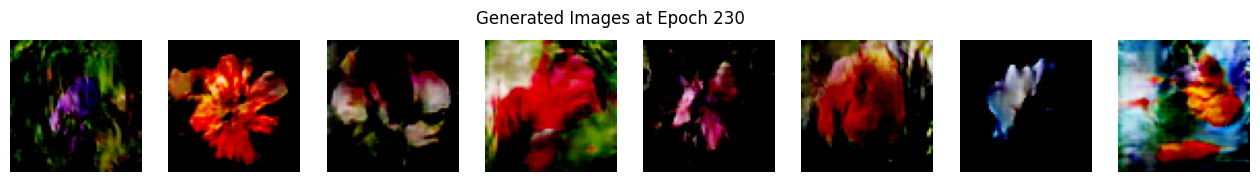

Epochs:  92%|█████████▏| 231/250 [1:28:58<07:20, 23.21s/it]

Epoch [231/250] Step [0] Discriminator Loss: 0.6629830896854401 Generator Loss: 0.6244645118713379
Epoch [231/250] Step [600] Discriminator Loss: 0.6663666069507599 Generator Loss: 0.6375309824943542
Epoch [231/250] Step [1200] Discriminator Loss: 0.6713935732841492 Generator Loss: 0.6480242013931274
Epoch [231/250] Step [1800] Discriminator Loss: 0.6675370335578918 Generator Loss: 0.6481993198394775
Epoch [231/250] Step [2400] Discriminator Loss: 0.668989360332489 Generator Loss: 0.63225257396698
Epoch [231/250] Step [3000] Discriminator Loss: 0.6674213409423828 Generator Loss: 0.6422950029373169
Epoch [231/250] Step [3600] Discriminator Loss: 0.6574485599994659 Generator Loss: 0.6234631538391113
Epoch [231/250] Step [4200] Discriminator Loss: 0.6630651354789734 Generator Loss: 0.6278914213180542
Epoch [231/250] Step [4800] Discriminator Loss: 0.6692362427711487 Generator Loss: 0.6298313736915588
Epoch [231/250] Step [5400] Discriminator Loss: 0.6601272523403168 Generator Loss: 0.6433

Epochs:  93%|█████████▎| 232/250 [1:29:21<06:56, 23.15s/it]

Epoch [232/250] Step [0] Discriminator Loss: 0.6658259630203247 Generator Loss: 0.6474263072013855
Epoch [232/250] Step [600] Discriminator Loss: 0.6656714379787445 Generator Loss: 0.6559187769889832
Epoch [232/250] Step [1200] Discriminator Loss: 0.6597277224063873 Generator Loss: 0.6719566583633423
Epoch [232/250] Step [1800] Discriminator Loss: 0.6739645600318909 Generator Loss: 0.6618626117706299
Epoch [232/250] Step [2400] Discriminator Loss: 0.6572085022926331 Generator Loss: 0.5969037413597107
Epoch [232/250] Step [3000] Discriminator Loss: 0.6664086580276489 Generator Loss: 0.6395978927612305
Epoch [232/250] Step [3600] Discriminator Loss: 0.6642767786979675 Generator Loss: 0.6499014496803284
Epoch [232/250] Step [4200] Discriminator Loss: 0.6591178774833679 Generator Loss: 0.6265437602996826
Epoch [232/250] Step [4800] Discriminator Loss: 0.6573721468448639 Generator Loss: 0.6515322923660278
Epoch [232/250] Step [5400] Discriminator Loss: 0.6574655175209045 Generator Loss: 0.6

Epochs:  93%|█████████▎| 233/250 [1:29:44<06:32, 23.10s/it]

Epoch [233/250] Step [0] Discriminator Loss: 0.6658070683479309 Generator Loss: 0.6416307687759399
Epoch [233/250] Step [600] Discriminator Loss: 0.670196145772934 Generator Loss: 0.6842702627182007
Epoch [233/250] Step [1200] Discriminator Loss: 0.6798436641693115 Generator Loss: 0.6116787791252136
Epoch [233/250] Step [1800] Discriminator Loss: 0.6703914403915405 Generator Loss: 0.6339212656021118
Epoch [233/250] Step [2400] Discriminator Loss: 0.6694647073745728 Generator Loss: 0.6624829173088074
Epoch [233/250] Step [3000] Discriminator Loss: 0.6605010032653809 Generator Loss: 0.6133792400360107
Epoch [233/250] Step [3600] Discriminator Loss: 0.6622591018676758 Generator Loss: 0.6273489594459534
Epoch [233/250] Step [4200] Discriminator Loss: 0.6850122809410095 Generator Loss: 0.6501523852348328
Epoch [233/250] Step [4800] Discriminator Loss: 0.6681755185127258 Generator Loss: 0.6315155625343323
Epoch [233/250] Step [5400] Discriminator Loss: 0.6897802650928497 Generator Loss: 0.66

Epochs:  94%|█████████▎| 234/250 [1:30:07<06:09, 23.08s/it]

Epoch [234/250] Step [0] Discriminator Loss: 0.6622982621192932 Generator Loss: 0.6279993653297424
Epoch [234/250] Step [600] Discriminator Loss: 0.688250720500946 Generator Loss: 0.6768406629562378
Epoch [234/250] Step [1200] Discriminator Loss: 0.6632631719112396 Generator Loss: 0.6390891671180725
Epoch [234/250] Step [1800] Discriminator Loss: 0.6613528728485107 Generator Loss: 0.6264179944992065
Epoch [234/250] Step [2400] Discriminator Loss: 0.6946854293346405 Generator Loss: 0.6746066808700562
Epoch [234/250] Step [3000] Discriminator Loss: 0.6651663482189178 Generator Loss: 0.6651740670204163
Epoch [234/250] Step [3600] Discriminator Loss: 0.665284276008606 Generator Loss: 0.6572040915489197
Epoch [234/250] Step [4200] Discriminator Loss: 0.6667826473712921 Generator Loss: 0.6544671654701233
Epoch [234/250] Step [4800] Discriminator Loss: 0.6723387539386749 Generator Loss: 0.6031376123428345
Epoch [234/250] Step [5400] Discriminator Loss: 0.6694642007350922 Generator Loss: 0.658

Epochs:  94%|█████████▍| 235/250 [1:30:30<05:45, 23.06s/it]

Epoch [235/250] Step [0] Discriminator Loss: 0.6651632785797119 Generator Loss: 0.6562881469726562
Epoch [235/250] Step [600] Discriminator Loss: 0.6691895425319672 Generator Loss: 0.6445069313049316
Epoch [235/250] Step [1200] Discriminator Loss: 0.6795670390129089 Generator Loss: 0.6624444723129272
Epoch [235/250] Step [1800] Discriminator Loss: 0.657159149646759 Generator Loss: 0.6363519430160522
Epoch [235/250] Step [2400] Discriminator Loss: 0.6719777286052704 Generator Loss: 0.6306191086769104
Epoch [235/250] Step [3000] Discriminator Loss: 0.6681543588638306 Generator Loss: 0.6650108098983765
Epoch [235/250] Step [3600] Discriminator Loss: 0.6645035147666931 Generator Loss: 0.6443831324577332
Epoch [235/250] Step [4200] Discriminator Loss: 0.6567215025424957 Generator Loss: 0.6235023736953735
Epoch [235/250] Step [4800] Discriminator Loss: 0.6667203605175018 Generator Loss: 0.6426486968994141
Epoch [235/250] Step [5400] Discriminator Loss: 0.6650060713291168 Generator Loss: 0.63

Epochs:  94%|█████████▍| 236/250 [1:30:53<05:22, 23.05s/it]

Epoch [236/250] Step [0] Discriminator Loss: 0.6609105467796326 Generator Loss: 0.6438746452331543
Epoch [236/250] Step [600] Discriminator Loss: 0.6637810468673706 Generator Loss: 0.6309106349945068
Epoch [236/250] Step [1200] Discriminator Loss: 0.6579480171203613 Generator Loss: 0.6346539855003357
Epoch [236/250] Step [1800] Discriminator Loss: 0.6555863916873932 Generator Loss: 0.6363035440444946
Epoch [236/250] Step [2400] Discriminator Loss: 0.6685026586055756 Generator Loss: 0.6294825077056885
Epoch [236/250] Step [3000] Discriminator Loss: 0.6704639792442322 Generator Loss: 0.6461301445960999
Epoch [236/250] Step [3600] Discriminator Loss: 0.6587014496326447 Generator Loss: 0.6492480635643005
Epoch [236/250] Step [4200] Discriminator Loss: 0.6591108441352844 Generator Loss: 0.6351947784423828
Epoch [236/250] Step [4800] Discriminator Loss: 0.656931608915329 Generator Loss: 0.6429743766784668
Epoch [236/250] Step [5400] Discriminator Loss: 0.6703717112541199 Generator Loss: 0.60

Epochs:  95%|█████████▍| 237/250 [1:31:16<04:59, 23.04s/it]

Epoch [237/250] Step [0] Discriminator Loss: 0.6774359345436096 Generator Loss: 0.628578782081604
Epoch [237/250] Step [600] Discriminator Loss: 0.667919933795929 Generator Loss: 0.632740318775177
Epoch [237/250] Step [1200] Discriminator Loss: 0.6703153848648071 Generator Loss: 0.6395304203033447
Epoch [237/250] Step [1800] Discriminator Loss: 0.6583315134048462 Generator Loss: 0.645109236240387
Epoch [237/250] Step [2400] Discriminator Loss: 0.663876473903656 Generator Loss: 0.6213183403015137
Epoch [237/250] Step [3000] Discriminator Loss: 0.6584843099117279 Generator Loss: 0.6551594138145447
Epoch [237/250] Step [3600] Discriminator Loss: 0.6599279046058655 Generator Loss: 0.6340977549552917
Epoch [237/250] Step [4200] Discriminator Loss: 0.6589977741241455 Generator Loss: 0.6476949453353882
Epoch [237/250] Step [4800] Discriminator Loss: 0.6609250605106354 Generator Loss: 0.6650313138961792
Epoch [237/250] Step [5400] Discriminator Loss: 0.661178469657898 Generator Loss: 0.6443646

Epochs:  95%|█████████▌| 238/250 [1:31:39<04:36, 23.03s/it]

Epoch [238/250] Step [0] Discriminator Loss: 0.6659964621067047 Generator Loss: 0.6081026792526245
Epoch [238/250] Step [600] Discriminator Loss: 0.6555226147174835 Generator Loss: 0.6372663974761963
Epoch [238/250] Step [1200] Discriminator Loss: 0.660180002450943 Generator Loss: 0.636182963848114
Epoch [238/250] Step [1800] Discriminator Loss: 0.659337967634201 Generator Loss: 0.6436912417411804
Epoch [238/250] Step [2400] Discriminator Loss: 0.6677943468093872 Generator Loss: 0.6224920153617859
Epoch [238/250] Step [3000] Discriminator Loss: 0.6600071489810944 Generator Loss: 0.6503639817237854
Epoch [238/250] Step [3600] Discriminator Loss: 0.6618056297302246 Generator Loss: 0.656128466129303
Epoch [238/250] Step [4200] Discriminator Loss: 0.6572352349758148 Generator Loss: 0.6220378279685974
Epoch [238/250] Step [4800] Discriminator Loss: 0.6622216701507568 Generator Loss: 0.6174827218055725
Epoch [238/250] Step [5400] Discriminator Loss: 0.6563803255558014 Generator Loss: 0.64649

Epochs:  96%|█████████▌| 239/250 [1:32:02<04:13, 23.03s/it]

Epoch [239/250] Step [0] Discriminator Loss: 0.6592551469802856 Generator Loss: 0.6236192584037781
Epoch [239/250] Step [600] Discriminator Loss: 0.6633159518241882 Generator Loss: 0.6598459482192993
Epoch [239/250] Step [1200] Discriminator Loss: 0.6661988794803619 Generator Loss: 0.6195088028907776
Epoch [239/250] Step [1800] Discriminator Loss: 0.6576386988162994 Generator Loss: 0.6506624817848206
Epoch [239/250] Step [2400] Discriminator Loss: 0.6608753204345703 Generator Loss: 0.6535485982894897
Epoch [239/250] Step [3000] Discriminator Loss: 0.6681094765663147 Generator Loss: 0.6493917107582092
Epoch [239/250] Step [3600] Discriminator Loss: 0.66143599152565 Generator Loss: 0.6424715518951416
Epoch [239/250] Step [4200] Discriminator Loss: 0.6723093390464783 Generator Loss: 0.6190336346626282
Epoch [239/250] Step [4800] Discriminator Loss: 0.6589000523090363 Generator Loss: 0.6302900314331055
Epoch [239/250] Step [5400] Discriminator Loss: 0.6568303108215332 Generator Loss: 0.624

Epochs:  96%|█████████▌| 240/250 [1:32:25<03:50, 23.02s/it]

Epoch [240/250] Step [0] Discriminator Loss: 0.6610560417175293 Generator Loss: 0.6314160227775574
Epoch [240/250] Step [600] Discriminator Loss: 0.6602318286895752 Generator Loss: 0.6420789361000061
Epoch [240/250] Step [1200] Discriminator Loss: 0.6587566435337067 Generator Loss: 0.6394016742706299
Epoch [240/250] Step [1800] Discriminator Loss: 0.6595166921615601 Generator Loss: 0.6309593915939331
Epoch [240/250] Step [2400] Discriminator Loss: 0.6568937301635742 Generator Loss: 0.6342249512672424
Epoch [240/250] Step [3000] Discriminator Loss: 0.6563166379928589 Generator Loss: 0.6400027275085449
Epoch [240/250] Step [3600] Discriminator Loss: 0.6546964347362518 Generator Loss: 0.6539777517318726
Epoch [240/250] Step [4200] Discriminator Loss: 0.6606911420822144 Generator Loss: 0.6508992910385132
Epoch [240/250] Step [4800] Discriminator Loss: 0.6634342074394226 Generator Loss: 0.6263031363487244
Epoch [240/250] Step [5400] Discriminator Loss: 0.6592200398445129 Generator Loss: 0.6

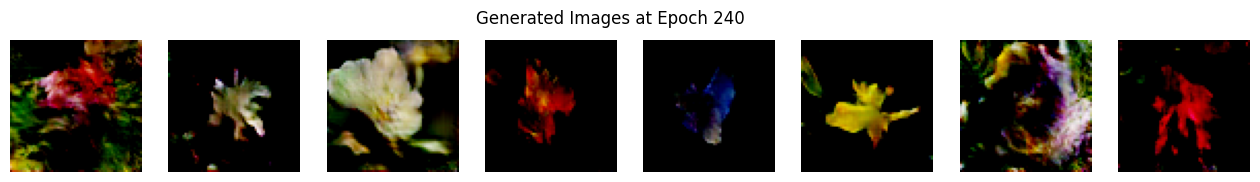

Epochs:  96%|█████████▋| 241/250 [1:32:49<03:29, 23.30s/it]

Epoch [241/250] Step [0] Discriminator Loss: 0.6592491865158081 Generator Loss: 0.6554208397865295
Epoch [241/250] Step [600] Discriminator Loss: 0.6605229377746582 Generator Loss: 0.6488855481147766
Epoch [241/250] Step [1200] Discriminator Loss: 0.6582504212856293 Generator Loss: 0.6195337176322937
Epoch [241/250] Step [1800] Discriminator Loss: 0.6605542898178101 Generator Loss: 0.6388403177261353
Epoch [241/250] Step [2400] Discriminator Loss: 0.6615093946456909 Generator Loss: 0.6365998983383179
Epoch [241/250] Step [3000] Discriminator Loss: 0.6599092781543732 Generator Loss: 0.6364935636520386
Epoch [241/250] Step [3600] Discriminator Loss: 0.6543892323970795 Generator Loss: 0.6324650049209595
Epoch [241/250] Step [4200] Discriminator Loss: 0.6542332470417023 Generator Loss: 0.6296156048774719
Epoch [241/250] Step [4800] Discriminator Loss: 0.6594200432300568 Generator Loss: 0.6170119047164917
Epoch [241/250] Step [5400] Discriminator Loss: 0.6569095551967621 Generator Loss: 0.6

Epochs:  97%|█████████▋| 242/250 [1:33:12<03:05, 23.21s/it]

Epoch [242/250] Step [0] Discriminator Loss: 0.6650934815406799 Generator Loss: 0.6540558934211731
Epoch [242/250] Step [600] Discriminator Loss: 0.6586529016494751 Generator Loss: 0.6381284594535828
Epoch [242/250] Step [1200] Discriminator Loss: 0.6633616983890533 Generator Loss: 0.6357706189155579
Epoch [242/250] Step [1800] Discriminator Loss: 0.6584806442260742 Generator Loss: 0.6737693548202515
Epoch [242/250] Step [2400] Discriminator Loss: 0.663461834192276 Generator Loss: 0.6414529085159302
Epoch [242/250] Step [3000] Discriminator Loss: 0.6618881821632385 Generator Loss: 0.6356445550918579
Epoch [242/250] Step [3600] Discriminator Loss: 0.6612202823162079 Generator Loss: 0.6503781676292419
Epoch [242/250] Step [4200] Discriminator Loss: 0.6603047847747803 Generator Loss: 0.6541419625282288
Epoch [242/250] Step [4800] Discriminator Loss: 0.669499009847641 Generator Loss: 0.6167244911193848
Epoch [242/250] Step [5400] Discriminator Loss: 0.6564507186412811 Generator Loss: 0.668

Epochs:  97%|█████████▋| 243/250 [1:33:35<02:42, 23.15s/it]

Epoch [243/250] Step [0] Discriminator Loss: 0.6689730584621429 Generator Loss: 0.6159508228302002
Epoch [243/250] Step [600] Discriminator Loss: 0.6574160754680634 Generator Loss: 0.6176319122314453
Epoch [243/250] Step [1200] Discriminator Loss: 0.6590467095375061 Generator Loss: 0.6258865594863892
Epoch [243/250] Step [1800] Discriminator Loss: 0.6546811461448669 Generator Loss: 0.6387929916381836
Epoch [243/250] Step [2400] Discriminator Loss: 0.6606413424015045 Generator Loss: 0.6516554951667786
Epoch [243/250] Step [3000] Discriminator Loss: 0.6584648489952087 Generator Loss: 0.651141881942749
Epoch [243/250] Step [3600] Discriminator Loss: 0.6594553589820862 Generator Loss: 0.6533285975456238
Epoch [243/250] Step [4200] Discriminator Loss: 0.6567201912403107 Generator Loss: 0.6252227425575256
Epoch [243/250] Step [4800] Discriminator Loss: 0.6633642315864563 Generator Loss: 0.63690185546875
Epoch [243/250] Step [5400] Discriminator Loss: 0.6560390293598175 Generator Loss: 0.6557

Epochs:  98%|█████████▊| 244/250 [1:33:58<02:18, 23.10s/it]

Epoch [244/250] Step [0] Discriminator Loss: 0.6546449959278107 Generator Loss: 0.6326500177383423
Epoch [244/250] Step [600] Discriminator Loss: 0.657602459192276 Generator Loss: 0.6304945349693298
Epoch [244/250] Step [1200] Discriminator Loss: 0.6580381989479065 Generator Loss: 0.6362047791481018
Epoch [244/250] Step [1800] Discriminator Loss: 0.6588136851787567 Generator Loss: 0.6576908826828003
Epoch [244/250] Step [2400] Discriminator Loss: 0.6615349650382996 Generator Loss: 0.6337061524391174
Epoch [244/250] Step [3000] Discriminator Loss: 0.6695840358734131 Generator Loss: 0.6631659865379333
Epoch [244/250] Step [3600] Discriminator Loss: 0.6592269241809845 Generator Loss: 0.6621625423431396
Epoch [244/250] Step [4200] Discriminator Loss: 0.6615596115589142 Generator Loss: 0.6266867518424988
Epoch [244/250] Step [4800] Discriminator Loss: 0.6601381897926331 Generator Loss: 0.6484110355377197
Epoch [244/250] Step [5400] Discriminator Loss: 0.6622483730316162 Generator Loss: 0.64

Epochs:  98%|█████████▊| 245/250 [1:34:21<01:55, 23.08s/it]

Epoch [245/250] Step [0] Discriminator Loss: 0.67293381690979 Generator Loss: 0.6536555290222168
Epoch [245/250] Step [600] Discriminator Loss: 0.6688928008079529 Generator Loss: 0.6146697402000427
Epoch [245/250] Step [1200] Discriminator Loss: 0.6585010886192322 Generator Loss: 0.6334123015403748
Epoch [245/250] Step [1800] Discriminator Loss: 0.6634125113487244 Generator Loss: 0.633091390132904
Epoch [245/250] Step [2400] Discriminator Loss: 0.666271835565567 Generator Loss: 0.6363283395767212
Epoch [245/250] Step [3000] Discriminator Loss: 0.6627085208892822 Generator Loss: 0.660076916217804
Epoch [245/250] Step [3600] Discriminator Loss: 0.6609509885311127 Generator Loss: 0.6239673495292664
Epoch [245/250] Step [4200] Discriminator Loss: 0.659562349319458 Generator Loss: 0.6276405453681946
Epoch [245/250] Step [4800] Discriminator Loss: 0.6654291152954102 Generator Loss: 0.6376782655715942
Epoch [245/250] Step [5400] Discriminator Loss: 0.6648916602134705 Generator Loss: 0.6504420

Epochs:  98%|█████████▊| 246/250 [1:34:44<01:32, 23.05s/it]

Epoch [246/250] Step [0] Discriminator Loss: 0.6601199209690094 Generator Loss: 0.6403975486755371
Epoch [246/250] Step [600] Discriminator Loss: 0.657396674156189 Generator Loss: 0.6464419364929199
Epoch [246/250] Step [1200] Discriminator Loss: 0.6805922389030457 Generator Loss: 0.6690657734870911
Epoch [246/250] Step [1800] Discriminator Loss: 0.6733344197273254 Generator Loss: 0.6194126605987549
Epoch [246/250] Step [2400] Discriminator Loss: 0.6640805304050446 Generator Loss: 0.6353573203086853
Epoch [246/250] Step [3000] Discriminator Loss: 0.6927635371685028 Generator Loss: 0.6416253447532654
Epoch [246/250] Step [3600] Discriminator Loss: 0.6880671381950378 Generator Loss: 0.6551499962806702
Epoch [246/250] Step [4200] Discriminator Loss: 0.6647105813026428 Generator Loss: 0.6273258328437805
Epoch [246/250] Step [4800] Discriminator Loss: 0.6698845028877258 Generator Loss: 0.6146897077560425
Epoch [246/250] Step [5400] Discriminator Loss: 0.6593089699745178 Generator Loss: 0.62

Epochs:  99%|█████████▉| 247/250 [1:35:07<01:09, 23.04s/it]

Epoch [247/250] Step [0] Discriminator Loss: 0.6604889929294586 Generator Loss: 0.6672807931900024
Epoch [247/250] Step [600] Discriminator Loss: 0.6627585887908936 Generator Loss: 0.6317227482795715
Epoch [247/250] Step [1200] Discriminator Loss: 0.6587368845939636 Generator Loss: 0.6487370729446411
Epoch [247/250] Step [1800] Discriminator Loss: 0.6806933283805847 Generator Loss: 0.6431311368942261
Epoch [247/250] Step [2400] Discriminator Loss: 0.6648181080818176 Generator Loss: 0.6337292194366455
Epoch [247/250] Step [3000] Discriminator Loss: 0.6591792702674866 Generator Loss: 0.6238447427749634
Epoch [247/250] Step [3600] Discriminator Loss: 0.6579113006591797 Generator Loss: 0.6366645097732544
Epoch [247/250] Step [4200] Discriminator Loss: 0.6590984165668488 Generator Loss: 0.6489825248718262
Epoch [247/250] Step [4800] Discriminator Loss: 0.6591221392154694 Generator Loss: 0.6504184007644653
Epoch [247/250] Step [5400] Discriminator Loss: 0.6547087132930756 Generator Loss: 0.6

Epochs:  99%|█████████▉| 248/250 [1:35:30<00:46, 23.03s/it]

Epoch [248/250] Step [0] Discriminator Loss: 0.6582685708999634 Generator Loss: 0.6546326279640198
Epoch [248/250] Step [600] Discriminator Loss: 0.6592565476894379 Generator Loss: 0.6488263607025146
Epoch [248/250] Step [1200] Discriminator Loss: 0.6548182368278503 Generator Loss: 0.6296217441558838
Epoch [248/250] Step [1800] Discriminator Loss: 0.665191113948822 Generator Loss: 0.6219360828399658
Epoch [248/250] Step [2400] Discriminator Loss: 0.6569212079048157 Generator Loss: 0.6204280853271484
Epoch [248/250] Step [3000] Discriminator Loss: 0.6584629416465759 Generator Loss: 0.6221389770507812
Epoch [248/250] Step [3600] Discriminator Loss: 0.6637012958526611 Generator Loss: 0.6638814806938171
Epoch [248/250] Step [4200] Discriminator Loss: 0.6596420705318451 Generator Loss: 0.6532676815986633
Epoch [248/250] Step [4800] Discriminator Loss: 0.6575855910778046 Generator Loss: 0.6353461742401123
Epoch [248/250] Step [5400] Discriminator Loss: 0.6553863286972046 Generator Loss: 0.64

Epochs: 100%|█████████▉| 249/250 [1:35:53<00:23, 23.03s/it]

Epoch [249/250] Step [0] Discriminator Loss: 0.6633009016513824 Generator Loss: 0.6519293785095215
Epoch [249/250] Step [600] Discriminator Loss: 0.6550606489181519 Generator Loss: 0.6335490942001343
Epoch [249/250] Step [1200] Discriminator Loss: 0.6546086370944977 Generator Loss: 0.6423801779747009
Epoch [249/250] Step [1800] Discriminator Loss: 0.6628764867782593 Generator Loss: 0.6291036605834961
Epoch [249/250] Step [2400] Discriminator Loss: 0.6680861711502075 Generator Loss: 0.6246339678764343
Epoch [249/250] Step [3000] Discriminator Loss: 0.65899658203125 Generator Loss: 0.6364282965660095
Epoch [249/250] Step [3600] Discriminator Loss: 0.6554488837718964 Generator Loss: 0.6305584907531738
Epoch [249/250] Step [4200] Discriminator Loss: 0.6563646793365479 Generator Loss: 0.6315476894378662
Epoch [249/250] Step [4800] Discriminator Loss: 0.660334050655365 Generator Loss: 0.6351727247238159
Epoch [249/250] Step [5400] Discriminator Loss: 0.6561640202999115 Generator Loss: 0.6235

Epochs: 100%|██████████| 250/250 [1:36:16<00:00, 23.11s/it]


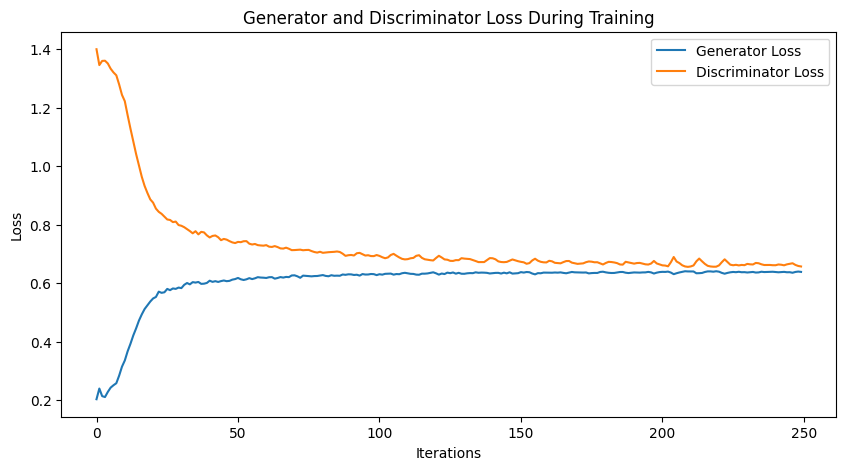

Training finished.


In [23]:
import torch
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

torch.cuda.empty_cache()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


lr = 0.0002             
beta1 = 0.5             
batch_size = 64         
epochs = 250     
latent_dim = 100       
image_size = 64         
condition_dim = 128    


output_dir = 'generated_images'
os.makedirs(output_dir, exist_ok=True)

writer = SummaryWriter('runs/GAN_training')
gen_model = Stage1Generator().to(device)
dis_model = Stage1Discriminator().to(device)
adversarial_model = AdversarialModel(gen_model, dis_model).to(device)


gen_optimizer = optim.Adam(gen_model.parameters(), lr=0.0001, betas=(beta1, 0.999))
dis_optimizer = optim.Adam(dis_model.parameters(), lr=0.0002, betas=(beta1, 0.999))

discrminator_loss = torch.nn.BCELoss()
generator_loss = torch.nn.MSELoss()

real_label = 0.9
fake_label = 0.1
save_interval = 10
image_save_interval = 10


global_step = 0 
image_keys = list(image_tensor_dict.keys())

gen_losses = []
dis_losses = []

# Training loop
for epoch in tqdm(range(epochs), desc="Epochs"):  
    gen_epoch_loss = 0
    dis_epoch_loss = 0
    num_batches = len(image_tensor_dict) // batch_size
    for i in range(0, len(image_tensor_dict), batch_size):  
        batch_keys = image_keys[i:i+batch_size]
        
        # Train with real images
        dis_model.zero_grad()
        real_images = torch.stack([image_tensor_dict[key] for key in batch_keys]).to(device)  # Batch of real images
        real_embeddings = torch.stack([ordered_embeddings_dict[key] for key in batch_keys]).to(device)
        batch_size = real_images.size(0)
        real_labels = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
   \
        output_real = dis_model(real_images, real_embeddings).view(-1)
        dis_real_loss = discrminator_loss(output_real, real_labels)
        dis_real_loss.backward()
        noise = torch.randn(batch_size, latent_dim, device=device)  # Latent vector (noise)
        fake_images, mean_logsigma = gen_model(real_embeddings, noise)
        fake_labels = torch.full((batch_size,), fake_label, dtype=torch.float, device=device)

        output_fake = dis_model(fake_images.detach(), real_embeddings).view(-1)
        dis_fake_loss = discrminator_loss(output_fake, fake_labels)
        dis_fake_loss.backward()

        dis_optimizer.step()

        gen_model.zero_grad()
        valid, mean_logsigma = adversarial_model(real_embeddings, noise)
  
        gen_loss = generator_loss(valid, real_labels)

        kl_loss = KL_loss(mean_logsigma)
        total_gen_loss = gen_loss + 2*kl_loss
        total_gen_loss.backward()

        gen_optimizer.step()

        global_step += 1
        write_log(writer, 'Discriminator Loss', dis_real_loss.item() + dis_fake_loss.item(), global_step)
        write_log(writer, 'Generator Loss', total_gen_loss.item(), global_step)
        dis_epoch_loss += dis_real_loss.item() + dis_fake_loss.item()
        gen_epoch_loss += total_gen_loss.item()

        # Print losses and save checkpoints
        if i % 50 == 0:
            print(f'Epoch [{epoch}/{epochs}] Step [{i}] Discriminator Loss: {dis_real_loss.item() + dis_fake_loss.item()} Generator Loss: {total_gen_loss.item()}')
    dis_losses.append(dis_epoch_loss / num_batches)
    gen_losses.append(gen_epoch_loss / num_batches)

    if epoch % save_interval == 0:
        torch.save(gen_model.state_dict(), f'generator_epoch_{epoch}.pth')
        torch.save(dis_model.state_dict(), f'discriminator_epoch_{epoch}.pth')
        
    if epoch % image_save_interval == 0:
        img_path = os.path.join(output_dir, f'generated_img_epoch_{epoch}.png')
        save_rgb_img(fake_images[0], img_path)  # Save the first image in the batch for visualization
        

        plot_generated_images(fake_images, epoch)  # Plot a few generated images from the batch


plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(gen_losses, label="Generator Loss")
plt.plot(dis_losses, label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

print("Training finished.")


In [ ]:
import torch
import matplotlib.pyplot as plt
import os
from transformers import BertTokenizer, BertModel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 0.0002             
beta1 = 0.5             
batch_size = 64         
epochs = 250     
latent_dim = 100       
image_size = 64         
condition_dim = 128    

gen_model = Stage1Generator().to(device)
gen_model.load_state_dict(torch.load('generator_epoch_180.pth')) 
gen_model.eval()  


def generate_image_from_text(text_embedding, save_path):

    text_embedding = torch.tensor(text_embedding).unsqueeze(0).to(device)  

    noise = torch.randn(1, latent_dim, device=device) 


    with torch.no_grad():
        generated_image, _ = gen_model(text_embedding, noise) 


    save_and_show_image(generated_image[0], save_path)

def save_and_show_image(img, path):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    if isinstance(img, torch.Tensor):
        img = img.detach().permute(1, 2, 0).cpu().numpy()  
    ax.imshow(img)
    ax.axis("off")
    ax.set_title("Generated Image from Text")
    
    plt.savefig(path)

    plt.show()

    plt.close()

def text_to_embedding(text):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)
    
    with torch.no_grad():
                outputs = model(**inputs)

    cls_embedding = outputs.last_hidden_state[:, 0, :]
    
    return cls_embedding

# text_description = "a purple mexican petunia with a green background"
text_description = "a white japanese anemone in the dark"
# tezt_description = "a red bromelia in a pot with a green plant"
# text_description = " red trumpet creeper in the garden"
text_embedding = text_to_embedding(text_description)

# Directory to save generated image
output_dir = 'text_generated_images'
os.makedirs(output_dir, exist_ok=True)

# Generate and save the image based on the text
img_save_path = os.path.join(output_dir, 'generated_img_from_text.png')
generate_image_from_text(text_embedding, img_save_path)

print("Image generation based on text complete.")
